In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
from astropy.table import Table
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_extract import Extract_all
from spec_id import Set_rshift_params, Simple_analyze
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Chi_Squared,Calzetti, Scale_model_mult
from sim_engine import Salmon
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [74]:
ls /Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*40597*

/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.1D.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.beams.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.full.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.full.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.line.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.stack.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.stack.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.1D.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.beams.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.full.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.full.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.line.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.s

In [75]:
def Stack(wv, fl , er, flt, line, cont):
    flgrid = np.transpose(fl)
    fltgrid = np.transpose(flt)
    linegrid = np.transpose(line)
    contgrid = np.transpose(cont)
    errgrid = np.transpose(er)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, stack_flat, stack_line, stack_cont, err = np.zeros([5, len(wv[0])])
    for i in range(len(wv[0])):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return wv[0], stack, err, stack_flat, stack_line, stack_cont

def Combine_spec(Field,idnum):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*{0}*/*/Prep/*{1}*1D.fits'.format(Field, idnum))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')
    SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
    SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
    
    return np.array([SBW, SBF, SBE, SBT, SBL, SBC]), np.array([SRW, SRF, SRE, SRT, SRL, SRC])

In [76]:
B,R = Combine_spec('S',40597)

no g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered

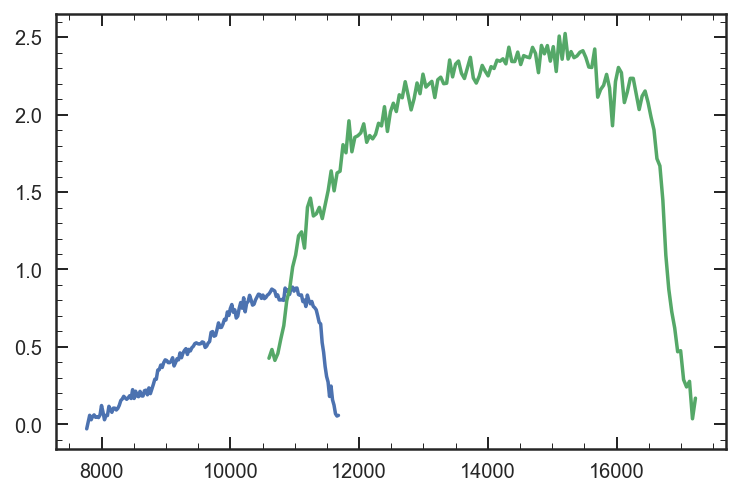

In [80]:
plt.plot(B[0],B[1])
plt.plot(R[0],R[1])


In [92]:
beam_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*40597*beams.fits')

In [101]:
fields = [U.split('/')[4] for U in beam_list]

In [103]:
flt_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[0]))

In [119]:
# grp = multifit.GroupFLT(grism_files = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[0])))
# grp2 = multifit.GroupFLT(grism_files = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[1])))
grp = 0;grp2= 0

In [117]:
ex = Extract_all(40597,'GSD',[grp,grp2])

In [118]:
ex.Phot_save()
ex.Extract_spec()
ex.Extract_BeamCutout()

no g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in power
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


In [2]:
gs = Gen_spec('GSD',40597,1.221, '../beams/o149.0_40597.g102.A.fits', '../beams/o185.0_40597.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],tmp_err=False)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


<ErrorbarContainer object of 3 artists>

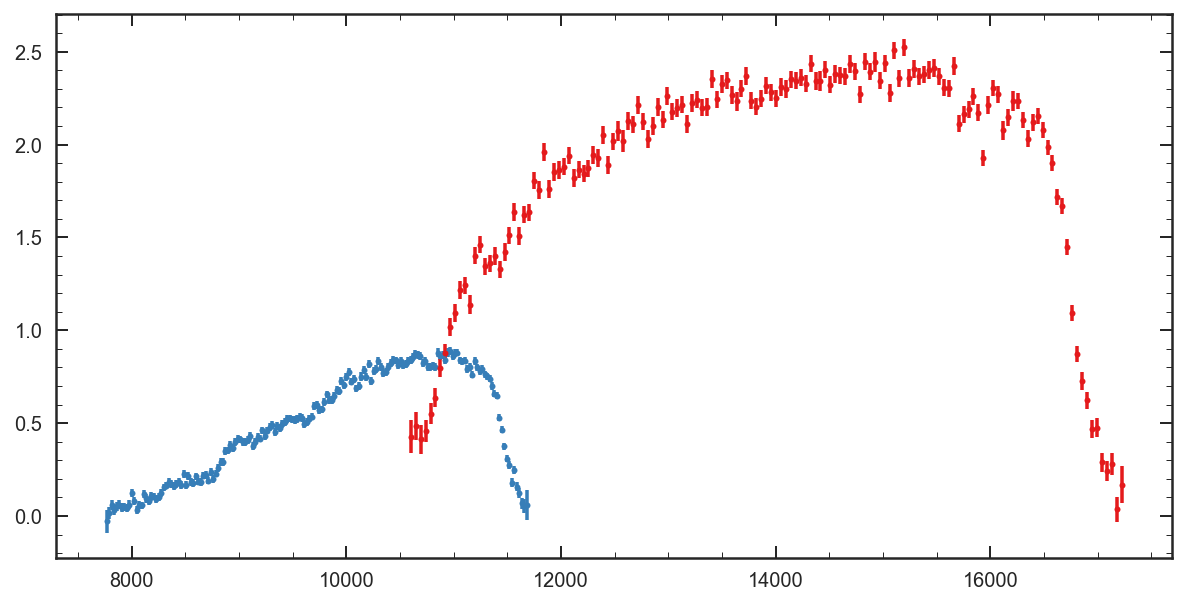

In [4]:
plt.figure(figsize=[10,5])
plt.errorbar(gs.Bwv,gs.Bflx,gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(gs.Rwv,gs.Rflx,gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

In [348]:
def Set_params(metal_i, age_i, tau_i, rshift_i, dust_i, stage):
    if stage == 0:
        age = np.round(np.arange(0.5, 6.1, .25),2)
        metal= np.round(np.arange(0.002 , 0.031, 0.003),4)
        tau = np.round(np.logspace(np.log10(0.01), np.log10(3), 8), 3)
        rshift = np.round(np.arange( rshift_i - 0.01, rshift_i + 0.011, 0.002),4)
        dust = np.round(np.arange(0, 1.1, 0.1),2)
    
    if stage == 1:
        if age_i <=1.5:
            age_i = 1.6
        age = np.round(np.arange(age_i  - 1.5, age_i  + 1.6, .125),2)
        
        if metal_i <= 0.0075:
            metal_i = 0.0095
        metal= np.round(np.arange(metal_i  - 0.0075, metal_i  + 0.0085, 0.0015),4)
        
        if tau_i <= 1:
            tau_i = 1.1 
        tau = np.round(np.logspace(np.log10(tau_i  - 1), np.log10(tau_i  + 1), 8), 3)
        rshift = np.round(np.arange( rshift_i - 0.005, rshift_i + 0.006, 0.001),4)
        
        if dust_i <= 0.25:
            dust_i = 0.25         
        dust = np.round(np.arange(dust_i - 0.25, dust_i + 0.3, 0.05),2)
    
    if stage == 2:
        if age_i <= 0.75:
            age_i = 0.85
        age = np.round(np.arange(age_i  - 0.75, age_i  + 0.85, .06),2)
        
        if metal_i <= 0.00375:
            metal_i = 0.00575
        metal= np.round(np.arange(metal_i  - 0.00375, metal_i  + 0.00475, 0.00075),4)
                
        if tau_i <= 0.5:
            tau_i = 0.51   
        tau = np.round(np.logspace(np.log10(tau_i  - 0.5), np.log10(tau_i  + 0.5), 8), 3)
        rshift = np.round(np.arange( rshift_i - 0.0025, rshift_i + 0.003, 0.0005),4)
        
        if dust_i <= 0.125:
            dust_i = 0.125    
        dust = np.round(np.arange(dust_i - 0.125, dust_i + 0.135, 0.025),3)
    
    return metal, age, tau, rshift, dust

In [349]:
m0,a0,t0,z0,d0=Set_params(0.017, 2.0, 0.1, 1.6, 0., 0)
m1,a1,t1,z1,d1=Set_params(0.023, 1.75, 0.051, 1.221, 0.0, 1)
m2,a2,t2,z2,d2=Set_params(0.017, 2.0, 0.1, 1.6, 0., 2)

print(len(m0)*len(a0)*len(t0)*len(z0)*len(d0))
print(len(m1)*len(a1)*len(t1)*len(z1)*len(d1))
print(len(m2)*len(a2)*len(t2)*len(z2)*len(d2))

222640
266200
313632


In [350]:
print(d0,len(d0))
print(d1,len(d1))
print(d2,len(d2))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] 11
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ] 11
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ] 11


In [36]:
tau = np.round(np.logspace(-2,np.log10(3),20),3)
age = np.round(np.arange(0.1, np.round(Oldest_galaxy(1.221),1) + .05,.05),2)
metal=np.round(np.arange(0.002 , 0.0305, 0.0005),4)

In [7]:
print(len(metal)*len(age)*len(tau))

90060


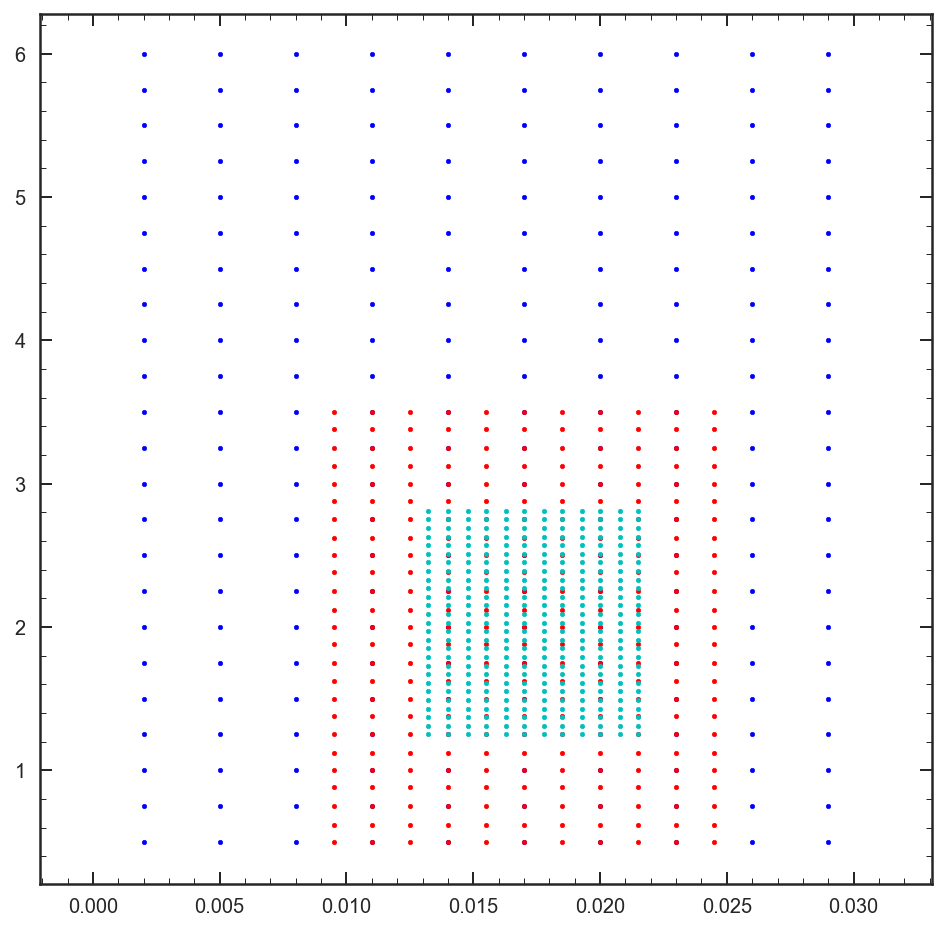

In [321]:
# x=[]
# y=[]
# plt.figure(figsize=[8,8])
# for i in metal:
#     for ii in age:
#         x.append(i)
#         y.append(ii)
plt.figure(figsize=[8,8])
# plt.scatter(x,y,color='k',s=1)

x=[]
y=[]
for i in m0:
    for ii in a0:
        x.append(i)
        y.append(ii)
        
plt.scatter(x,y,color='b',s=5)

x=[]
y=[]
for i in m1:
    for ii in a1:
        x.append(i)
        y.append(ii)
        
plt.scatter(x,y,color='r',s=5)

x=[]
y=[]
for i in m2:
    for ii in a2:
        x.append(i)
        y.append(ii)
        
plt.scatter(x,y,color='c',s=5)

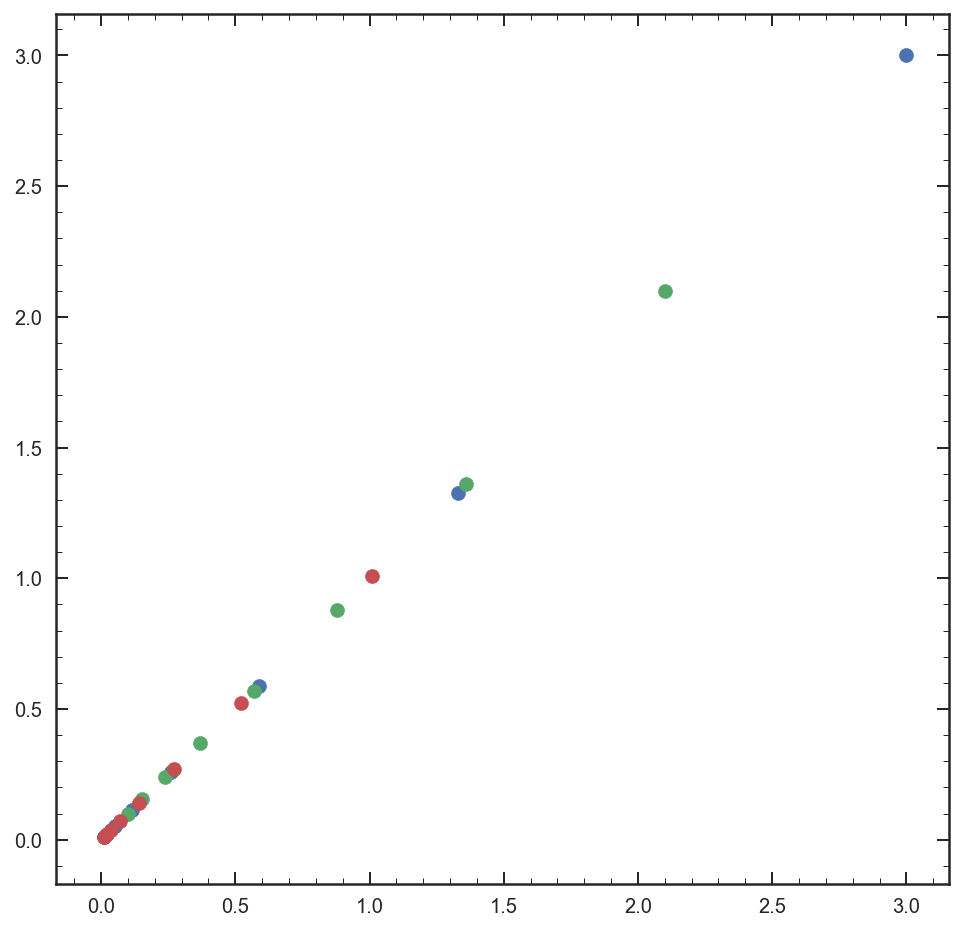

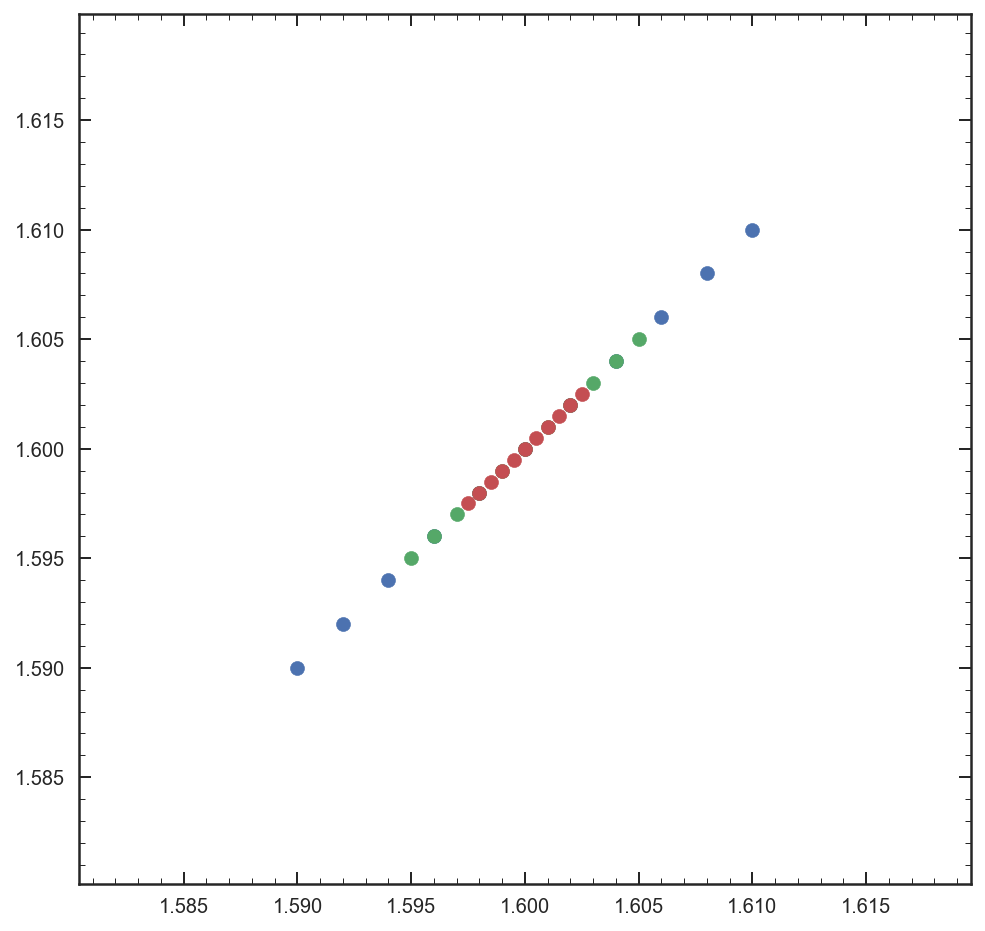

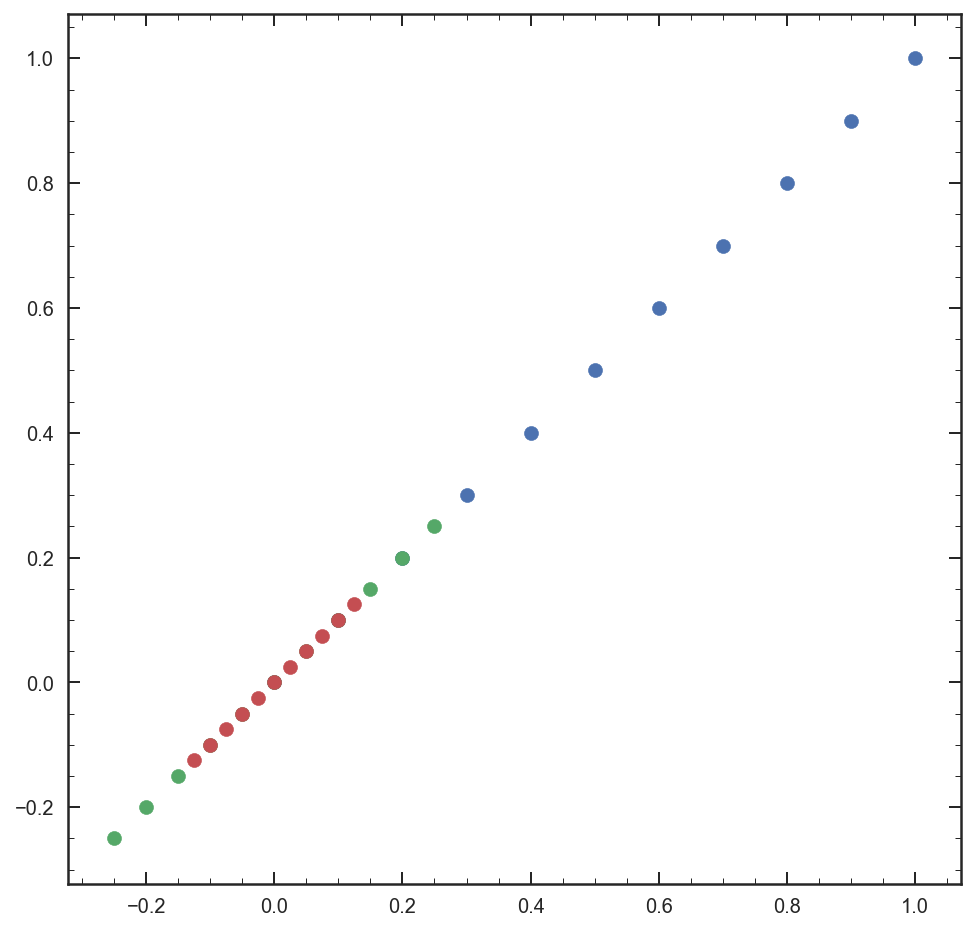

In [329]:
plt.figure(figsize=[8,8])
plt.scatter(t0,t0)
plt.scatter(t1,t1)
plt.scatter(t2,t2)

plt.figure(figsize=[8,8])
plt.scatter(z0,z0)
plt.scatter(z1,z1)
plt.scatter(z2,z2)

plt.figure(figsize=[8,8])
plt.scatter(d0,d0)
plt.scatter(d1,d1)
plt.scatter(d2,d2)

In [332]:


metal_i = 0.019
age_i = 2
tau_i = 0.1
rshift_i = 1.221
dust_i = 0.1

for x in range(3):

    m, a, t, z, d = Set_params(metal_i, age_i, tau_i, rshift_i, dust_i, x)

    Bmfl, Rmfl, Pmfl = Gen_mflgrid(gs, sp, m, a, 1.221)

    ## set some variables
    [Bmwv,Bmflx], [Rmwv,Rmflx] = gs.Sim_spec_mult(wave, flux)

    PC, Pgrid,Pmfl = Stitch_resize_redden_fit(gs.Pwv, gs.Pflx, gs.Perr, Pmfl, gs.Pwv, 
                     m, a, phot = True) 
    Bgrid,Bmfl = Stitch_resize_redden_fit(gs.Bwv, gs.Bflx, gs.Berr, Bmfl, Bmwv, 
                     m, a, PC)
    Rgrid,Rmfl = Stitch_resize_redden_fit(gs.Rwv, gs.Rflx, gs.Rerr, Rmfl, Rmwv, 
                     m, a, PC)
    
    bfZ, bft = Best_fit_model(Pgrid + Bgrid +Rgrid, m, a)
        
    metal_i = bfZ
    age_i = bft
    
    print(metal_i,age_i)

0.023 1.75
0.0245 1.75
0.0238 1.78


In [52]:
xBmfl, xRmfl, xPmfl = Gen_mflgrid(gs, sp, metal, age, 1.221)

## set some variables
[Bmwv,Bmflx], [Rmwv,Rmflx] = gs.Sim_spec_mult(wave, flux)

xPC, xPgrid, xPmfl = Stitch_resize_redden_fit(gs.Pwv, gs.Pflx, gs.Perr, xPmfl, gs.Pwv, 
                 metal, age, phot = True) 
xBgrid, xBmfl = Stitch_resize_redden_fit(gs.Bwv, gs.Bflx, gs.Berr, xBmfl, Bmwv, 
                 metal, age, xPC)
xRgrid, xRmfl = Stitch_resize_redden_fit(gs.Rwv, gs.Rflx, gs.Rerr, xRmfl, Rmwv, 
                 metal, age, xPC)

In [53]:
# Tgrid = np.array(Bgrid+Rgrid+Pgrid).astype(np.float128)
xTgrid = np.array(xBgrid+xRgrid+xPgrid).astype(np.float128)

In [54]:
def Prob(grid,metal,age):
    P = np.exp(-grid.T/2)
    return P/ np.trapz(np.trapz(P,metal,axis=1),age)

In [55]:
# PB = Prob(Bgrid,m,a)
# PR = Prob(Rgrid,m,a)
# PP = Prob(Pgrid,m,a)
# PT = Prob(Tgrid,m,a)

xPB = Prob(xBgrid,metal,age)
xPR = Prob(xRgrid,metal,age)
xPP = Prob(xPgrid,metal,age)
xPT = Prob(xTgrid,metal,age)

In [59]:
# print(Best_fit_model(Bgrid,m,a),Best_fit_model(Rgrid,m,a),Best_fit_model(Pgrid,m,a),
# Best_fit_model(Tgrid,m,a))

print(Best_fit_model(xBgrid,metal,age),Best_fit_model(xRgrid,metal,age),Best_fit_model(xPgrid,metal,age),
Best_fit_model(xTgrid,metal,age))

(0.005, 2.5) (0.012, 1.25) (0.0105, 5.1) (0.0245, 1.6)


In [57]:
M,A=np.meshgrid(m,a)
plt.figure(figsize=[6,6])
plt.contourf(M,A,PB)

plt.figure(figsize=[6,6])
plt.contourf(M,A,PR)

plt.figure(figsize=[6,6])
plt.contourf(M,A,PP)

plt.figure(figsize=[6,6])
plt.contourf(M,A,PT)
plt.scatter(0.0215,1.54,color='b')
plt.scatter(0.0283,1.48,color='r')
plt.scatter(0.0208,2.56,color='c')
plt.scatter(0.0238,1.78,color='k')

NameError: name 'm' is not defined

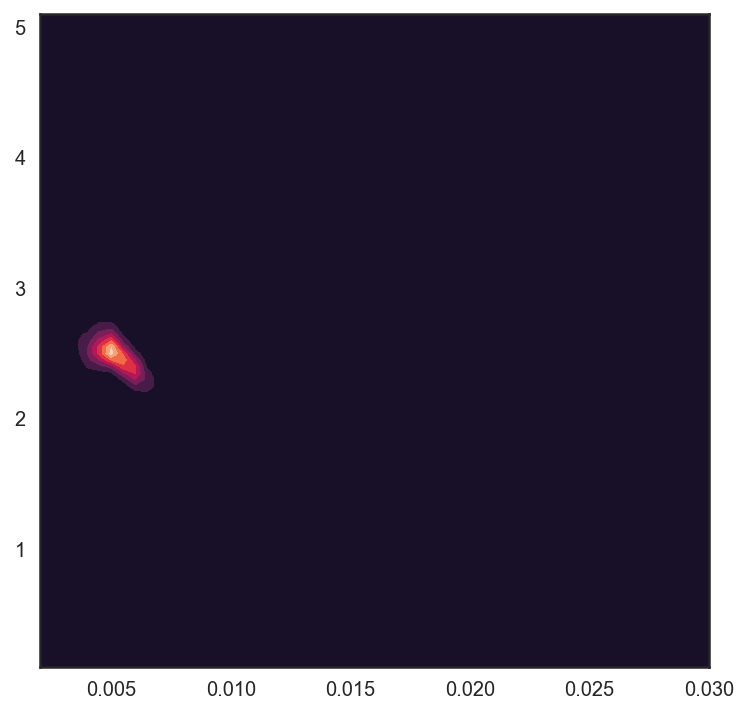

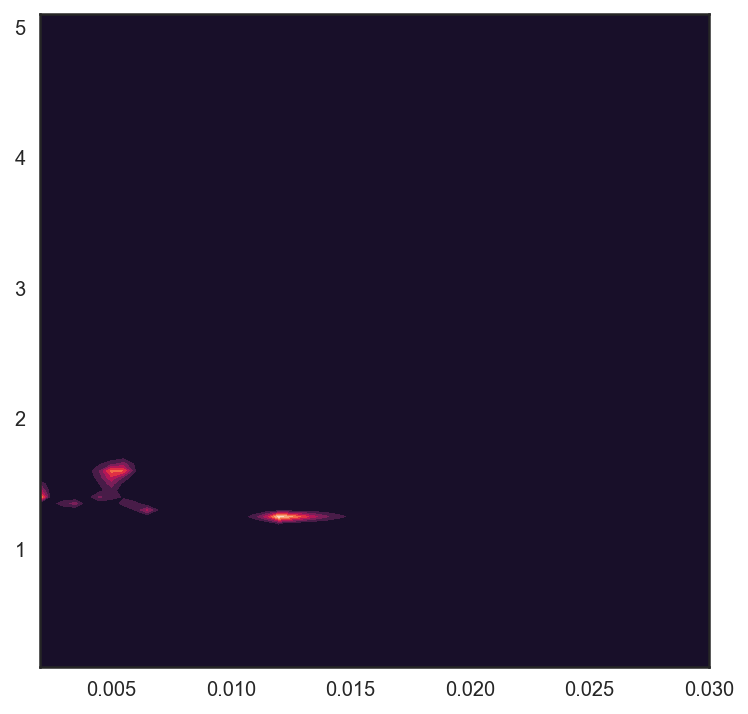

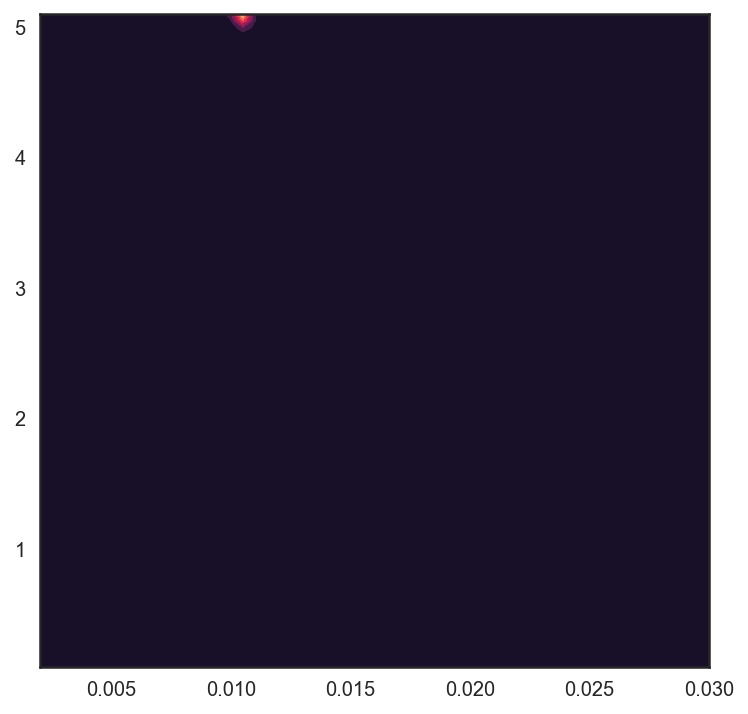

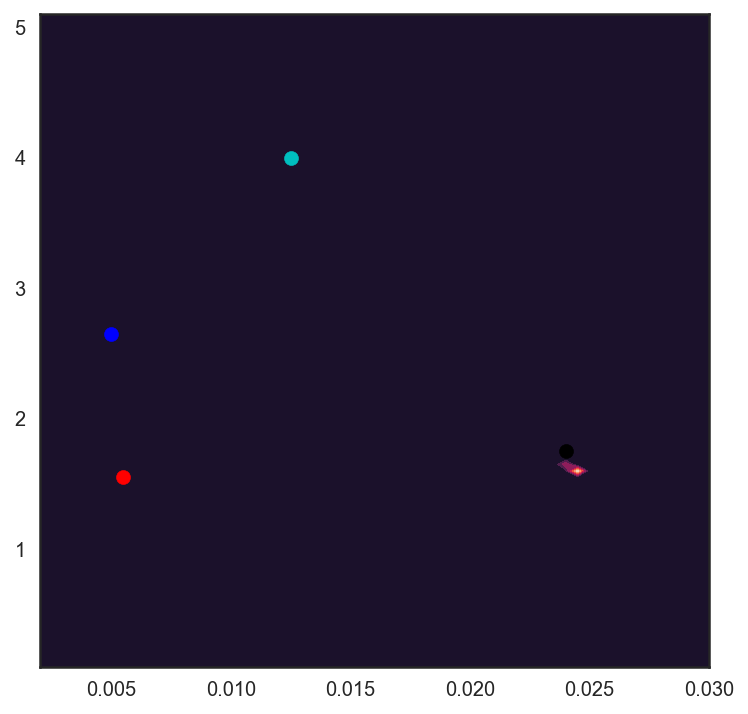

In [58]:
M,A=np.meshgrid(metal,age)
plt.figure(figsize=[6,6])
plt.contourf(M,A,xPB)

plt.figure(figsize=[6,6])
plt.contourf(M,A,xPR)

plt.figure(figsize=[6,6])
plt.contourf(M,A,xPP)

plt.figure(figsize=[6,6])
plt.contourf(M,A,xPT)
plt.scatter(0.005,2.65,color='b')
plt.scatter(0.0055,1.55,color='r')
plt.scatter(0.0125,4.0,color='c')
plt.scatter(0.024,1.75,color='k')
# (0.005, 2.65) (0.0055, 1.55) (0.0125, 4.0) (0.024, 1.75)


In [23]:
wave, flux = gs.sp.get_spectrum(tage=5.0, peraa=True)

[Bmwv,Bmflx], [Rmwv,Rmflx] = gs.Sim_spec_mult(wave*2.231, flux)
Pmflx = gs.Sim_phot_mult(wave*2.231, flux)

Bmfl = interp1d(Bmwv,Bmflx)(gs.Bwv)
Rmfl = interp1d(Rmwv,Rmflx)(gs.Rwv)

(3, 5)

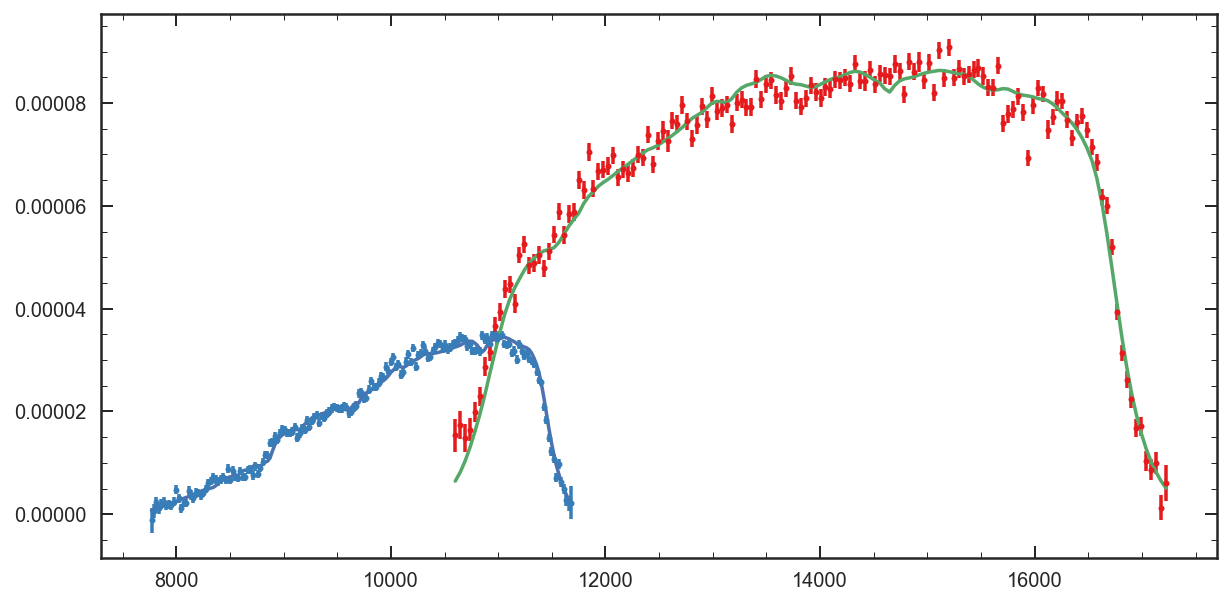

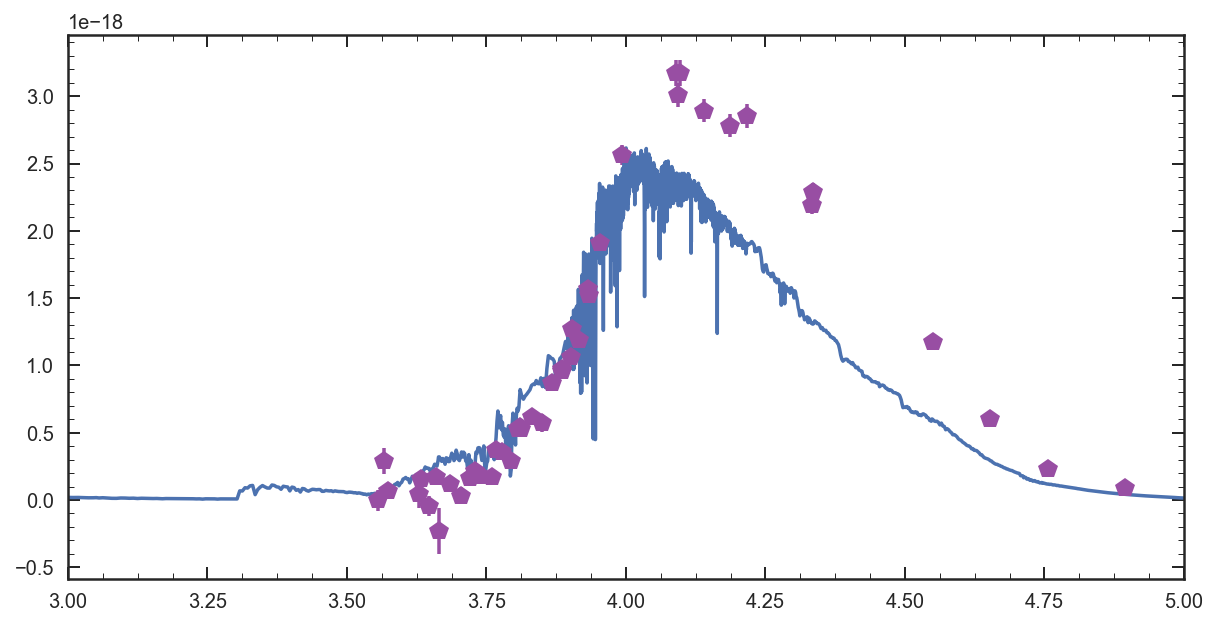

In [24]:
Cb=Scale_model(gs.Bflx,gs.Berr,Bmfl)
Cr=Scale_model(gs.Rflx,gs.Rerr,Rmfl)
Cp=Scale_model(gs.Pflx,gs.Perr,Pmflx)

plt.figure(figsize=[10,5])
plt.errorbar(gs.Bwv,gs.Bflx/Cb,gs.Berr/Cb,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(gs.Bwv,Bmfl)
plt.errorbar(gs.Rwv,gs.Rflx/Cr,gs.Rerr/Cr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(gs.Rwv,Rmfl)

plt.figure(figsize=[10,5])
plt.errorbar(np.log10(gs.Pwv), gs.Pflx, gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(wave*2.221), Cp*flux)
plt.xlim(3,5)

In [3]:
gs = Gen_spec('GND',21156,1.25, '../beams/o301.0_21156.g102.A.fits', '../beams/o300.0_21156.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],
              tmp_err=False, phot_errterm=0.03)  


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [81]:

P 0.008 4.37 0.491 1.2415 0.175

B 0.0095 4.0 0.522 1.2525 0.375

R 0.0035 6.19 0.01 1.2575 0.05

(-1e-18, 4e-18)

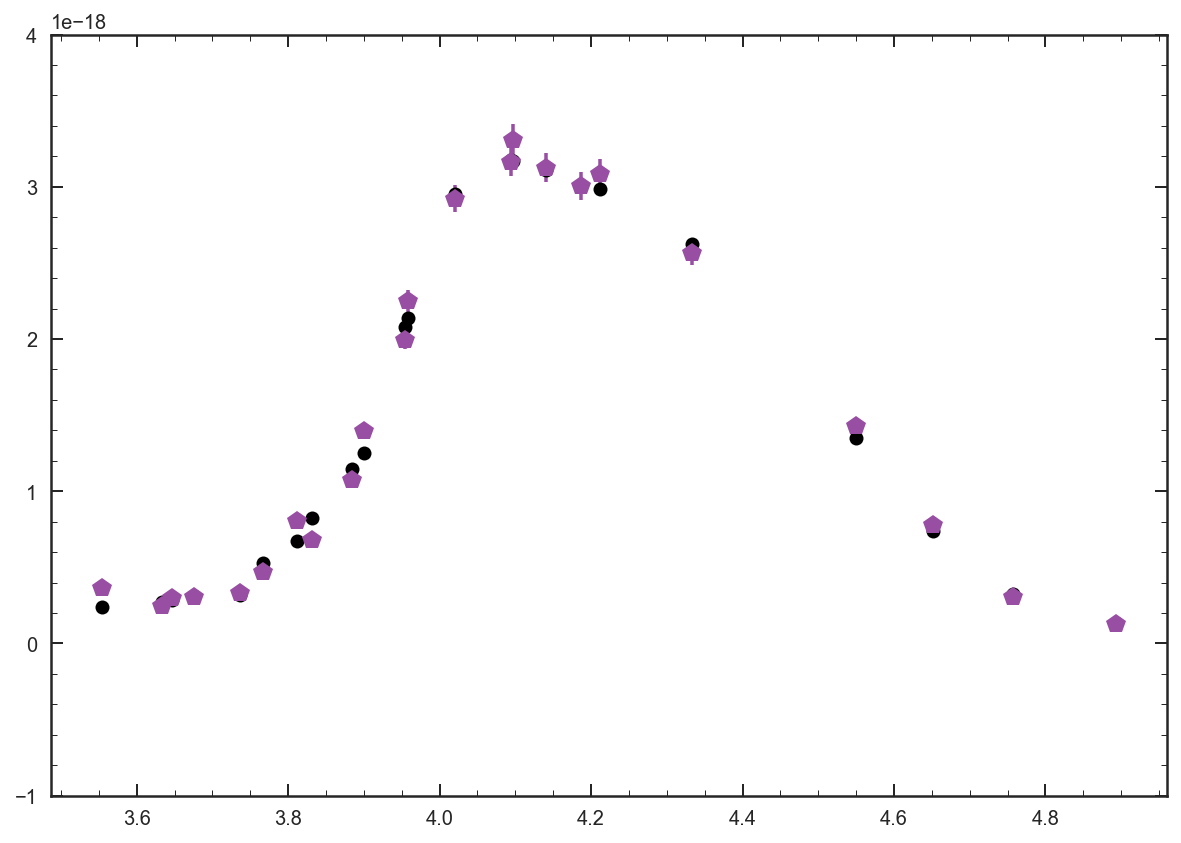

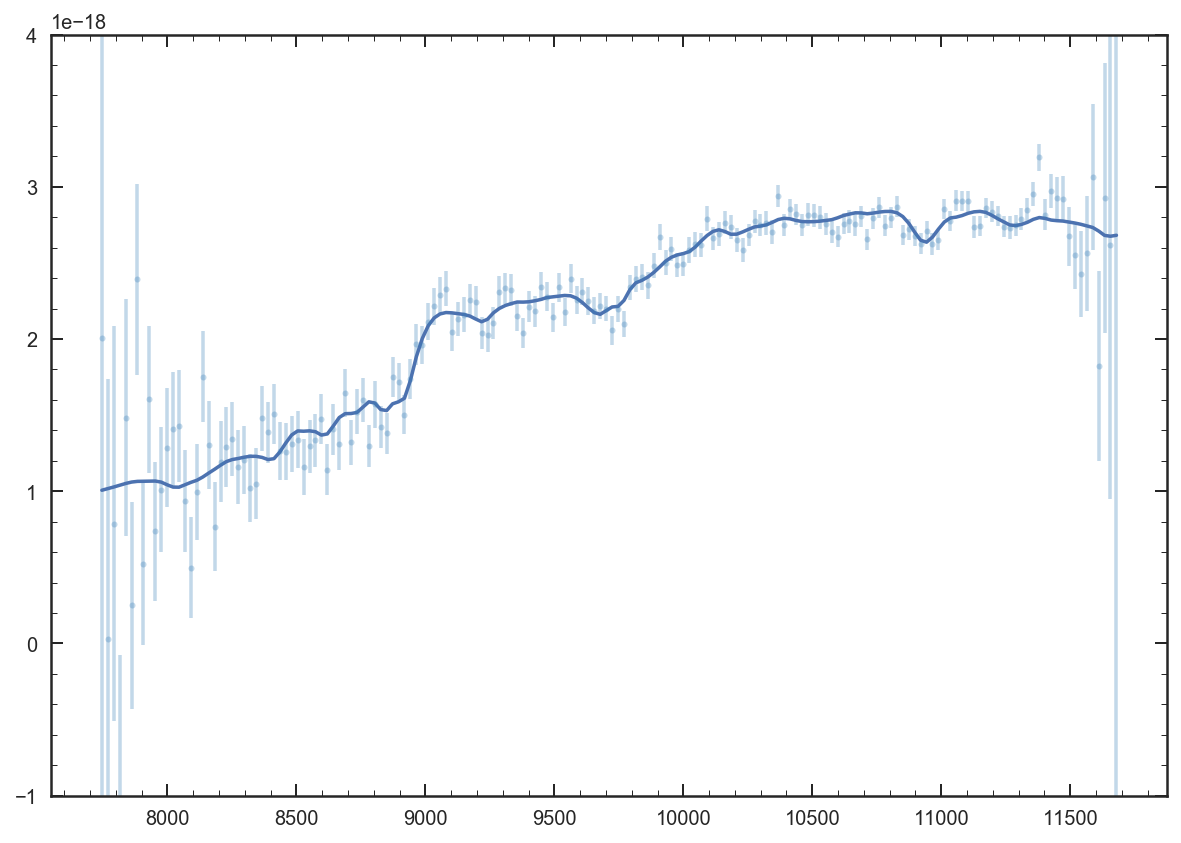

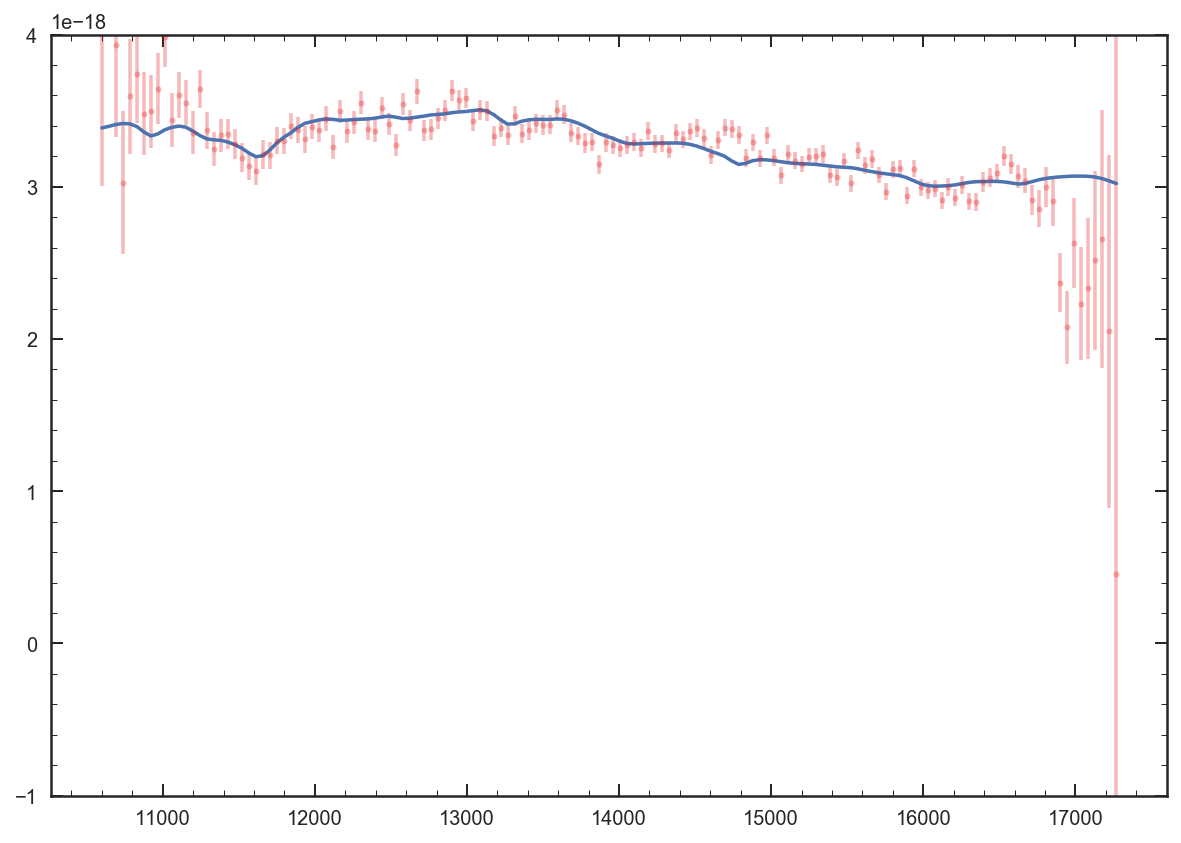

In [5]:
gs.Sim_all(0.008, 4.37, 0.491, 1.2415, 0.175)
plt.figure(figsize=[10,7])
plt.errorbar(np.log10(gs.Pwv), gs.Pflx, gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(gs.Pwv), gs.Pmfl,'ko')

plt.ylim(-1E-18,4E-18)

gs.Sim_all(0.0095, 4.0, 0.522, 1.2525, 0.375)
plt.figure(figsize=[10,7])
plt.errorbar(gs.Bwv, gs.Bfl, gs.Ber,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.plot(gs.Bwv, gs.Bmfl)

plt.ylim(-1E-18,4E-18)

gs.Sim_all(0.0035, 6.19, 0.01, 1.2575, 0.05)
plt.figure(figsize=[10,7])
plt.errorbar(gs.Rwv, gs.Rfl, gs.Rer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.plot(gs.Rwv, gs.Rmfl)


plt.ylim(-1E-18,4E-18)

In [3]:
gs.Scale_flux(0.0028, 7.19, 0.725, 1.227, 0.4)


<ErrorbarContainer object of 3 artists>

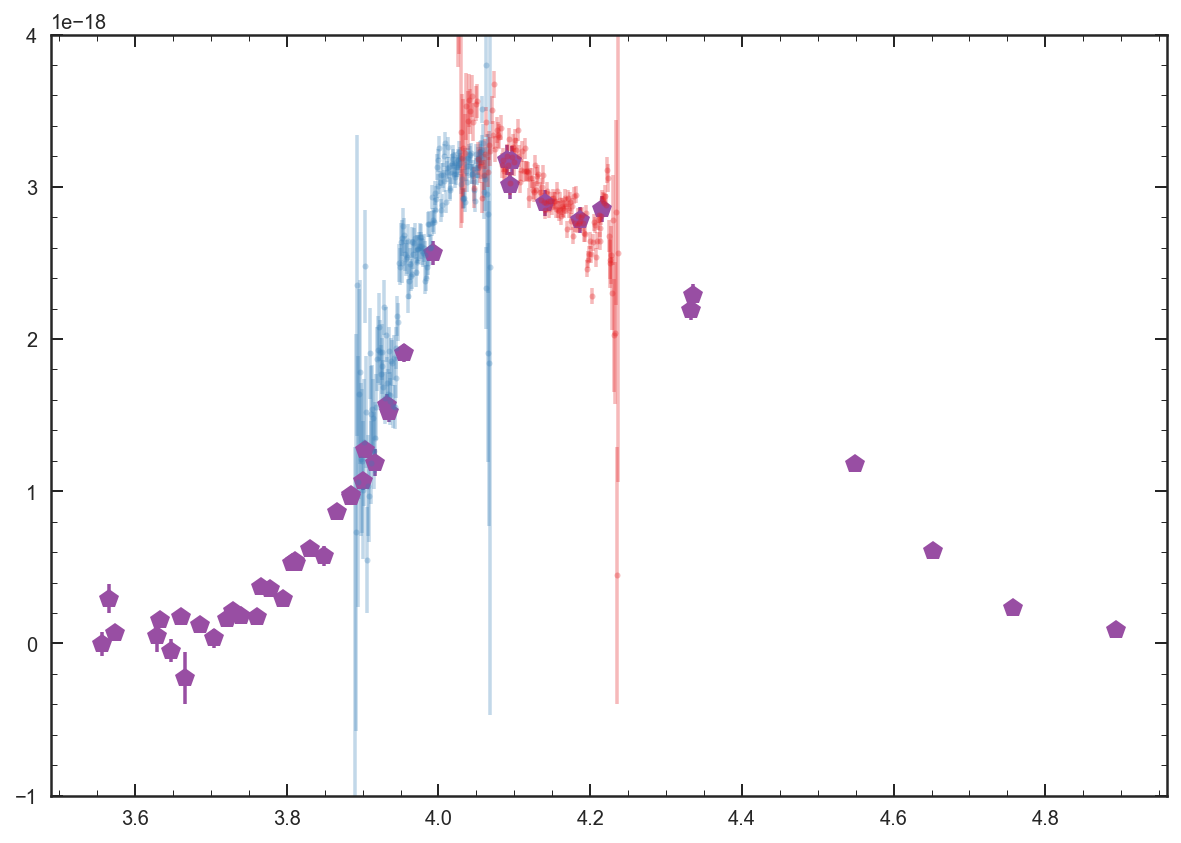

In [11]:
plt.figure(figsize=[10,7])
plt.errorbar(np.log10(gs.Pwv), gs.Pflx, gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')

plt.ylim(-1E-18,4E-18)

plt.errorbar(np.log10(gs.Bwv), gs.Bfl*1.15, gs.Ber,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)

plt.errorbar(np.log10(gs.Rwv), gs.Rfl, gs.Rer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)


/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:214: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:216: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:223: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:225: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


(-0.1, 0.5)

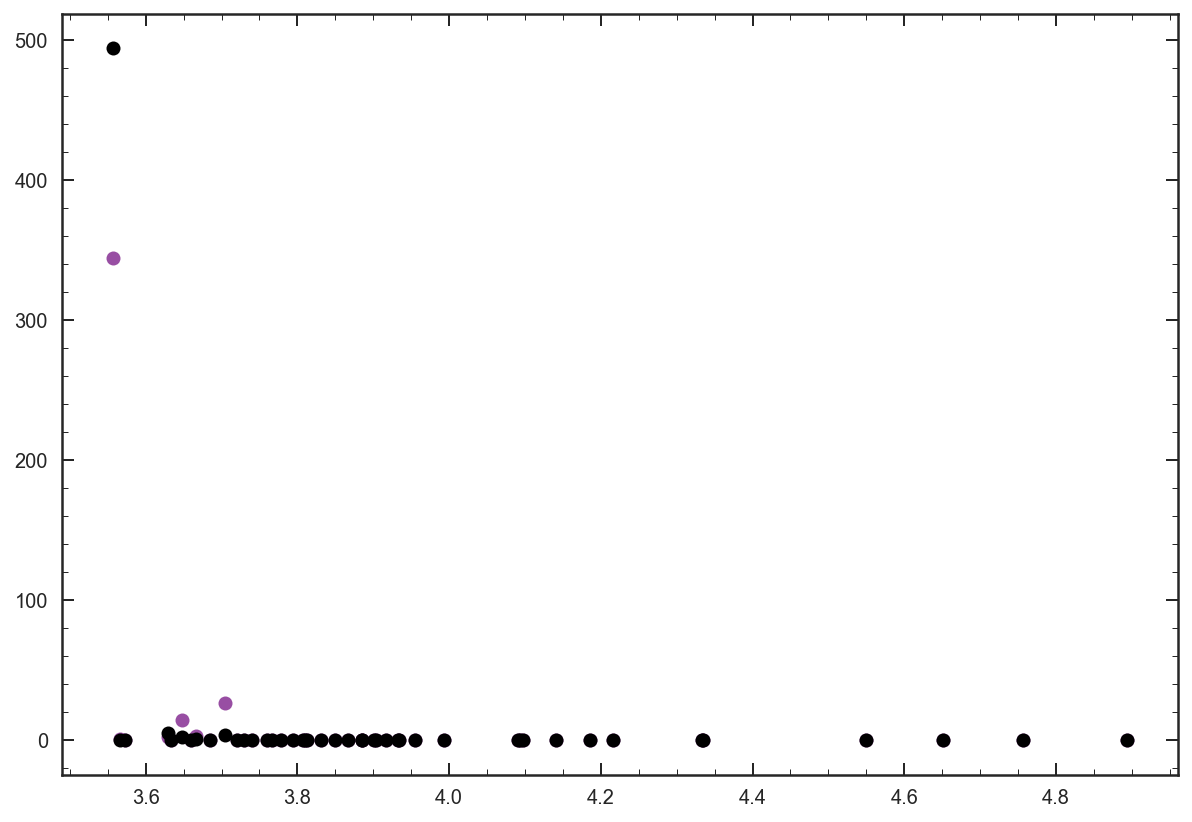

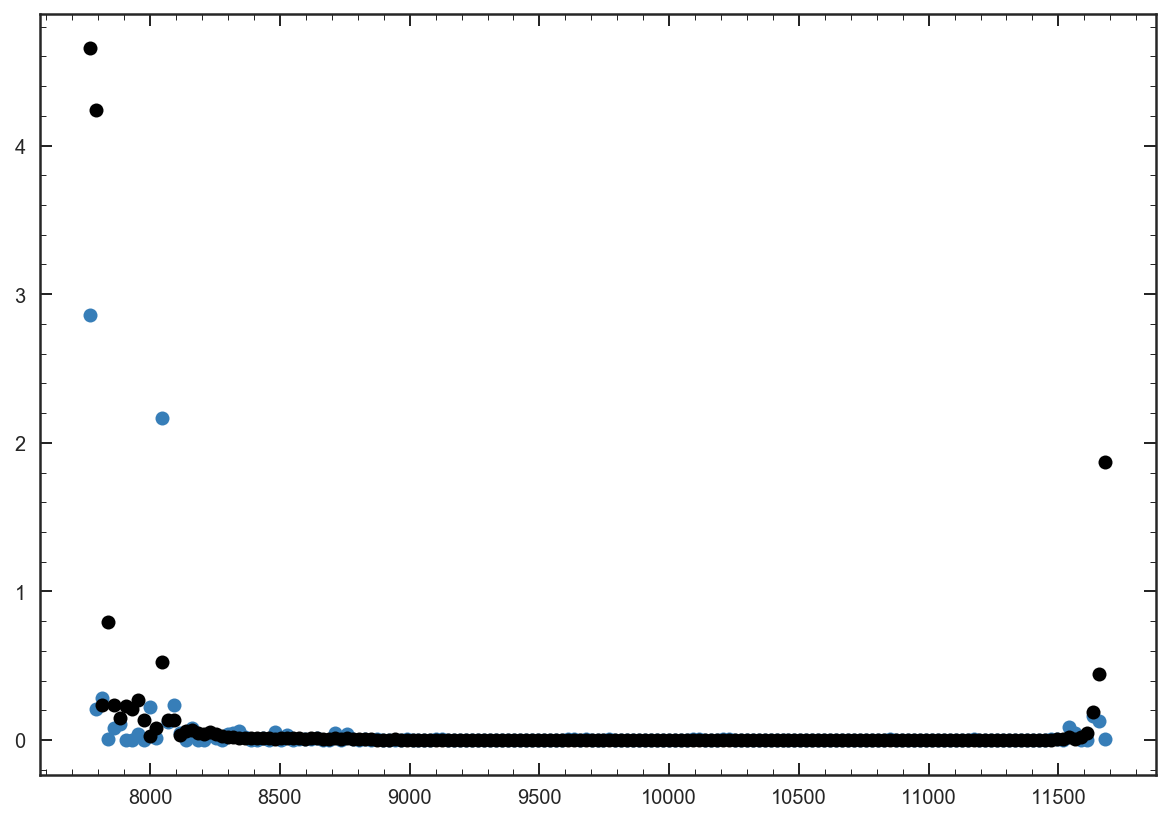

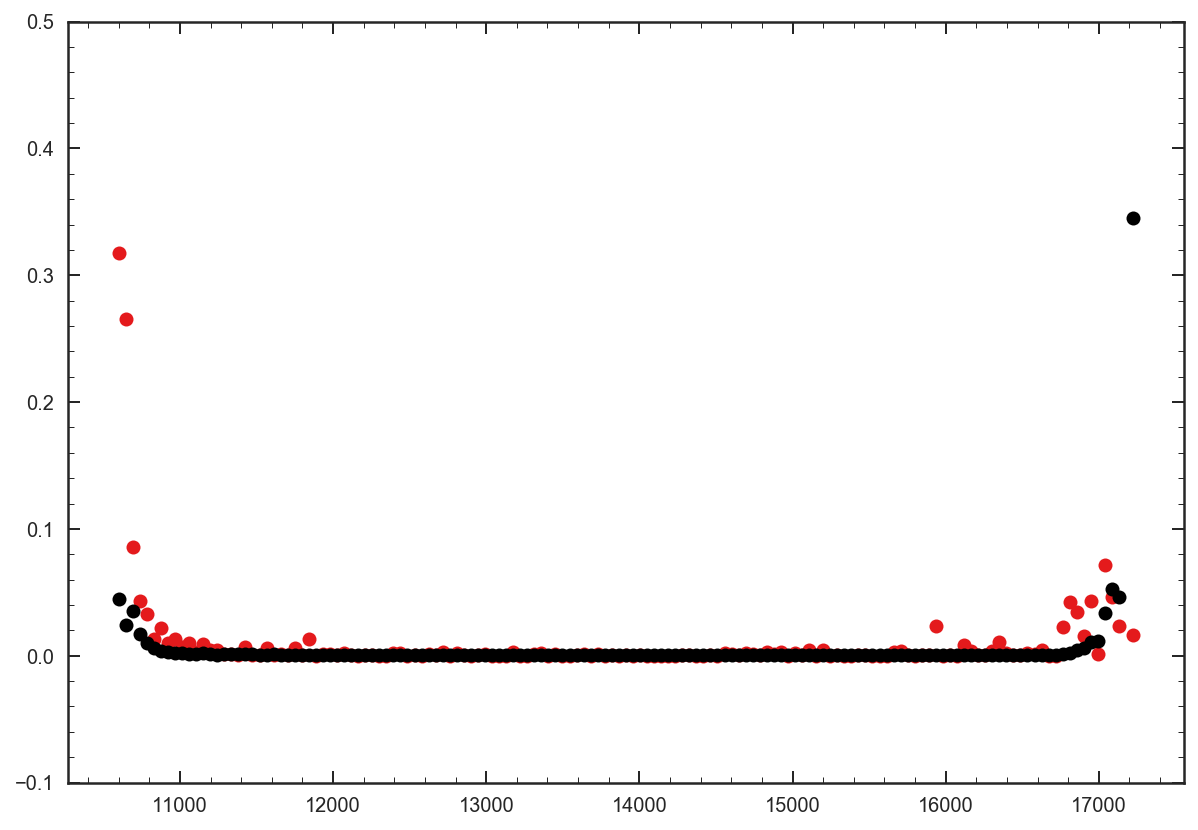

In [22]:
gs.sp.params['logzsol'] = np.log10(0.0028 / 0.019)
gs.sp.params['tau'] = 0.725
model_wave,model_flux = gs.sp.get_spectrum(tage = 7.19, peraa = True)

# [Bmw, Bmf], [Rmw, Rmf] = gs.Sim_spec_mult(model_wave * (1 + model_redshift), 
#                                             model_flux * Salmon(Av,model_wave))

Pmfl = gs.Sim_phot_mult(model_wave * (1 + 1.227), 
                                                  model_flux * Salmon(0.4,model_wave))

C = Scale_model(gs.Pflx, gs.Perr, Pmfl)
plt.figure(figsize=[10,7])
plt.plot(np.log10(gs.Pwv), ((gs.Pflx - C*Pmfl) / gs.Pflx)**2, 'o', color='#984ea3')
plt.plot(np.log10(gs.Pwv), ((gs.Perr)/gs.Pflx)**2, 'ko')

gs.sp.params['logzsol'] = np.log10(0.0305 / 0.019)
gs.sp.params['tau'] = 0.955
model_wave,model_flux = gs.sp.get_spectrum(tage = 5.52, peraa = True)

[Bmw, Bmfl], [xx, xx] = gs.Sim_spec_mult(model_wave * (1 + 1.221), 
                                            model_flux * Salmon(0,model_wave))

iBmfl = interp1d(Bmw, Bmfl)(gs.Bwv)
C = Scale_model(gs.Bflx, gs.Berr, iBmfl)

plt.figure(figsize=[10,7])
plt.plot(gs.Bwv, ((gs.Bflx-C*iBmfl) / gs.Bflx)**2,'o', color='#377eb8')
plt.plot(gs.Bwv, ((gs.Berr)/gs.Bflx)**2, 'ko')


gs.sp.params['logzsol'] = np.log10(0.0125 / 0.019)
gs.sp.params['tau'] = 0.019
model_wave,model_flux = gs.sp.get_spectrum(tage = 1.27, peraa = True)

[xx, xx], [Rmw, Rmfl] = gs.Sim_spec_mult(model_wave * (1 + 1.2185), 
                                            model_flux * Salmon(0,model_wave))

iRmfl = interp1d(Rmw, Rmfl)(gs.Rwv)
C = Scale_model(gs.Rflx, gs.Rerr, iRmfl)

plt.figure(figsize=[10,7])
plt.plot(gs.Rwv, ((gs.Rflx-C*iRmfl)/gs.Rflx)**2, 'o', color='#e41a1c')
plt.plot(gs.Rwv, ((gs.Rerr)/gs.Rflx)**2, 'ko')
plt.ylim(-.1,.5)

In [49]:
gs = Gen_spec('GSD',40597,1.221, '../beams/o149.0_40597.g102.A.fits', '../beams/o185.0_40597.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],
              tmp_err=False, phot_errterm=0.03)  


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [50]:
gs.Sim_all(0.019, 2.5, 0.1, 1.221, 0.2)

<ErrorbarContainer object of 3 artists>

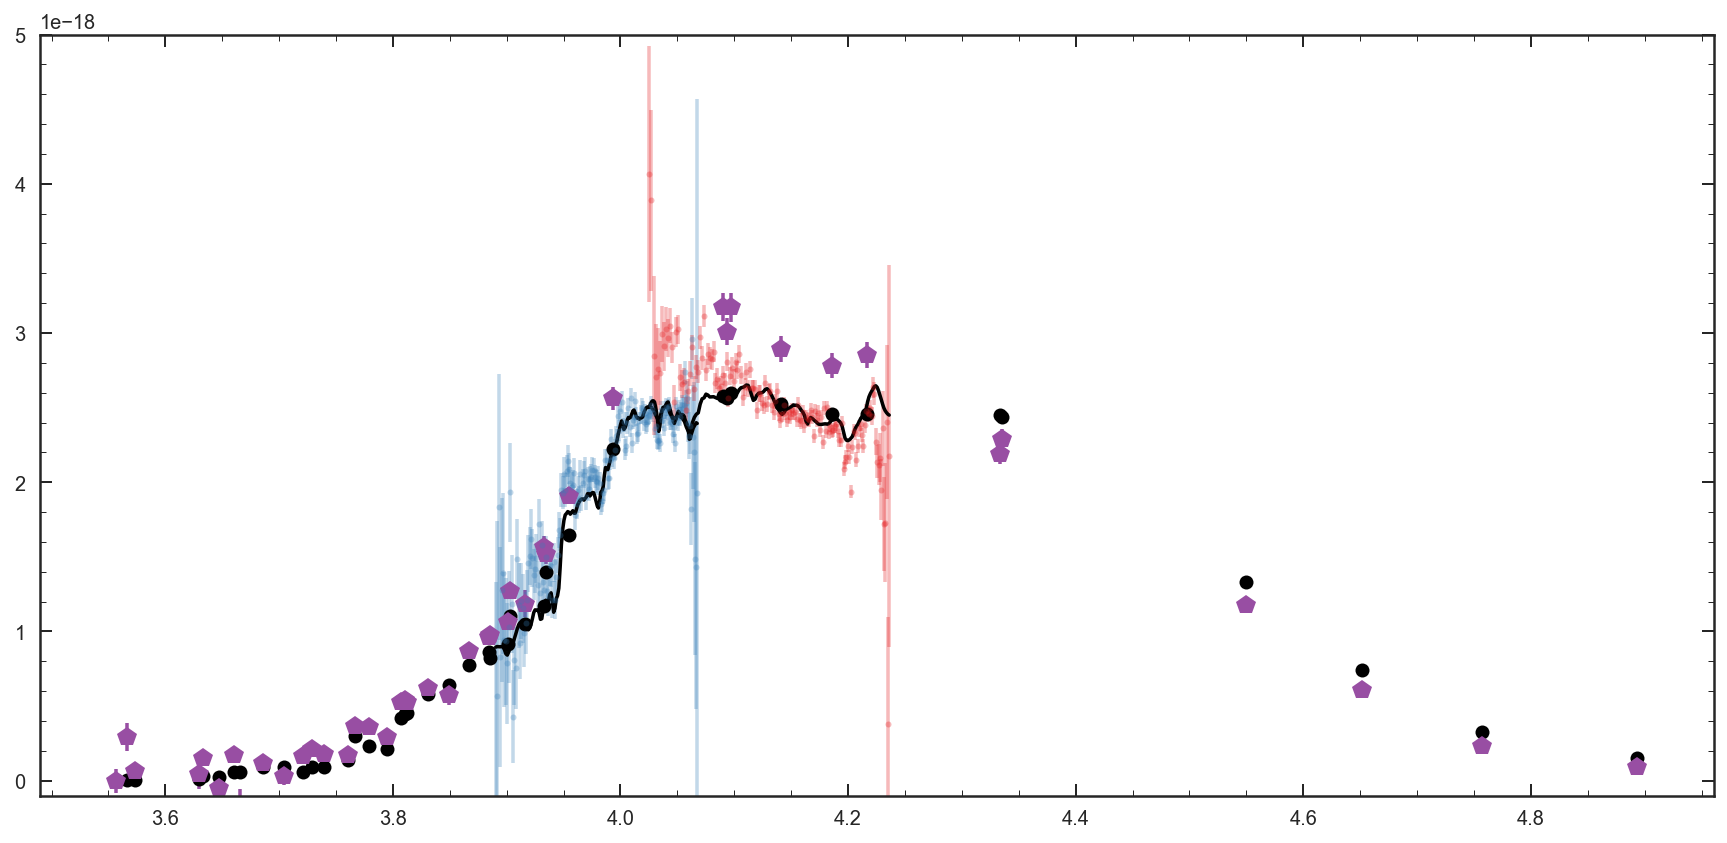

In [51]:
plt.figure(figsize=[15,7])
plt.errorbar(np.log10(gs.Pwv), gs.Pflx, gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')

plt.ylim(-.1E-18,5E-18)

plt.errorbar(np.log10(gs.Bwv), gs.Bfl, gs.Ber,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.plot(np.log10(gs.Bwv), gs.Bmfl,'k')
plt.plot(np.log10(gs.Rwv), gs.Rmfl,'k')
plt.plot(np.log10(gs.Pwv), gs.Pmfl,'ko')

plt.errorbar(np.log10(gs.Rwv), gs.Rfl, gs.Rer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)


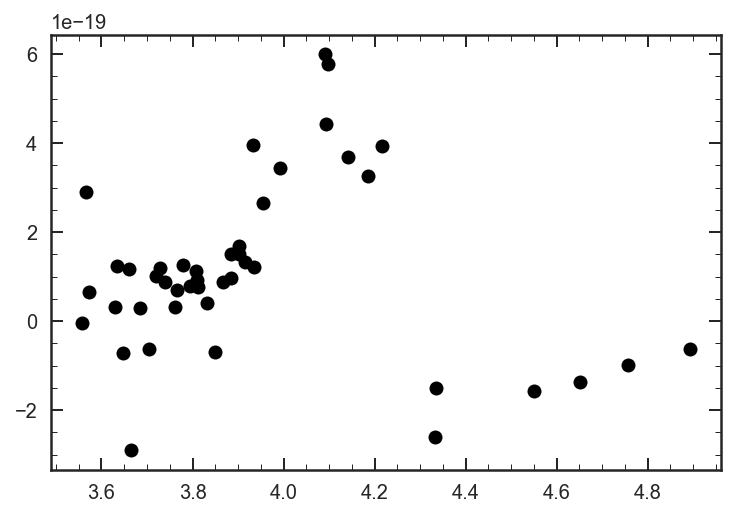

In [52]:
plt.plot(np.log10(gs.Pwv),gs.Pflx- gs.Pmfl,'ko')


<ErrorbarContainer object of 3 artists>

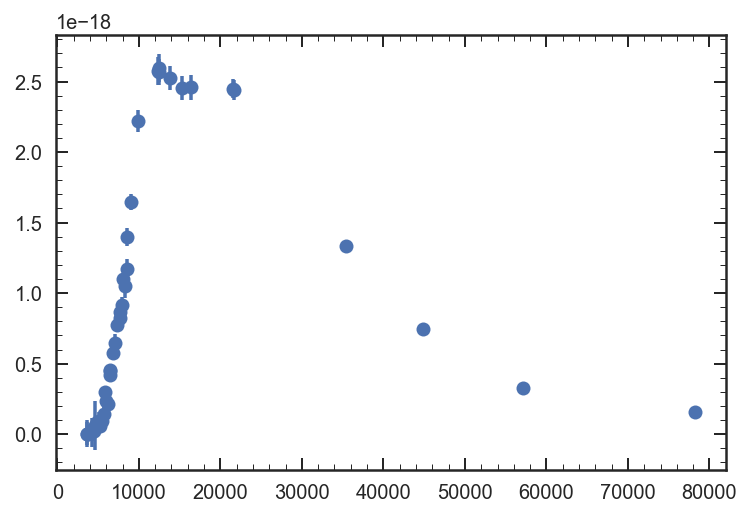

In [11]:
plt.errorbar(gs.Pwv,gs.SPflx, gs.SPerr,fmt='o')

In [9]:
v0z0,v0Pz0 = np.load('../data/tmp/test_fitz_0_v0.npy')
v0z1,v0Pz1 = np.load('../data/tmp/test_fitz_1_v0.npy')
v0z2,v0Pz2 = np.load('../data/tmp/test_fitz_2_v0.npy')
v0z3,v0Pz3 = np.load('../data/tmp/test_fitz_3_v0.npy')

v1z0,v1Pz0 = np.load('../data/tmp/test_fitz_0_v1.npy')
v1z1,v1Pz1 = np.load('../data/tmp/test_fitz_1_v1.npy')
v1z2,v1Pz2 = np.load('../data/tmp/test_fitz_2_v1.npy')
v1z3,v1Pz3 = np.load('../data/tmp/test_fitz_3_v1.npy')

v2z0,v2Pz0 = np.load('../data/tmp/test_fitz_0_v2.npy')
v2z1,v2Pz1 = np.load('../data/tmp/test_fitz_1_v2.npy')
v2z2,v2Pz2 = np.load('../data/tmp/test_fitz_2_v2.npy')
v2z3,v2Pz3 = np.load('../data/tmp/test_fitz_3_v2.npy')

v3z0,v3Pz0 = np.load('../data/tmp/test_fitz_0_v3.npy')
v3z1,v3Pz1 = np.load('../data/tmp/test_fitz_1_v3.npy')
v3z2,v3Pz2 = np.load('../data/tmp/test_fitz_2_v3.npy')
v3z3,v3Pz3 = np.load('../data/tmp/test_fitz_3_v3.npy')

(1.24, 1.26)

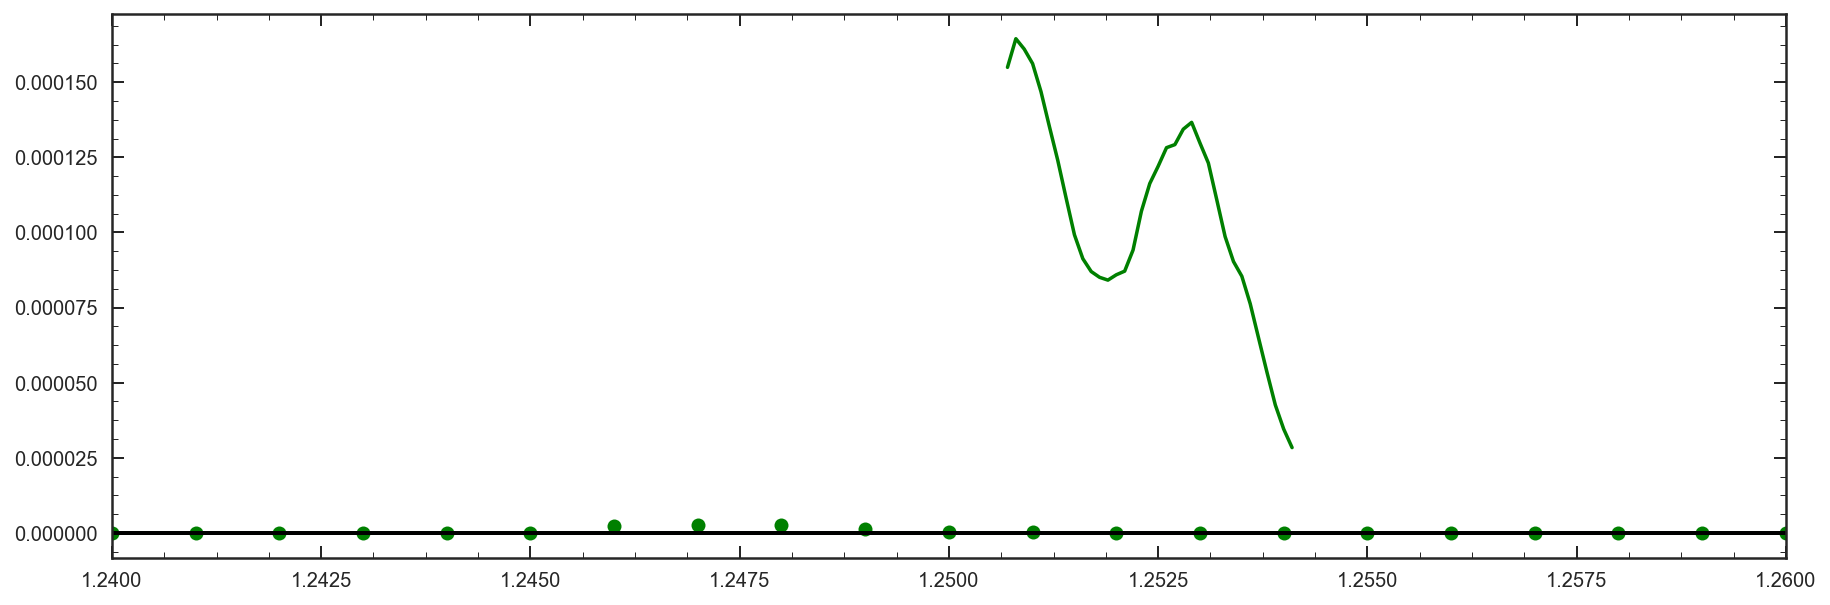

In [36]:
plt.figure(figsize=[15,5])
plt.plot(v0z0,v0Pz0,'b')
plt.plot(v0z1,v0Pz1,'b')
plt.plot(v0z2,v0Pz2,'b')
plt.plot(v0z3,v0Pz3,'b')

plt.plot(v1z0,v1Pz0,'r')
plt.plot(v1z1,v1Pz1,'r')
plt.plot(v1z2,v1Pz2,'r')
plt.plot(v1z3,v1Pz3,'r')

plt.plot(v2z0,v2Pz0,'g')
plt.plot(v2z1,v2Pz1,'g')
plt.plot(v2z2,v2Pz2,'go')
plt.plot(v2z3,v2Pz3,'g')
# 
plt.plot(v3z0,v3Pz0,'k')
plt.plot(v3z1,v3Pz1,'k')
plt.plot(v3z2,v3Pz2,'k')
plt.plot(v3z3,v3Pz3,'k')
plt.xlim(1.24,1.26)

In [9]:
g102_beam = glob( '../beams/*{0}*g102*'.format(44042))
g141_beam = glob('../beams/*{0}*g141*'.format(44042))


if len(g102_beam) < 1:
    idx = 0
    for g2 in g141_beam:
        print(g2)

if len(g141_beam) < 1:
    idx = 0
    for g1 in g102_beam:
        print(g1)
    
if len(g102_beam) > 1 and len(g141_beam) > 1:   
    idx = 0
    for g1 in g102_beam:
        for g2 in g141_beam:
            print(g1,g2)
    

../beams/o128.0_44042.g102.A.fits ../beams/o185.0_44042.g141.A.fits
../beams/o128.0_44042.g102.A.fits ../beams/o86.0_44042.g141.A.fits
../beams/o149.0_44042.g102.A.fits ../beams/o185.0_44042.g141.A.fits
../beams/o149.0_44042.g102.A.fits ../beams/o86.0_44042.g141.A.fits
../beams/o171.0_44042.g102.A.fits ../beams/o185.0_44042.g141.A.fits
../beams/o171.0_44042.g102.A.fits ../beams/o86.0_44042.g141.A.fits


In [31]:
hrz = np.append(np.append(np.append(z0,z1),z2),z3)

hrz = np.sort(hrz)

nPz0, nPz1, nPz2, nPz3 = np.ones([4, len(hrz)])

iPz0 = interp1d(z0,Pz0/ max(Pz3))
iPz1 = interp1d(z1,Pz1/ max(Pz3))
iPz2 = interp1d(z2,Pz2/ max(Pz3))
iPz3 = interp1d(z3,Pz3/ max(Pz3))

for i in range(len(hrz)):
    if z0[0] <= hrz[i] <= z0[-1]:
        nPz0[i] = iPz0(hrz[i])
    
    if z1[0] <= hrz[i] <= z1[-1]:
        nPz1[i] = iPz1(hrz[i])
        
    if z2[0] <= hrz[i] <= z2[-1]:
        nPz2[i] = iPz2(hrz[i])
        
    if z3[0] <= hrz[i] <= z3[-1]:
        nPz3[i] = iPz3(hrz[i])

Pz = nPz0 * nPz1 * nPz2 * nPz3 
Pz /= np.trapz(Pz,hrz)

[0.9369]


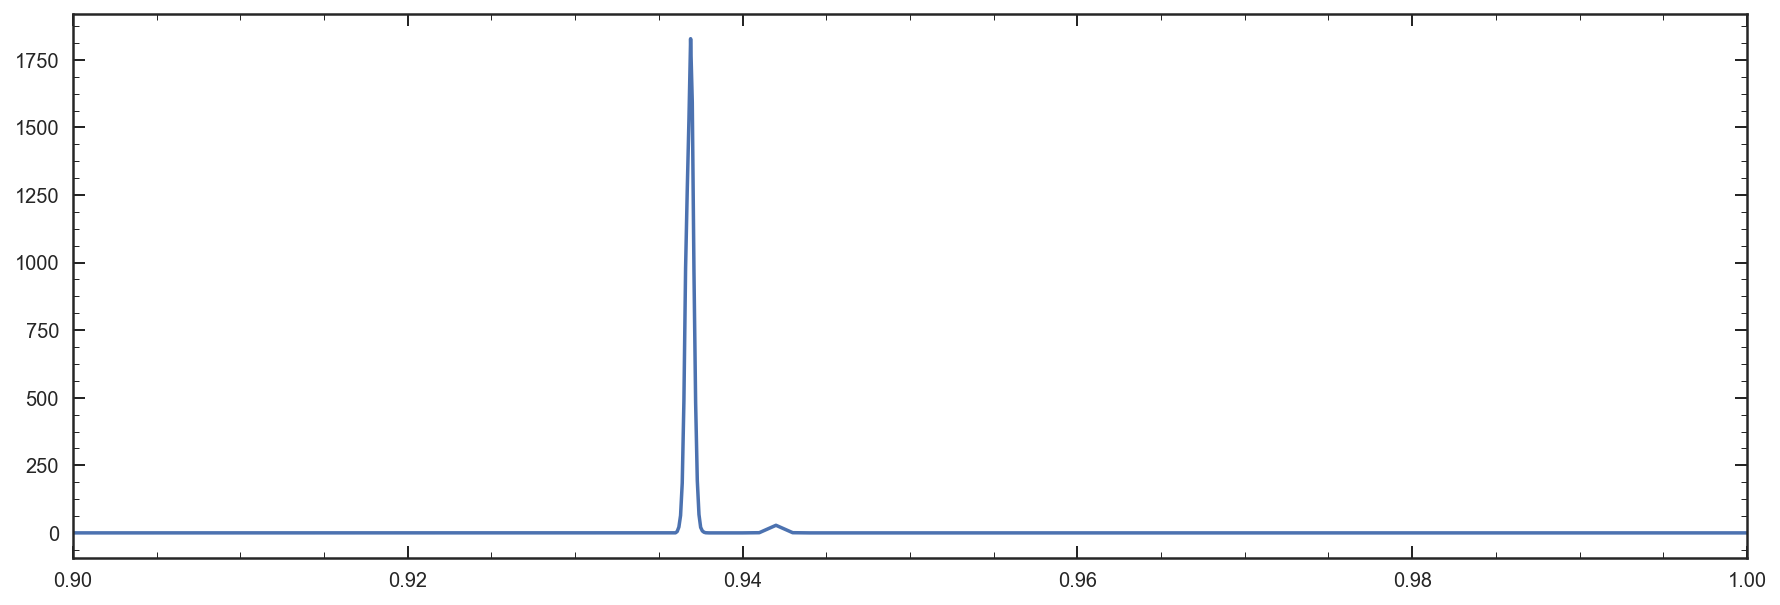

In [34]:
plt.figure(figsize=[15,5])
# plt.plot(z0,Pz0/np.trapz(Pz0,z0))
# plt.plot(z1,Pz1/np.trapz(Pz1,z1))
# plt.plot(z2,Pz2/np.trapz(Pz2,z2))
# plt.plot(z3,Pz3/np.trapz(Pz3,z3))
plt.plot(hrz,Pz)
plt.xlim(0.9,1)
print(hrz[Pz == np.max(Pz)])

In [84]:
v0z,v0Pz = np.load('../data/posteriors/GND_21156_v0_Pofz.npy')

v1z,v1Pz = np.load('../data/posteriors/GND_21156_v1_Pofz.npy')

v2z,v2Pz = np.load('../data/posteriors/GND_21156_v2_Pofz.npy')

v3z,v3Pz = np.load('../data/posteriors/GND_21156_v3_Pofz.npy')


(1.25, 1.262)

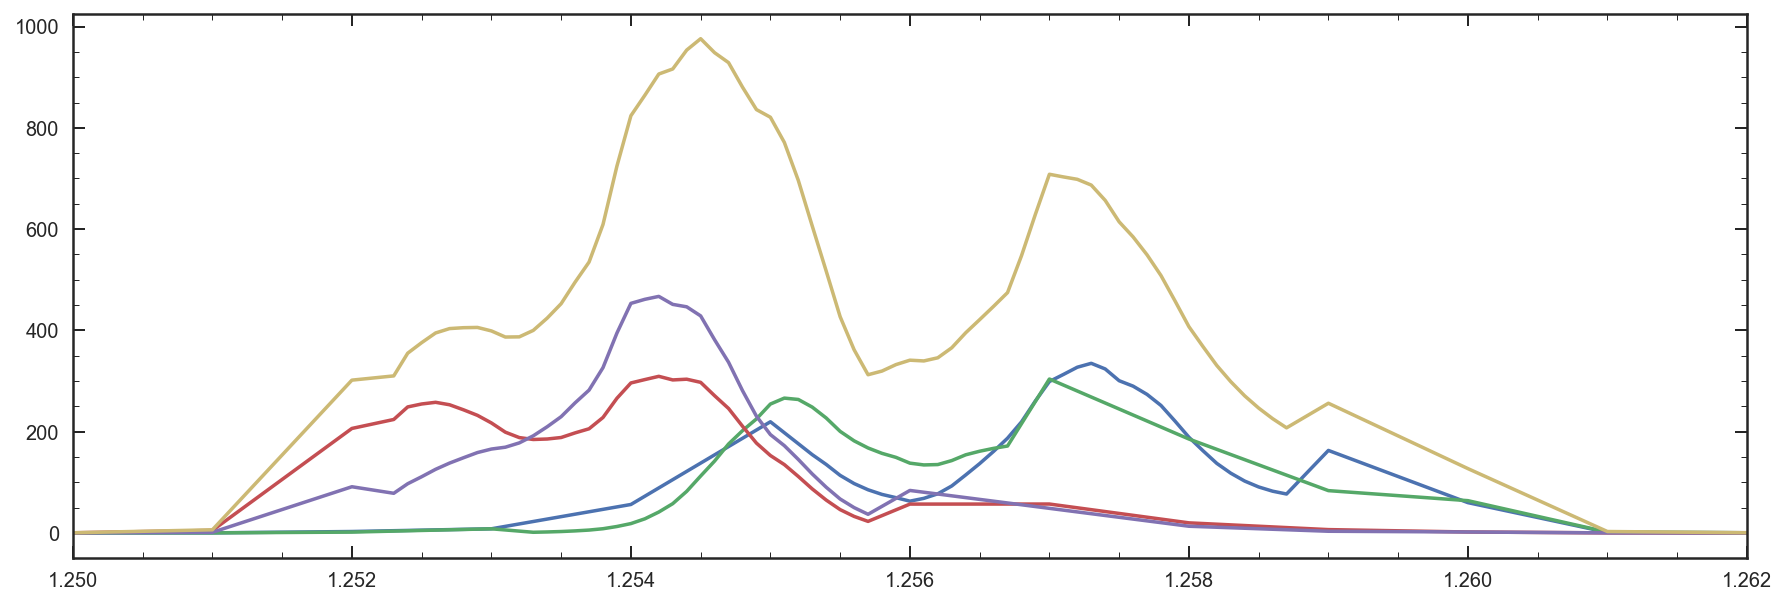

In [90]:
plt.figure(figsize=[15,5])
plt.plot(v0z,v0Pz)
plt.plot(v1z,v1Pz)
plt.plot(v2z,v2Pz)
plt.plot(v3z,v3Pz)
plt.plot(hrz, iv0Pz + iv1Pz + iv2Pz + iv3Pz)
plt.xlim(1.25,1.262)

In [89]:
hrz = np.arange(v0z[0],v0z[-1],0.0001)
iv0Pz = interp1d(v0z,v0Pz)(hrz)
iv1Pz = interp1d(v1z,v1Pz)(hrz)
iv2Pz = interp1d(v2z,v2Pz)(hrz)
iv3Pz = interp1d(v3z,v3Pz)(hrz)





(1.24, 1.26)

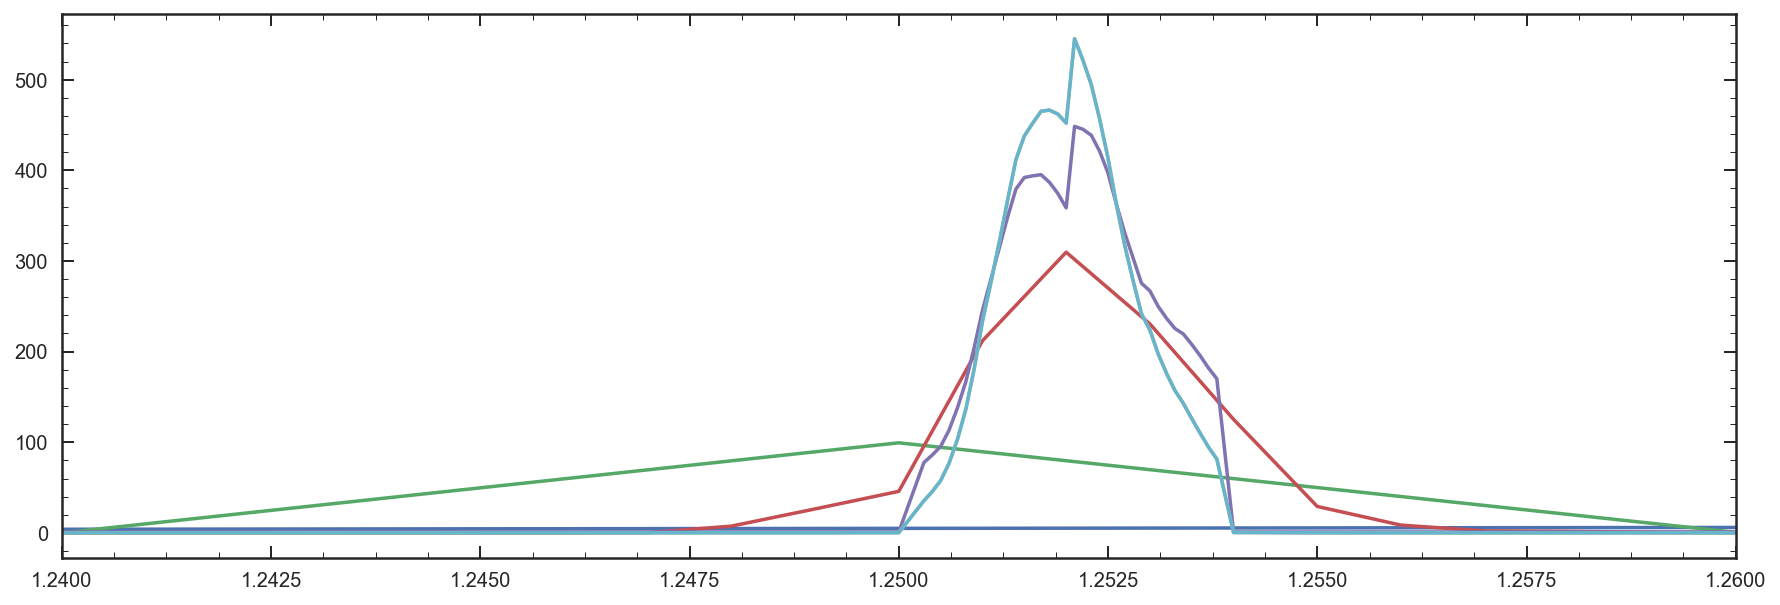

In [29]:
plt.figure(figsize=[15,5])
plt.plot(hrz,nPz0)
plt.plot(hrz,nPz1)
plt.plot(hrz,nPz2)
plt.plot(hrz,nPz3)
plt.plot(hrz,Pz)
plt.plot(hrz,Pztest)

plt.xlim(1.24,1.26)

[1.2524]


NameError: name 'out_path' is not defined

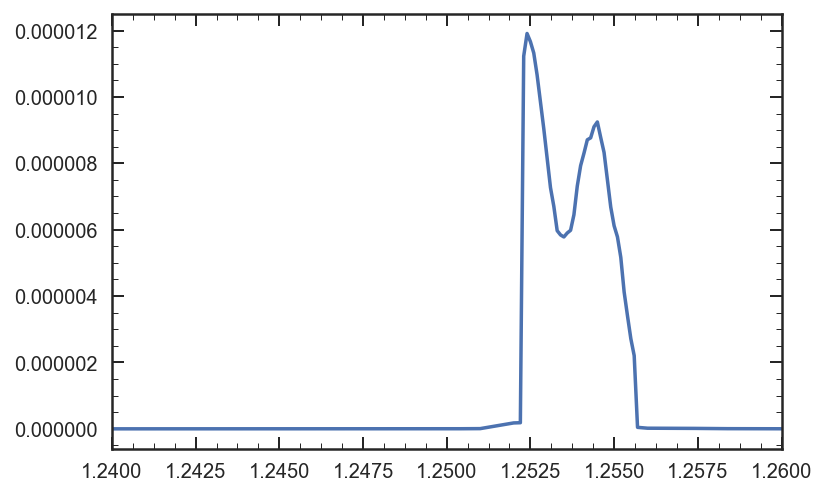

In [9]:
versions = len(glob('../data/tmp/test_chi_*')) // 4

# get true minimum
MIN = 1E18
for i in range(versions):
    for ii in range(4):
        chi = np.load('../data/tmp/test_chi_{0}_v{1}.npy'.format(ii,i))
        if np.min(chi) < MIN:
            MIN = np.min(chi)
        
# rederive P(z)s
for i in range(versions):
    bfm,bfa,bfz = np.load('../data/tmp/best_fits_v{0}.npy'.format(i))
    bfz = np.append([1],bfz)
    for ii in range(4):
        mdist, adist, tdist, zdist, ddist = Set_rshift_params(bfm[ii], bfa[ii], 1, bfz[ii], 1, ii)
        chi = np.load('../data/tmp/test_chi_{0}_v{1}.npy'.format(ii,i))
        PZ, Pt, Ptau, Pz, Pd =  Simple_analyze(chi, MIN, mdist, adist, tdist, zdist, ddist)
        np.save('../data/tmp/test_fitz_{0}_v{1}'.format(ii,i), [zdist,Pz])


hrz = np.arange(0,3.4+0.0001,0.0001)

zgrid = np.zeros([4 * versions, len(hrz)])
wgrid = np.zeros(zgrid.shape)

for i in range(versions):
    for ii in range(4):
        z, Pz = np.load('../data/tmp/test_fitz_{0}_v{1}.npy'.format(ii,i))
        iPz = interp1d(z,Pz)
        for iii in range(len(hrz)):
            if z[0] <= hrz[iii] <= z[-1]:
                zgrid[i*4 + ii][iii] = iPz(hrz[iii])
                wgrid[i*4 + ii][iii] = 1                

pz_stack = np.zeros(len(hrz))
for i in range(len(hrz)):
    pz_stack[i] = np.sum(zgrid.T[i] * wgrid.T[i]) / (np.sum(wgrid.T[i]))


plt.plot(hrz,pz_stack)
plt.xlim(1.24,1.26)
print(hrz[pz_stack == max(pz_stack)])

# np.save(out_path + '{0}_{1}_v{2}_Pofz'.format(field, galaxy, mod), [hrz,Pz])


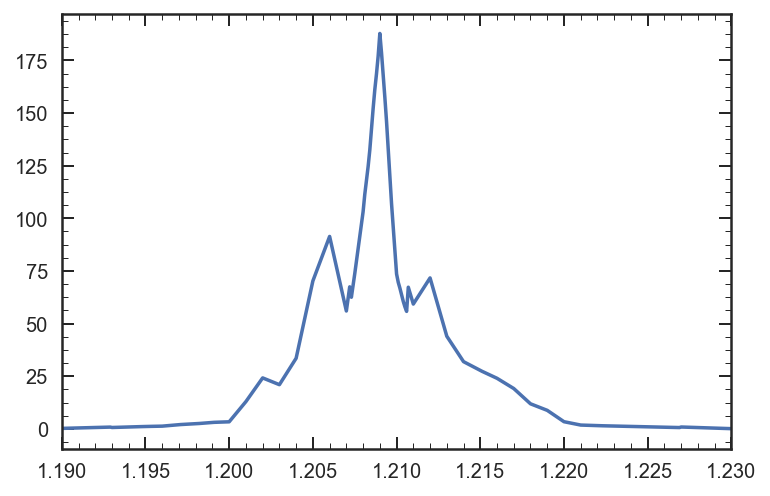

In [168]:
z,pz = np.load('../data/posteriors/GSD_47223_Pofz.npy')
plt.xlim(1.19,1.23)
plt.plot(z,pz)


In [14]:
os.path.isfile()

,id,snr
1,44042,19.966019
2,40476,18.111621
4,47140,35.971227
7,41520,16.791156
9,47691,22.072788
10,43615,23.931791
11,38513,14.375417
12,47223,43.658766
13,42113,23.681500
15,40597,44.892065


In [119]:
def Highest_density_region(Px, x, region = 0.68):
    resample_x = np.linspace(x[0],x[-1],1E6)
    iPx = interp1d(x,Px)(resample_x)

    border = max(Px)

    match = False

    while not match:
        top = np.array(iPx)
        top[top < border] = 0
        bottom = np.array(iPx)

        bottom[bottom >= border] = 0

        integral_size = np.trapz(top,resample_x)

        diff = integral_size - region

        if np.abs(diff) > 0.001:
            if diff < 0:
                border *= 0.99

            if diff > 0:
                border *= 1.01
        else:
            match = True

    rng = []
    for i in range(len(top)):
        if top[i] > 0:
            rng.append(resample_x[i])

    return resample_x[top == max(top)][0], resample_x[top == max(top)][0] - rng[0], rng[-1] - resample_x[top == max(top)][0]

In [169]:
md, ll, hl = Highest_density_region(pz,z)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


0.007840407840407737


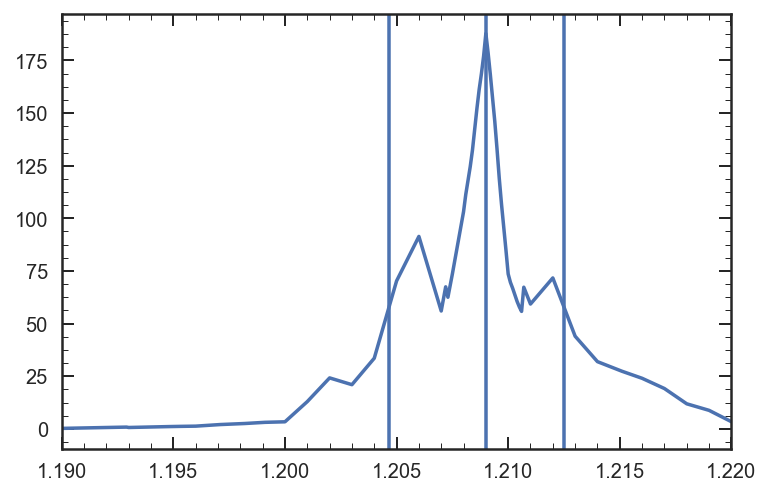

In [171]:
plt.plot(z,pz)
plt.xlim(1.19,1.22)
plt.axvline(md)
plt.axvline(md - ll)
plt.axvline(md + hl)
print(hl + ll)

In [13]:
all_temps = glob('../data/tmp/test*')
[os.remove(U) for U in all_temps]


[]


In [179]:
pzlist = glob('../data/posteriors/*Pofz*')

In [180]:
idx = 1
for i in gsd_cat.index:
    if not os.path.isfile('../data/posteriors/GSD_{0}_Pofz.npy'.format(gsd_cat.id[i])):
        print(gsd_cat.id[i],idx)
    idx += 1
    
for i in gnd_cat.index:
    if not os.path.isfile('../data/posteriors/GND_{0}_Pofz.npy'.format(gnd_cat.id[i])):
        print(gnd_cat.id[i],idx)
    idx += 1


44824 23
21724 63
32566 73
14158 79
16758 87
14746 93
21427 95
37343 101
33780 104
35831 105
12793 106
36348 107


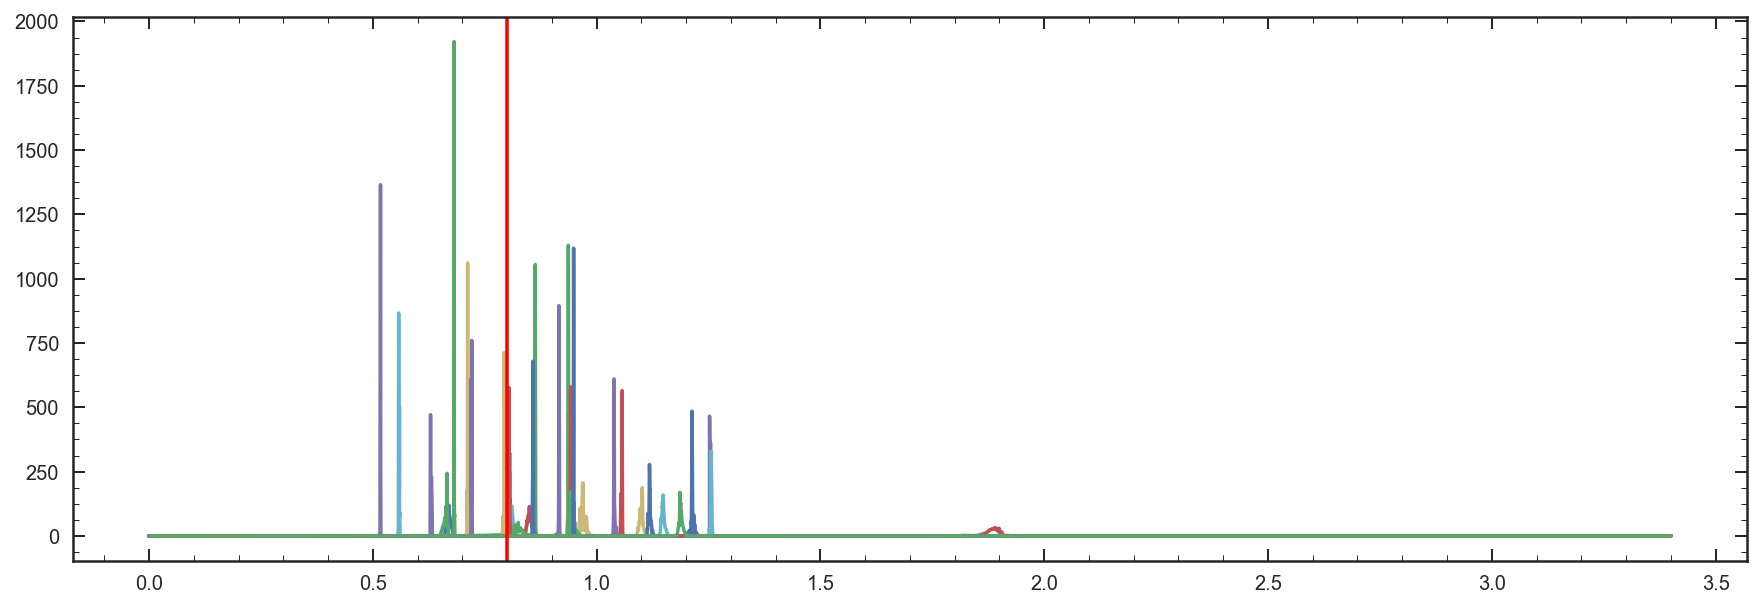

In [181]:
plt.figure(figsize=[15,5])
for i in pzlist:
#     nms = os.path.basename(i).split('_')
    z,pz = np.load(i)

    plt.plot(z,pz)#,'k')

plt.axvline(0.8,color='r')

In [177]:
pzs = glob('../data/posteriors/G*D_*_Pofz.npy')

md,ml,mh = np.zeros([3,len(pzs)])

for i in range(len(pzs)):
    z,pz = np.load(pzs[i])
    try:
        md[i],ml[i],mh[i] = Highest_density_region(pz,z)
    except:
        print('skipped ', pzs[i] )

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


skipped  ../data/posteriors/GND_21896_Pofz.npy
skipped  ../data/posteriors/GND_22774_Pofz.npy
skipped  ../data/posteriors/GND_27458_Pofz.npy
skipped  ../data/posteriors/GND_27714_Pofz.npy
skipped  ../data/posteriors/GND_27951_Pofz.npy
skipped  ../data/posteriors/GND_29664_Pofz.npy
skipped  ../data/posteriors/GND_32146_Pofz.npy
skipped  ../data/posteriors/GND_33453_Pofz.npy
skipped  ../data/posteriors/GND_34484_Pofz.npy
skipped  ../data/posteriors/GND_35069_Pofz.npy
skipped  ../data/posteriors/GND_36161_Pofz.npy
skipped  ../data/posteriors/GND_36303_Pofz.npy
skipped  ../data/posteriors/GND_36530_Pofz.npy
skipped  ../data/posteriors/GND_36838_Pofz.npy
skipped  ../data/posteriors/GND_36943_Pofz.npy
skipped  ../data/posteriors/GND_37180_Pofz.npy
skipped  ../data/posteriors/GND_37186_Pofz.npy
skipped  ../data/posteriors/GND_37210_Pofz.npy
skipped  ../data/posteriors/GND_37232_Pofz.npy
skipped  ../data/posteriors/GND_37686_Pofz.npy
skipped  ../data/posteriors/GND_37813_Pofz.npy
skipped  ../d

KeyboardInterrupt: 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


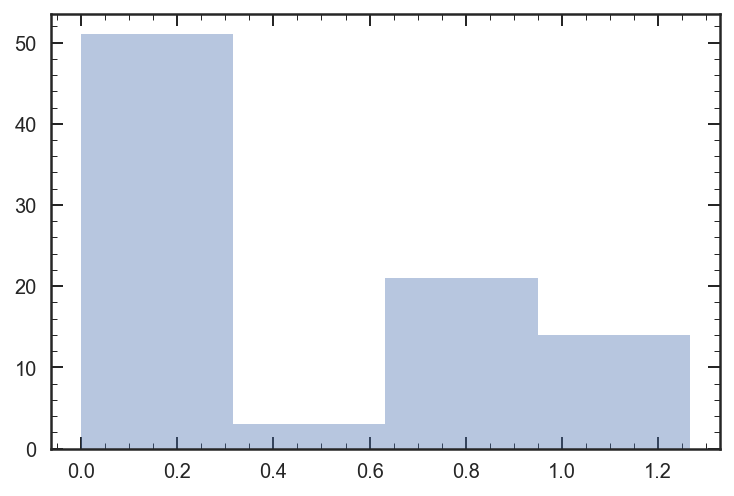

In [178]:
sea.distplot(md,kde=False)

In [2]:
S_v4 = pd.read_pickle('../dataframes/GS_v4.3_uvj.pkl')
N_v4 = pd.read_pickle('../dataframes/GN_v4.3_uvj.pkl')

S_zg = pd.read_pickle('../dataframes/GS_uvj_z_grism_v2.pkl')
N_zg = pd.read_pickle('../dataframes/GN_uvj_z_grism_v2.pkl')

In [8]:
v4z = []
vecz = []

for i in gsd_cat.index:
    z,pz = np.load('../data/posteriors/GSD_{0}_Pofz.npy'.format(gsd_cat.id[i]))
#     md_,ml_,mh_ = Median_w_Error_cont(pz,z)
    md_ = z[pz == max(pz)][0]
    vecz.append(md_)
    v4z.append(S_v4.z[S_v4.id == gsd_cat.id[i]].values[0])

        
# for i in gnd_cat.index:
#     z,pz = np.load('../data/posteriors/GND_{0}_Pofz.npy'.format(gnd_cat.id[i]))
#     md_,ml_,mh_ = Median_w_Error_cont(pz,z)
#     vecz.append(md_)
#     v4z.append(N_v4.z[N_v4.id == gnd_cat.id[i]].values[0])

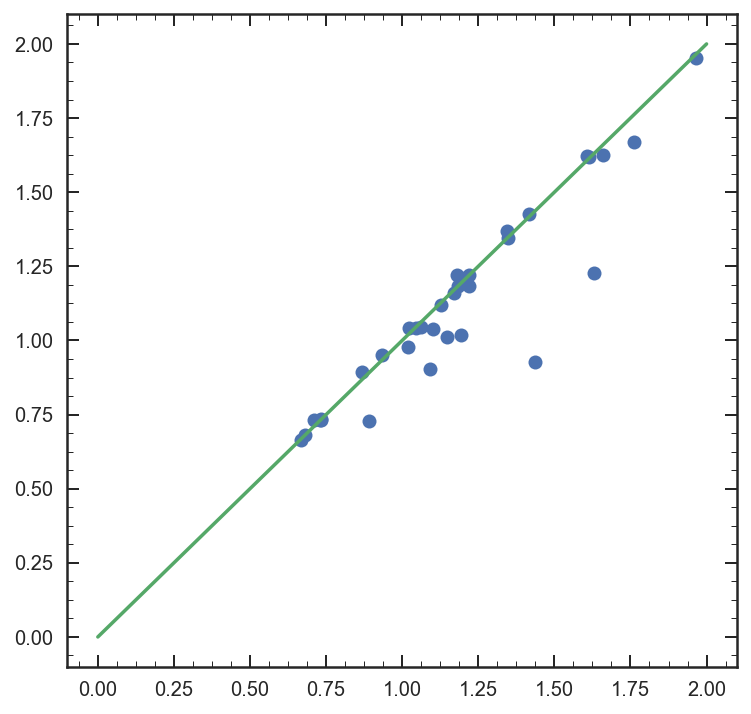

In [10]:
plt.figure(figsize=[6,6])
plt.plot(vecz,v4z,'o')
plt.plot([0,2],[0,2])

In [11]:
z50g = []
z16g = []
z84g = []


veczm = []
veczml = []
veczmh = []

for i in gsd_cat.index:
    z50g.append(S_zg.z50[S_zg.id == gsd_cat.id[i]].values[0])
    z16g.append(S_zg.z16[S_zg.id == gsd_cat.id[i]].values[0])
    z84g.append(S_zg.z84[S_zg.id == gsd_cat.id[i]].values[0])

    z,pz = np.load('../data/posteriors/GSD_{0}_Pofz.npy'.format(gsd_cat.id[i]))
#     md_,ml_,mh_ = Median_w_Error_cont(pz,z)
    md_ = z[pz == max(pz)][0]

    veczm.append(md_)
#     veczml.append(ml_)
#     veczmh.append(mh_)
        
# for i in gnd_cat.index:
#     z50g.append(N_zg.z50[N_zg.id == gnd_cat.id[i]].values[0])
#     z16g.append(N_zg.z16[N_zg.id == gnd_cat.id[i]].values[0])
#     z84g.append(N_zg.z84[N_zg.id == gnd_cat.id[i]].values[0])

#     z,pz = np.load('../data/posteriors/GND_{0}_Pofz.npy'.format(gnd_cat.id[i]))
#     md_,ml_,mh_ = Median_w_Error_cont(pz,z)
#     veczm.append(md_)
#     veczml.append(ml_)
#     veczmh.append(mh_)

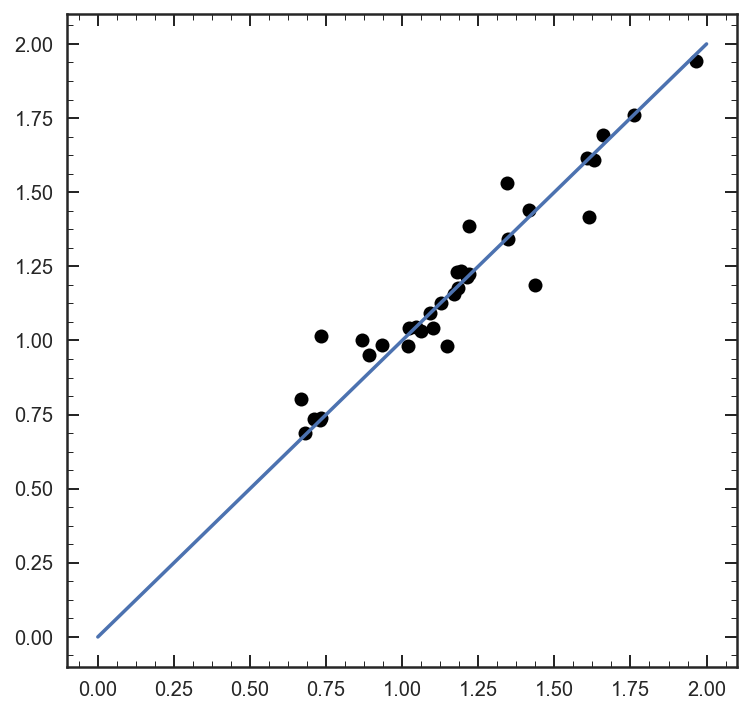

In [13]:
plt.figure(figsize=[6,6])
# plt.errorbar(veczm,z50g,[np.array(z50g)-np.array(z16g),np.array(z84g)-np.array(z50g)],
#              [veczml,veczmh],fmt = 'ko',alpha=0.3)
plt.plot(veczm,z50g,'ko')

# plt.plot(vecz,v4z,'ro')


plt.plot([0,2],[0,2])

In [2]:
gsd_cat = pd.read_pickle('../dataframes/GS_snr.pkl')
gnd_cat = pd.read_pickle('../dataframes/GN_snr.pkl')

In [6]:
Set_rshift_params(0.001,1,1,1,1,1)

(array([0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013]),
 array([-2, -1,  0,  1,  2,  3,  4]),
 array([0.01 , 0.042, 0.173, 0.721, 3.   ]),
 array([0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
        1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
        1.16, 1.17]),
 array([0. , 0.3, 0.6, 0.9]))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


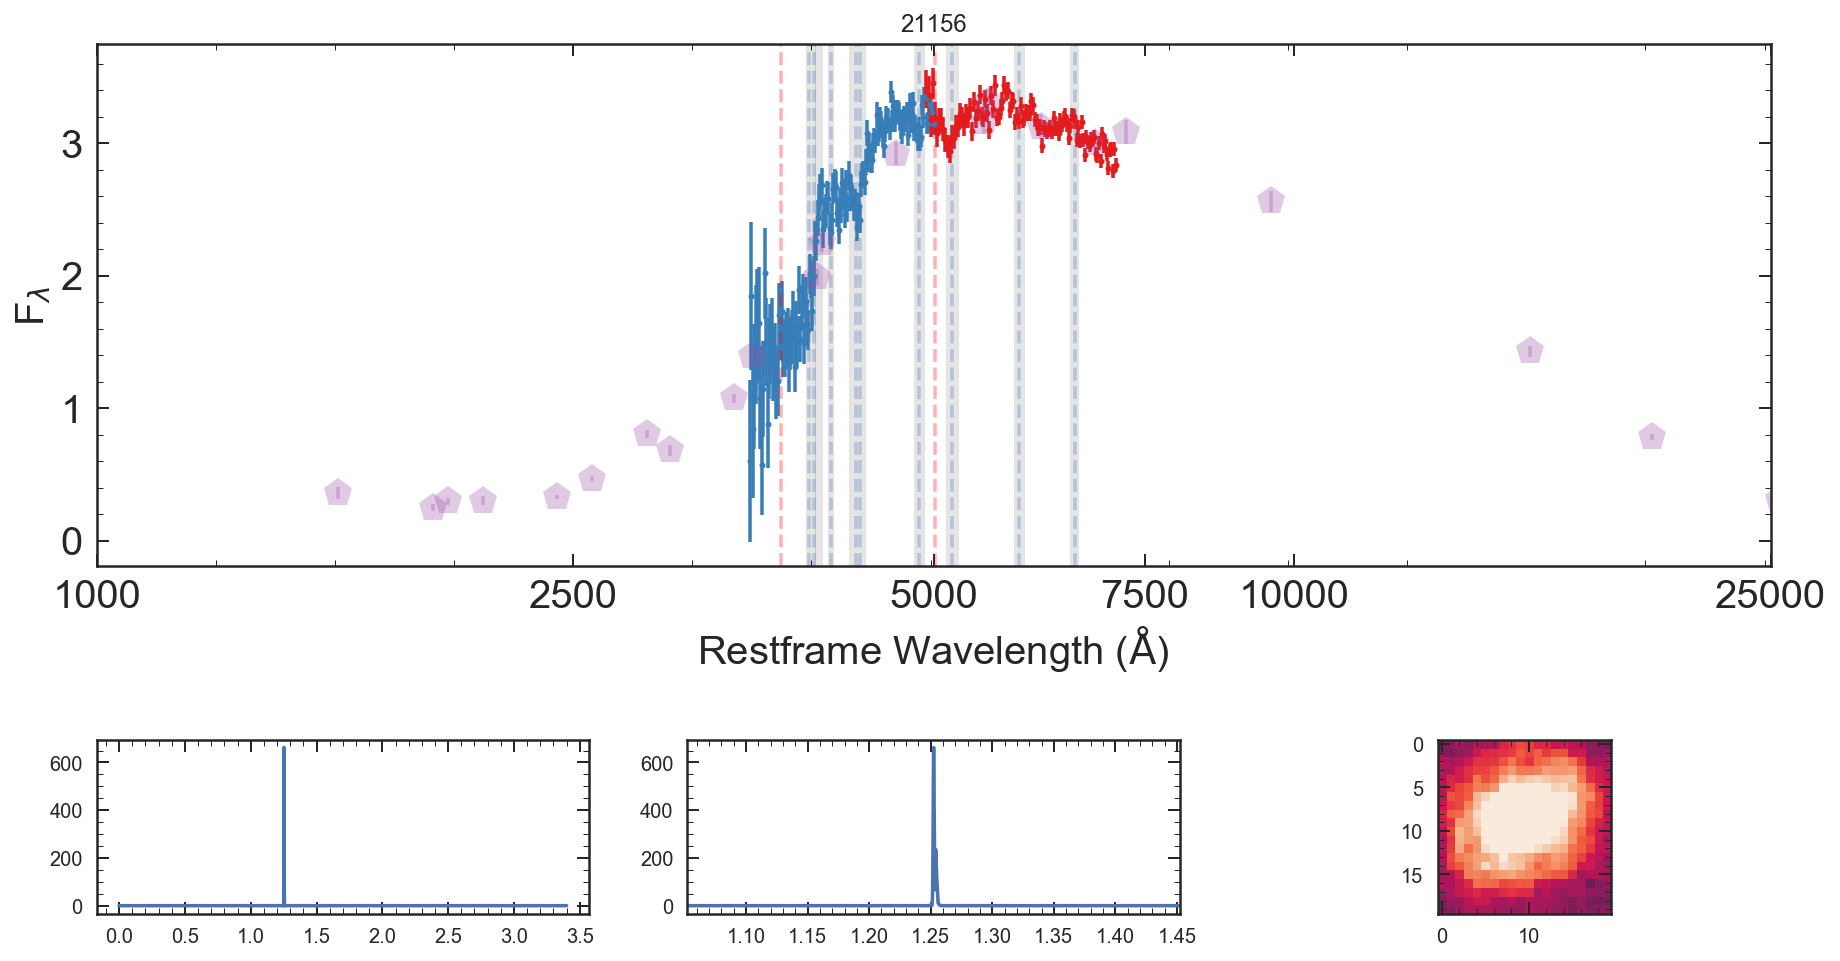

In [22]:
# for i in gnd_cat.index:
i = 34

try:
    g102_beam = glob('../beams/*{0}*g102*'.format(gnd_cat.id[i]))[0]
except:
    g102_beam = ''
try:
    g141_beam = glob('../beams/*{0}*g141*'.format(gnd_cat.id[i]))[0]
except:
    g141_beam = ''

z,pz = np.load('../data/posteriors/GND_{0}_Pofz.npy'.format(gnd_cat.id[i]))
# md_,ml_,mh_ = Median_w_Error_cont(pz,z)
md_ = z[pz == max(pz)]
GS = Gen_spec('GND', gnd_cat.id[i], md_, g102_beam, g141_beam, tmp_err=False,phot_errterm = 0.03, decontam=False)

rshift = md_

gs = GridSpec(2,3, height_ratios=[3,1], hspace=0.5)

fig = plt.figure(figsize=[15,8])
plt.subplot(gs[0,:])
plt.errorbar(np.log10(GS.Pwv / (1+rshift)),GS.Pflx*1E18,GS.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', alpha=0.3)
if GS.g102:
    plt.errorbar(np.log10(GS.Bwv/ (1+rshift)),GS.Bfl*1E18,GS.Ber*1E18,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
if GS.g141:
    plt.errorbar(np.log10(GS.Rwv/ (1+rshift)),GS.Rfl*1E18,GS.Rer*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.axvline(np.log10(3934.777),linestyle='--', alpha=.3)
plt.axvline(np.log10(3969.588),linestyle='--', alpha=.3)
plt.axvline(np.log10(4102.89),linestyle='--', alpha=.3)
plt.axvline(np.log10(4305.61),linestyle='--', alpha=.3)
plt.axvline(np.log10(4341.68),linestyle='--', alpha=.3)
plt.axvline(np.log10(4862.68),linestyle='--', alpha=.3)
plt.axvline(np.log10(5176.7),linestyle='--', alpha=.3)
plt.axvline(np.log10(5895.6),linestyle='--', alpha=.3)
plt.axvline(np.log10(6564),linestyle='--', alpha=.3)

plt.axvline(np.log10(3727.092),linestyle='--', color='r',alpha=.3)
plt.axvline(np.log10(5008.240),linestyle='--', color='r',alpha=.3)

plt.axvspan(np.log10(3910), np.log10(3980), color='k', alpha=.1)
plt.axvspan(np.log10(3980), np.log10(4030), color='k', alpha=.1)
plt.axvspan(np.log10(4080), np.log10(4120), color='k', alpha=.1)
plt.axvspan(np.log10(4250), np.log10(4380), color='k', alpha=.1)
plt.axvspan(np.log10(4810), np.log10(4910), color='k', alpha=.1)
plt.axvspan(np.log10(5120), np.log10(5240), color='k', alpha=.1)
plt.axvspan(np.log10(5840), np.log10(5950), color='k', alpha=.1)
plt.axvspan(np.log10(6500), np.log10(6600), color='k', alpha=.1)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.title(gnd_cat.id[i])

plt.xlim(np.log10(1000),np.log10(25000))

plt.subplot(gs[1,0])
plt.plot(z,pz)

plt.subplot(gs[1,1])
plt.plot(z,pz)
plt.xlim(md_ - 0.2,md_ + 0.2)

plt.subplot(gs[1,2])
try:
    plt.imshow(GS.Bbeam.beam.direct, interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)

except:
    plt.imshow(GS.Rbeam.beam.direct, interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)
# plt.savefig('../plots/rshift/GND_{0}.png'.format(gnd_cat.id[i]), bbox_inches = 'tight')

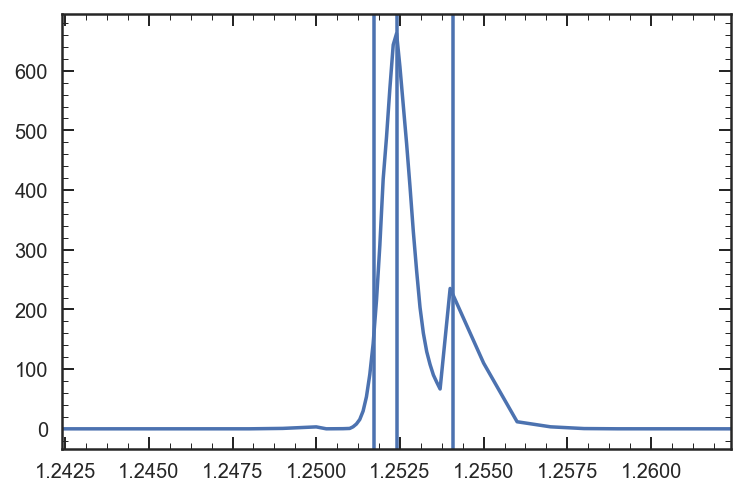

In [32]:
md_,ml_,mh_ = Median_w_Error_cont(pz,z)
md_ = z[pz == max(pz)]
plt.plot(z,pz)
plt.xlim(md_ - 0.01,md_ + 0.01)
plt.axvline(md_)
plt.axvline(md_ - ml_)
plt.axvline(md_ + mh_)

In [29]:
ml_

0.00068006800680068017154

In [4]:
gnd_cat.query('id == 21156')

,id,snr
34,21156,46.262233


In [20]:
N_v4.query('id == 21156')

,id,z,lmass,U,V,J
1143,21156,1.2534,11.02,8.18202,44.2503,135.476


In [21]:
N_zg.query('id == 21156')

,field,id,z50,z16,z84,lmass,U,V,J
881,GN2,21156,1.25247,1.250427,1.253463,11.02,8.18202,44.2503,135.476
2319,GN4,21156,1.25876,1.256593,1.261417,11.03,8.18202,44.2503,135.476


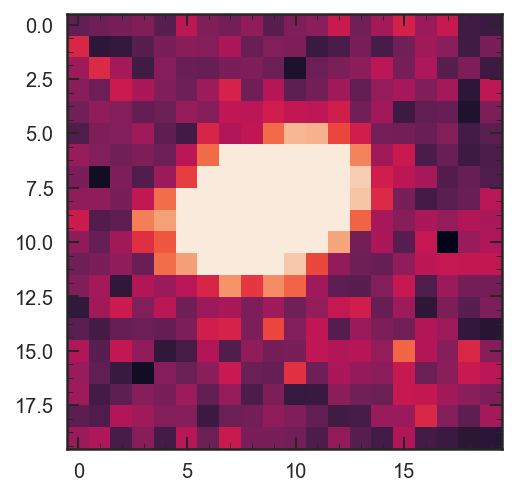

In [281]:
plt.imshow(GS.Bbeam.beam.direct, interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)

In [45]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, 
                                         zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)

In [153]:
Bchi0 = np.load('../data/posteriors/test_B_chi_0.npy')
Bchi1 = np.load('../data/posteriors/test_B_chi_1.npy')
Bchi2 = np.load('../data/posteriors/test_B_chi_2.npy')
Bchi3 = np.load('../data/posteriors/test_B_chi_3.npy')

Rchi0 = np.load('../data/posteriors/test_R_chi_0.npy')
Rchi1 = np.load('../data/posteriors/test_R_chi_1.npy')
Rchi2 = np.load('../data/posteriors/test_R_chi_2.npy')
Rchi3 = np.load('../data/posteriors/test_R_chi_3.npy')

Pchi0 = np.load('../data/posteriors/test_P_chi_0.npy')
Pchi1 = np.load('../data/posteriors/test_P_chi_1.npy')
Pchi2 = np.load('../data/posteriors/test_P_chi_2.npy')
Pchi3 = np.load('../data/posteriors/test_P_chi_3.npy')

Tchi0 = np.load('../data/posteriors/test_chi_0.npy')
Tchi1 = np.load('../data/posteriors/test_chi_1.npy')
Tchi2 = np.load('../data/posteriors/test_chi_2.npy')
Tchi3 = np.load('../data/posteriors/test_chi_3.npy')

In [33]:
age = np.round(np.arange(0.5, 6.1, 1),2)
metal= np.round(np.arange(0.002 , 0.031, 0.005),4)
tau = np.round(np.logspace(np.log10(0.01), np.log10(3), 5), 3)
dust = np.round(np.arange(0, 1.1, 0.3),2)

def Sum_all(chi, metal, age, tau, dust):
#     return np.sum(np.sum(np.sum(np.sum(chi, axis=4).T,  axis=3), axis=2), axis=1)
    return np.trapz(np.trapz(np.trapz(np.trapz(chi, dust, axis=4).T, metal, axis=3), age, axis=2), tau, axis=1) 

In [154]:
B0sum =  Sum_all(Bchi0, m0, a0, t0, d0)
R0sum =  Sum_all(Rchi0, m0, a0, t0, d0)
P0sum =  Sum_all(Pchi0, m0, a0, t0, d0)
T0sum =  Sum_all(Tchi0, m0, a0, t0, d0)

# z1sum =  Sum_all(chidat1, m1, a1, t1, d1)
# z2sum =  Sum_all(chidat2, m2, a2, t2, d2)
# z3sum =  Sum_all(chidat3, m3, a3, t3, d3)

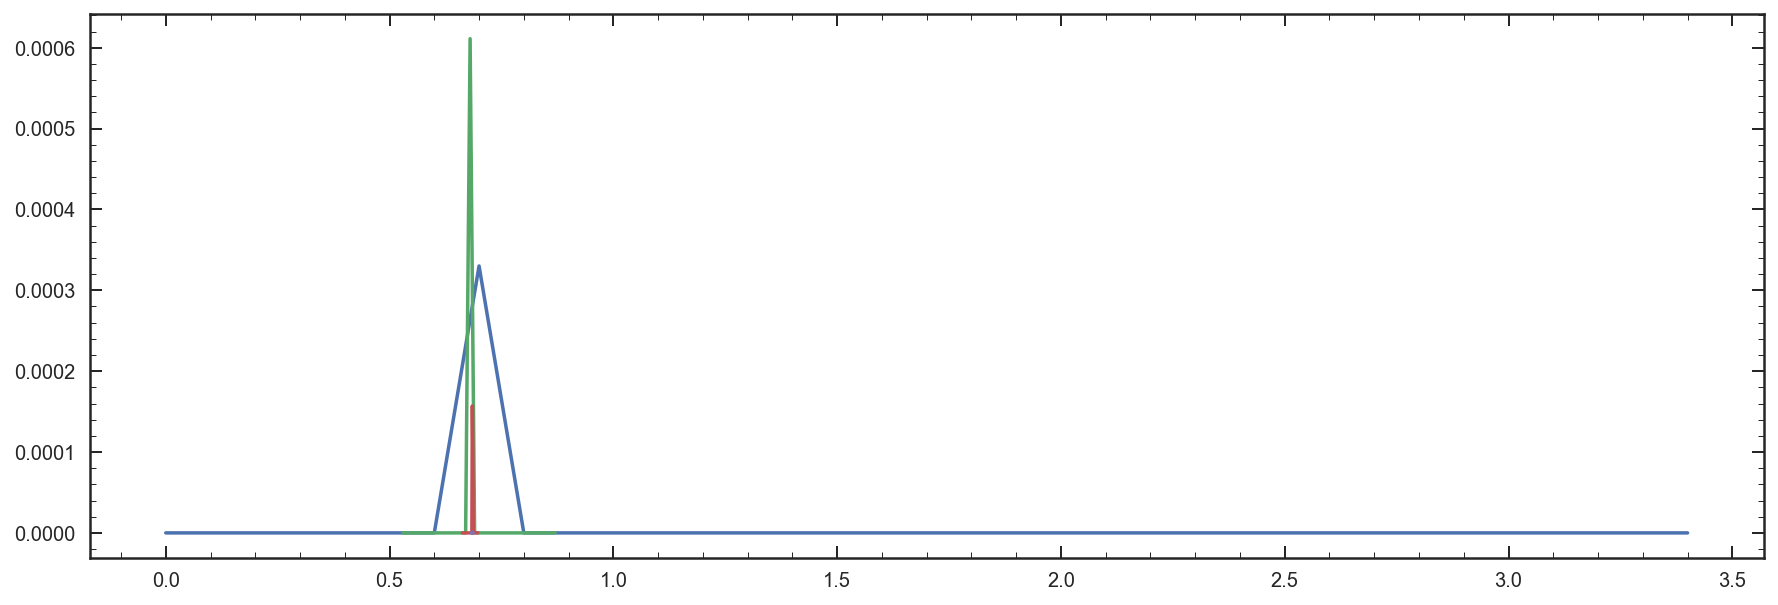

In [148]:
plt.figure(figsize=[15,5])
plt.plot(z0,Pz0)
plt.plot(z1,Pz1)
plt.plot(z2,Pz2)
plt.plot(z3,Pz3)


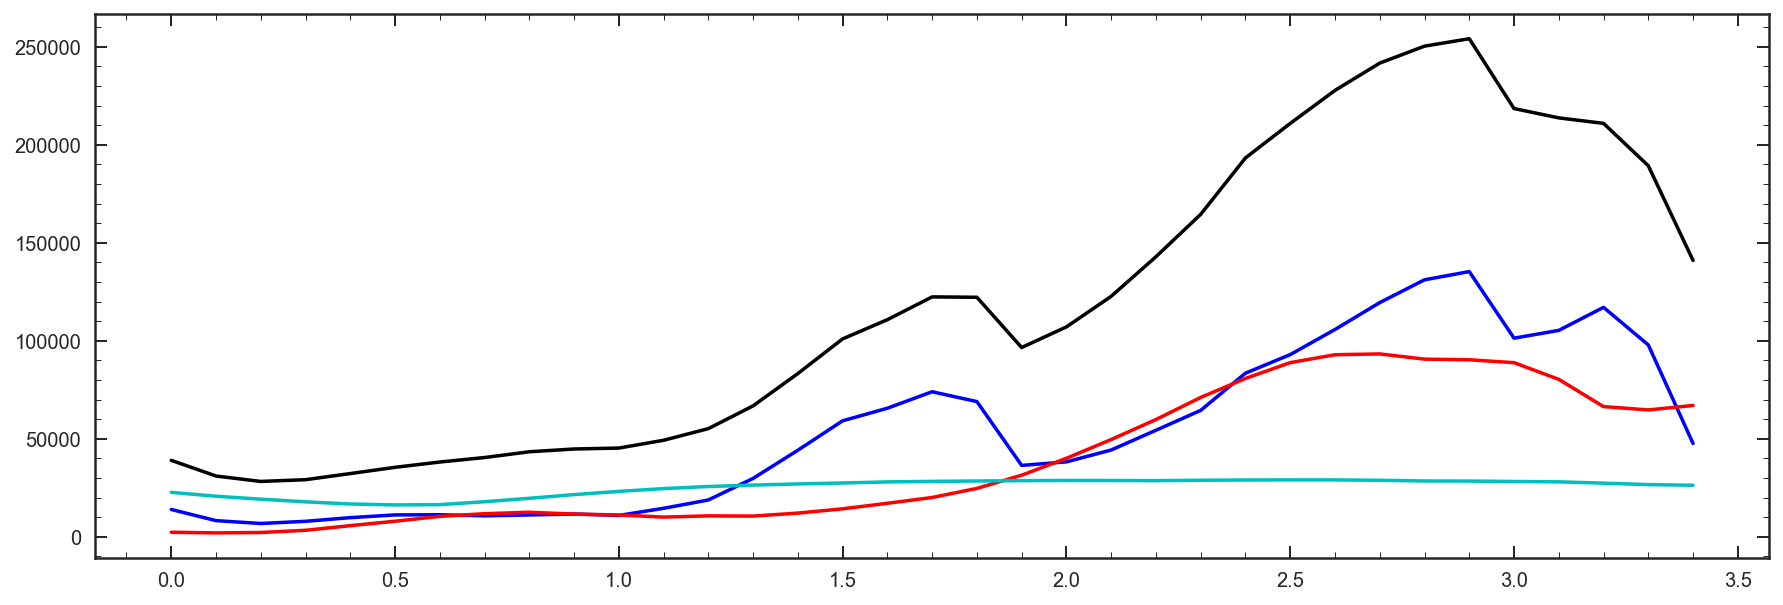

In [157]:
plt.figure(figsize=[15,5])
plt.plot(z0, B0sum,'b')
plt.plot(z0, R0sum,'r')
plt.plot(z0, P0sum,'c')
plt.plot(z0, T0sum,'k')


In [38]:
from spec_id import Redshift_analyze

In [176]:
B0ana =  Redshift_analyze(Bchi0, np.min(Bchi0), m0, a0, t0, z0, d0)
R0ana =  Redshift_analyze(Rchi0, np.min(Rchi0), m0, a0, t0, z0, d0)
P0ana =  Redshift_analyze(Pchi0, np.min(Pchi0), m0, a0, t0, z0, d0)
T0ana =  Redshift_analyze(Tchi0, np.min(Tchi0), m0, a0, t0, z0, d0)
G0ana =  Redshift_analyze(Bchi0 + Rchi0, np.min(Bchi0 + Rchi0), m0, a0, t0, z0, d0)

# z1ana =  Redshift_analyze(chidat1, np.min(chidat0), metal, age, tau, z1, dust)
# z2ana =  Redshift_analyze(chidat2, np.min(chidat0), metal, age, tau, z2, dust)
# z3ana =  Redshift_analyze(chidat3, np.min(chidat0), metal, age, tau, z3, dust)

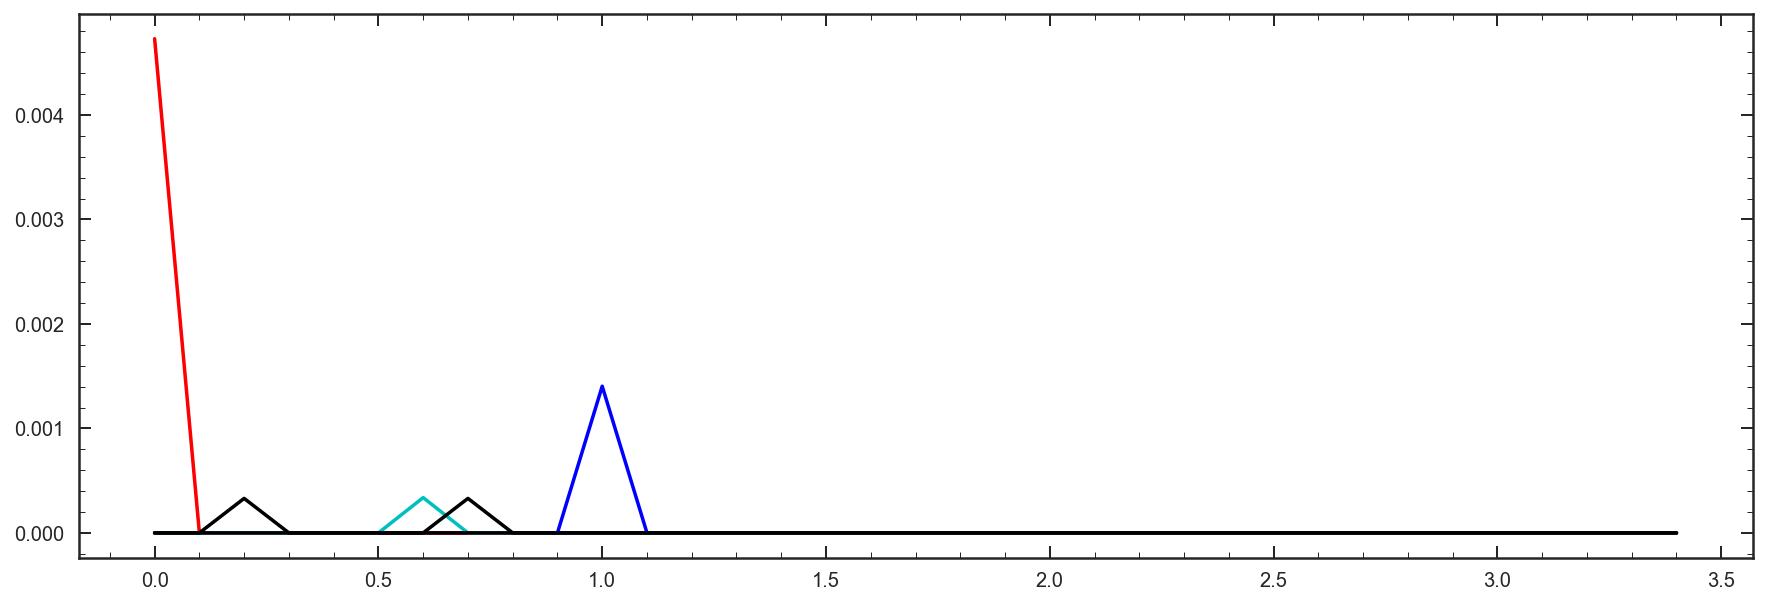

In [177]:
plt.figure(figsize=[15,5])
plt.plot(z0, B0ana,'b')
plt.plot(z0, R0ana,'r')
plt.plot(z0, P0ana,'c')
plt.plot(z0, T0ana,'k')
plt.plot(z0, G0ana,'k')

# plt.plot(z1, z1ana)
# plt.plot(z2, z2ana)
# plt.plot(z3, z3ana)

In [178]:
print(np.where(Bchi0 == np.min(Bchi0)), z0[6], np.min(Bchi0))
# print(np.where(chidat1 == np.min(chidat1)), z1[21], np.min(chidat1))
# print(np.where(chidat2 == np.min(chidat2)), z1[18], np.min(chidat2))
# print(np.where(chidat3 == np.min(chidat3)), z1[13], np.min(chidat3))

(array([0, 0, 0, 0]), array([2, 2, 2, 2]), array([2, 2, 2, 2]), array([10, 10, 10, 10]), array([0, 1, 2, 3])) 0.6000000000000000888 1180.1698911561177


In [55]:
print(len(GS.Pflx) + len(GS.Bflx) + len(GS.Rflx))

301


In [121]:
def Set_rshift_params(metal_i, age_i, tau_i, rshift_i, dust_i, stage):
    tau = np.round(np.logspace(np.log10(0.01), np.log10(3), 5), 3)
    dust = np.round(np.arange(0, 1.1, 0.3),2)

    
    if stage == 0:
        age = np.round(np.arange(0.5, 14.1, 2),2)
        metal= np.round(np.arange(0.002 , 0.031, 0.0045),4)
        rshift = np.arange(0, 3.5, 0.1)
    
    if stage == 1:
        if age_i <= 0.3:
            age_i = 0.31
            
        if metal_i <= 0.006:
            metal_i = 0.007
            
        age = np.round(np.arange(age_i - 3, age_i + 4, 1),2)
        metal= np.round(np.arange(metal_i - 0.006, metal_i + 0.007, 0.002),4)
        rshift = np.arange(rshift_i - 0.17, rshift_i + 0.18, 0.01)
        
    
    if stage == 2:
        if age_i <= 1.5:
            age_i = 1.6
            
        if metal_i <= 0.003:
            metal_i = 0.004
            
        age = np.round(np.arange(age_i - 1.5, age_i + 2, 0.5),2)
        metal= np.round(np.arange(metal_i - 0.003, metal_i + 0.004, 0.001),4)
        rshift = np.arange(rshift_i - 0.017, rshift_i + 0.0171, 0.001)
   
    if stage == 3:
        if age_i <= 0.3:
            age_i = 0.4
            
        if metal_i <= 0.0015:
            metal_i = 0.0025
            
        age = np.round(np.arange(age_i - 0.3, age_i + 0.4, 0.1),2)
        metal= np.round(np.arange(metal_i - 0.0015, metal_i + 0.002, 0.0005),4)
        rshift = np.arange(rshift_i - 0.0017, rshift_i + 0.00171, 0.0001)
    
    return metal, age, tau, rshift, dust


In [145]:
m0,a0,t0,rs0,d0 = Set_params(0.019 ,3 ,0.1 , 1, 0.2,0)
m1,a1,t1,rs1,d1 = Set_params(0.002 ,6.5 ,0.1 , 1, 0.2,1)
m2,a2,t2,rs2,d2 = Set_params(0.003 ,6.5 ,0.1 , 1, 0.2,2)
m3,a3,t3,rs3,d3 = Set_params(0.003 ,6.3 ,0.1 , 1, 0.2,3)

In [123]:
[0.002]
[6.5]
[0.7]
[0.003]
[6.5]
[0.68]
[0.003]
[6.5]
[0.685]
[0.003]
[6.3]
[0.6848]

7 7 7 7
7 7 7 7
35 35 35 35
34300
34300
34300
34300


In [249]:
sdat = Table.read('/Volumes/Vince_CLEAR/CATALOGS/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
ndat = Table.read('/Volumes/Vince_CLEAR/CATALOGS/goodsn_3dhst.v4.3.cat',format='ascii').to_pandas()

In [256]:
for i in gsd_cat.index:
    star = sdat.query('id == {0}'.format(gsd_cat.id[i])).class_star.values[0]
    if star > 0.8:
        gsd_cat = gsd_cat[gsd_cat.id != gsd_cat.id[i]]


In [258]:
for i in gnd_cat.index:
    star = ndat.query('id == {0}'.format(gnd_cat.id[i])).class_star.values[0]
    if star > 0.8:
        gnd_cat = gnd_cat[gnd_cat.id != gnd_cat.id[i]]

In [260]:
gsd_cat.to_pickle('../dataframes/GS_snr.pkl')
gnd_cat.to_pickle('../dataframes/GN_snr.pkl')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102
missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.e

missing g102
missing g141
missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102
missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102
missing g141
missing g102
missing g141
missing g102
missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface

missing g102
missing g141
missing g102
missing g141
missing g102
missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true

missing g102
missing g141
missing g102
missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


missing g102
missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


missing g102
missing g141


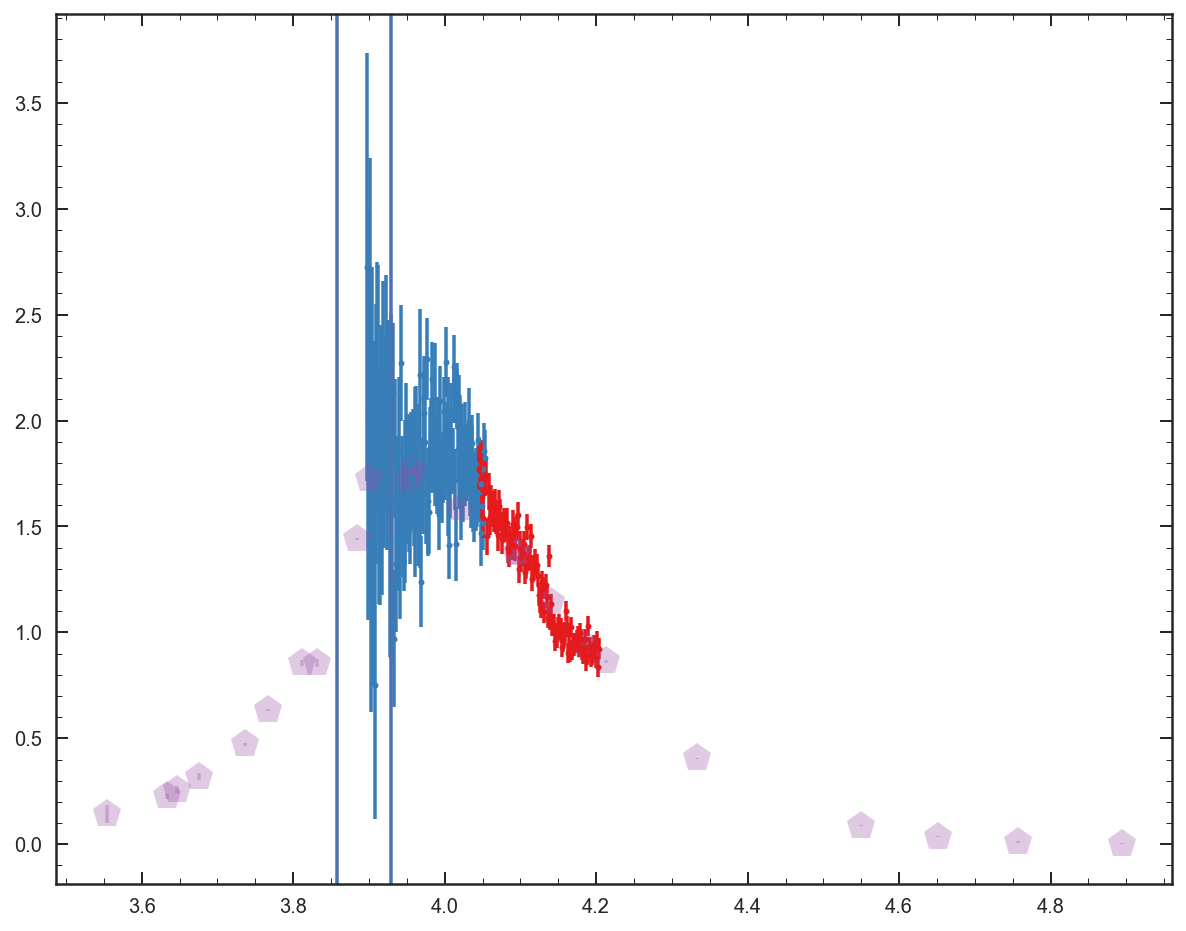

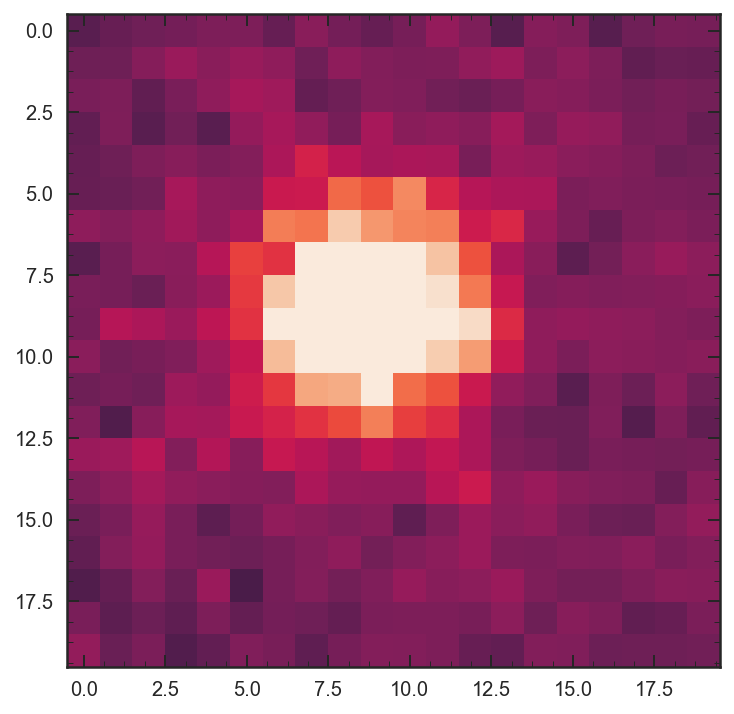

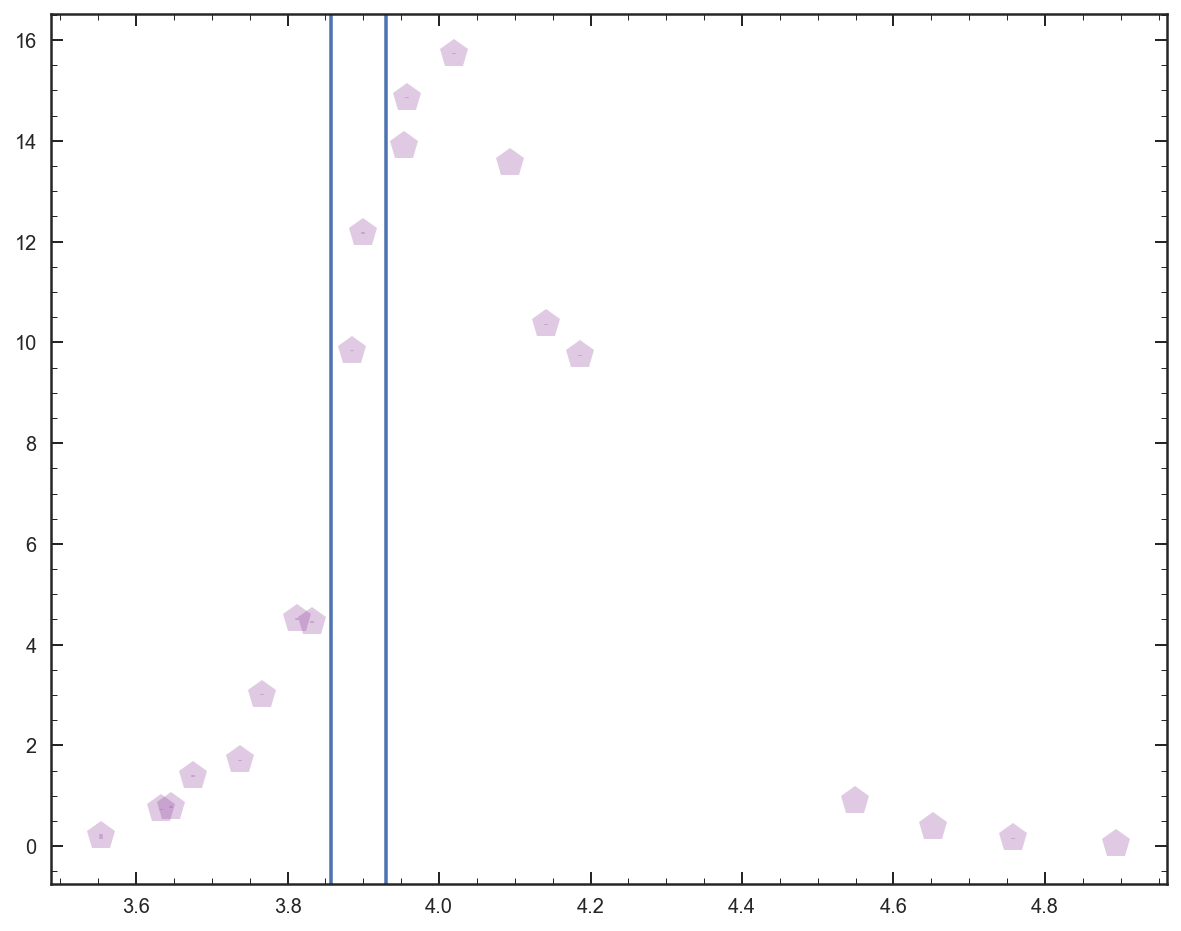

<Figure size 432x432 with 0 Axes>

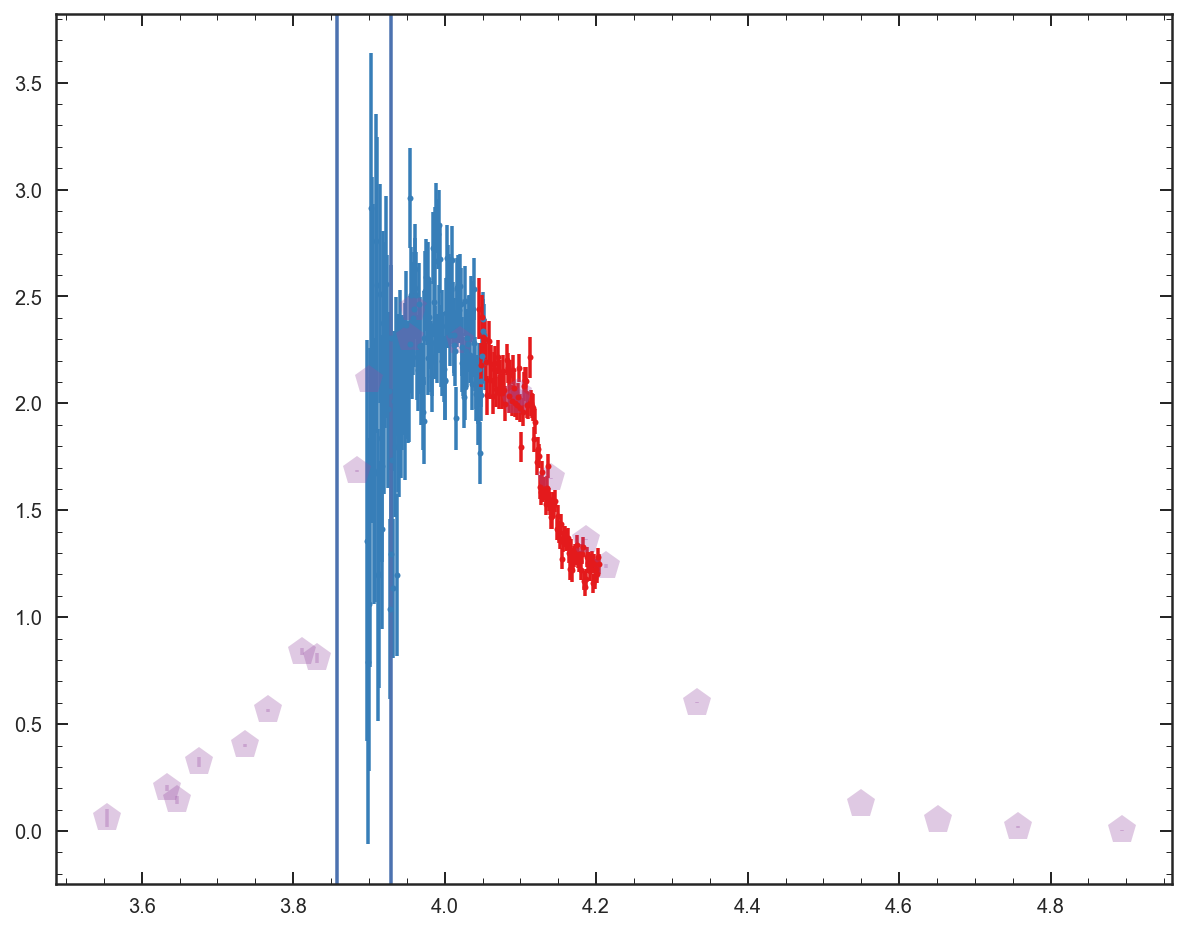

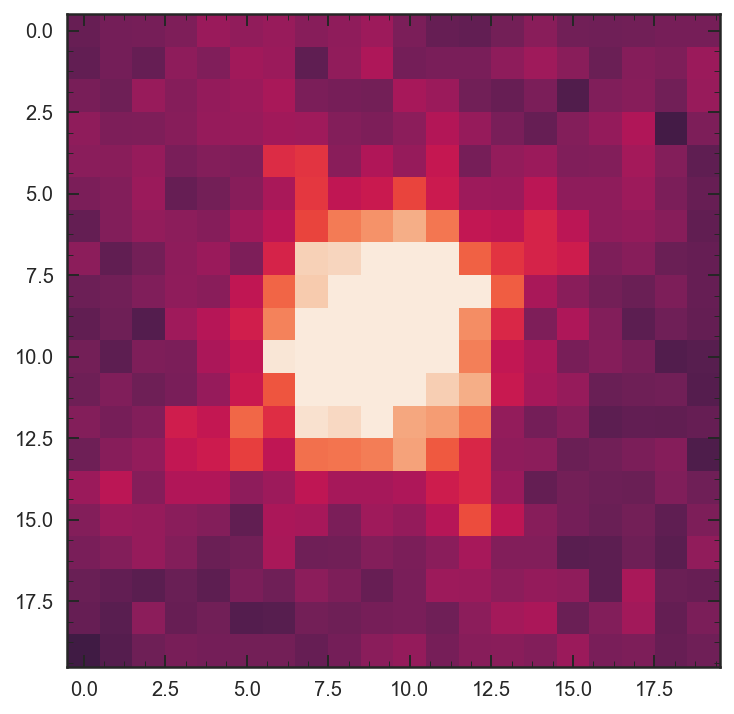

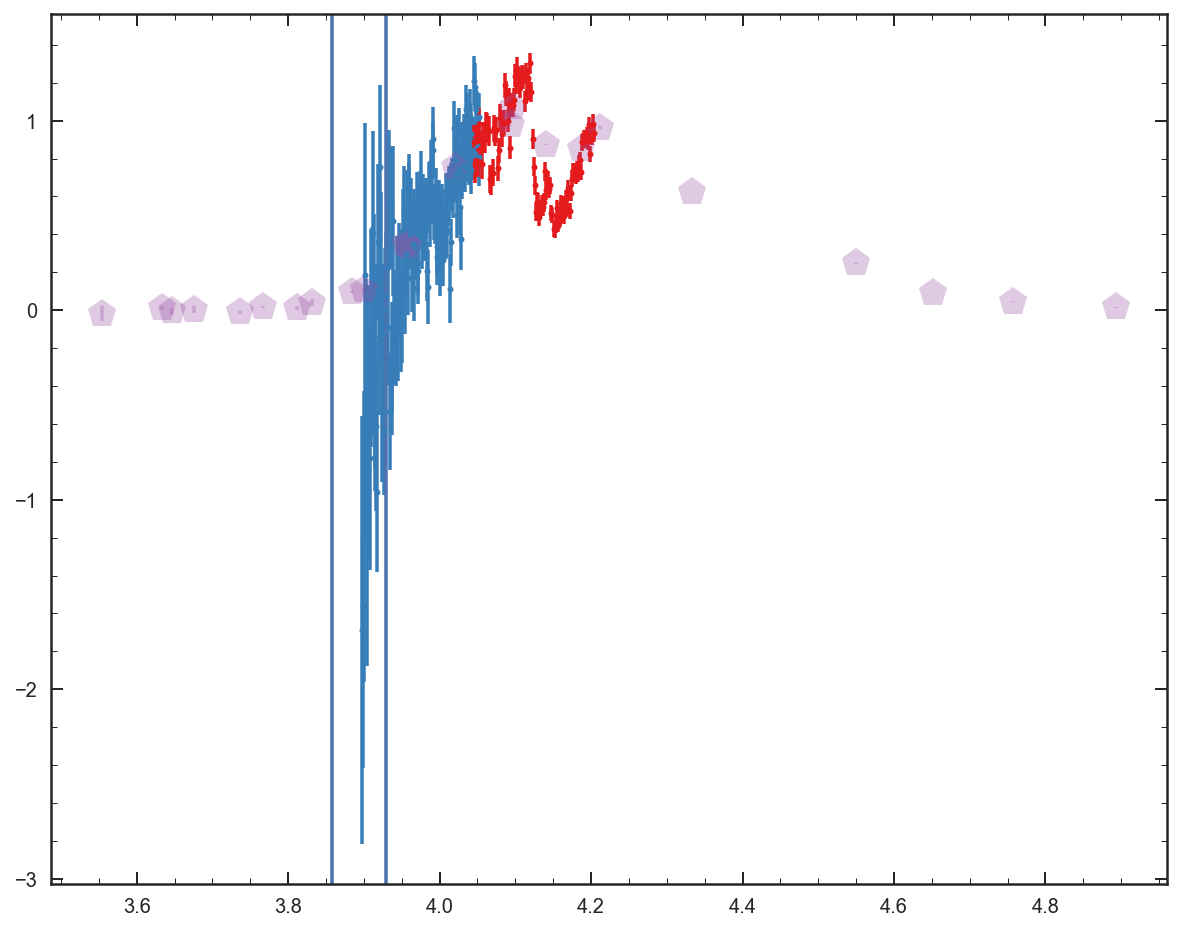

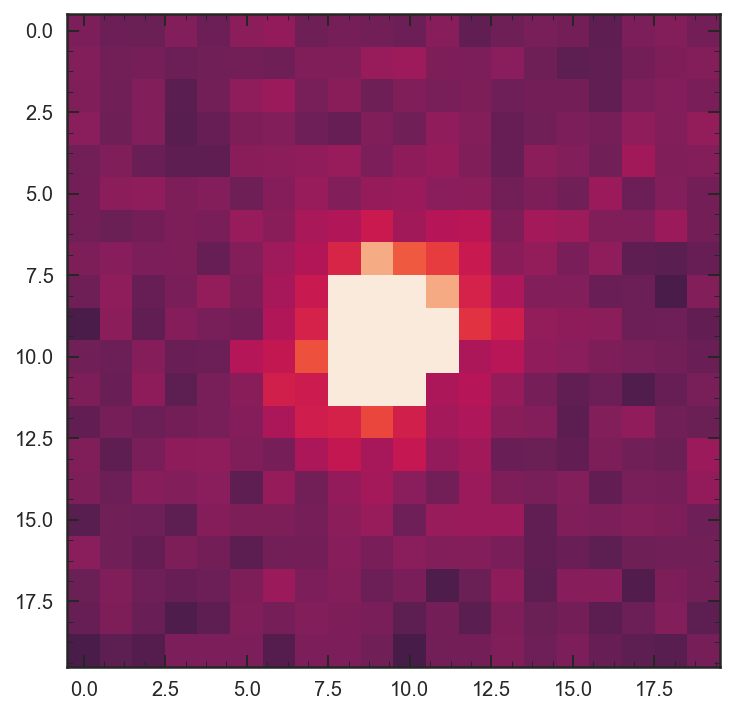

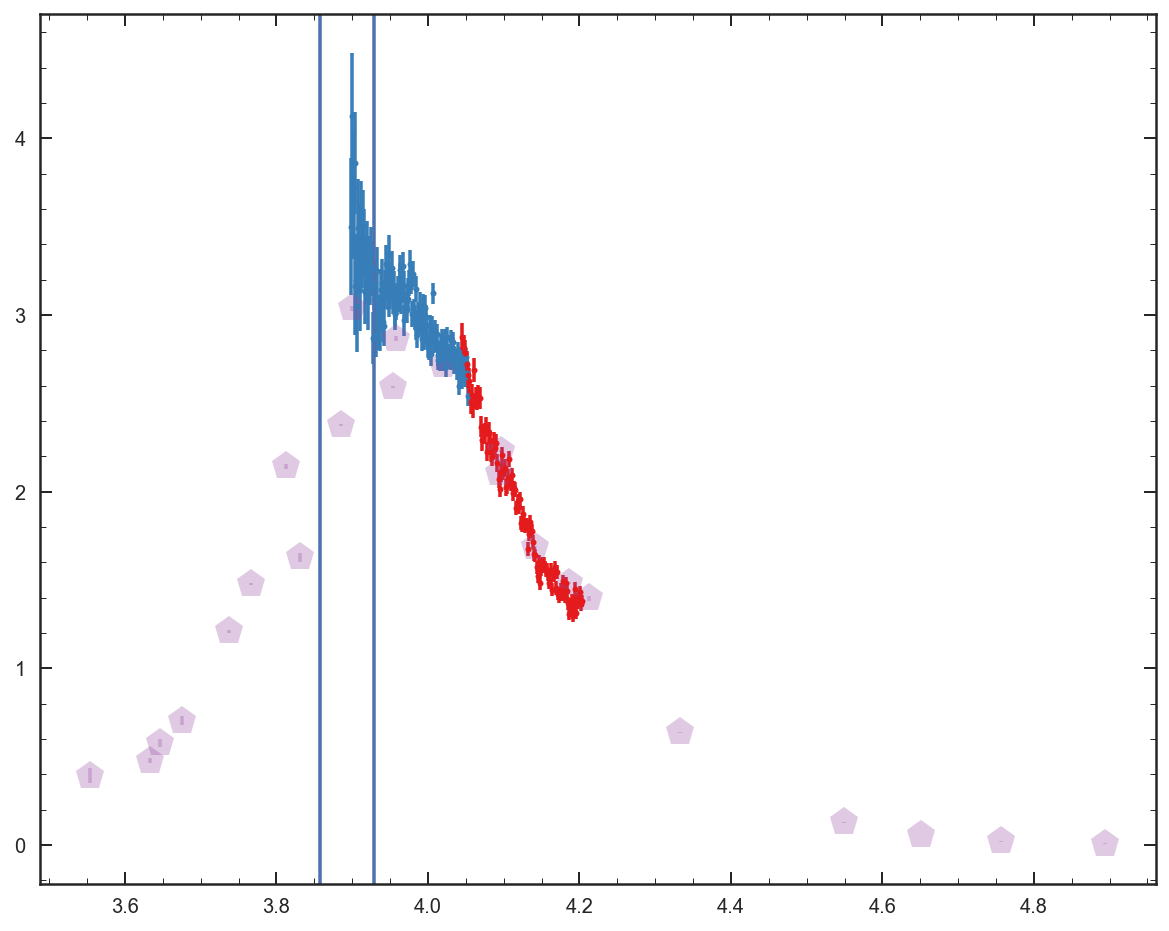

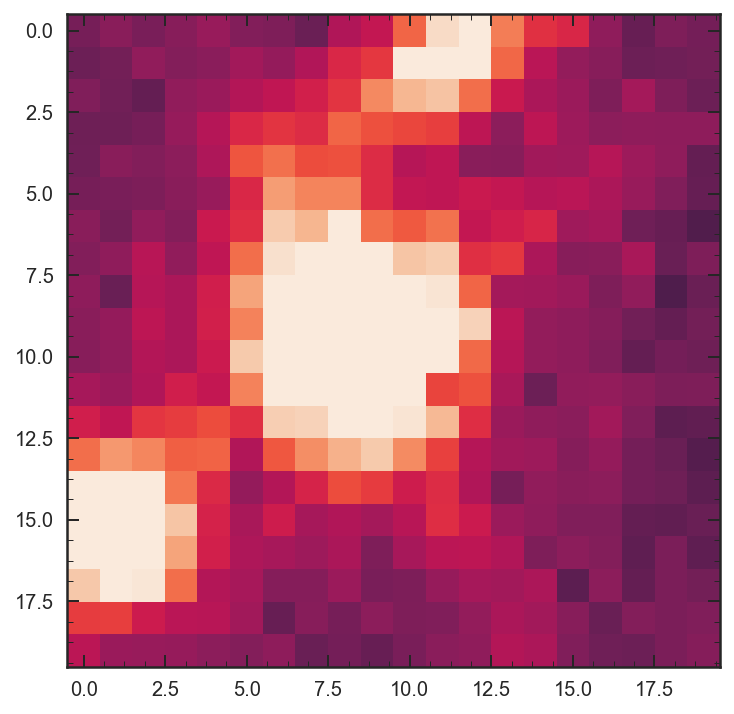

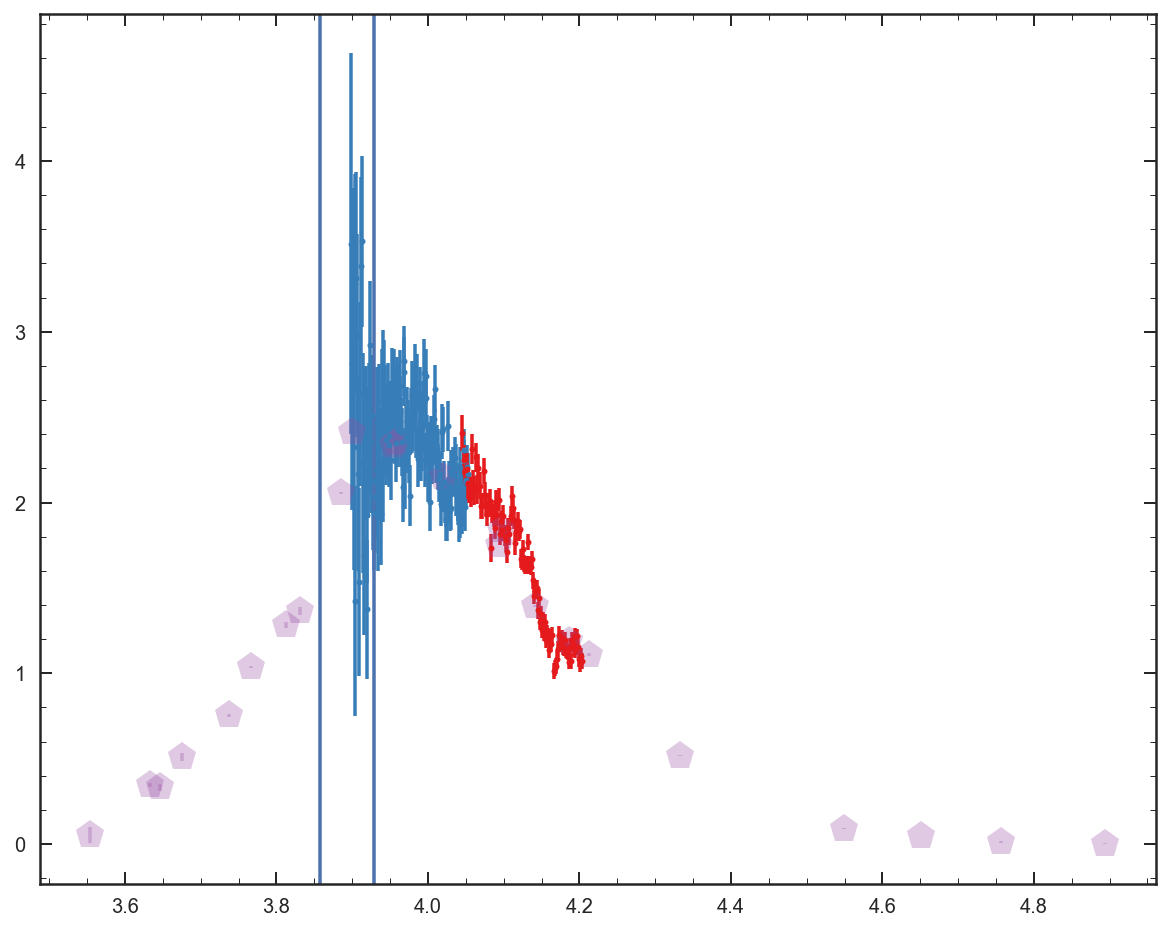

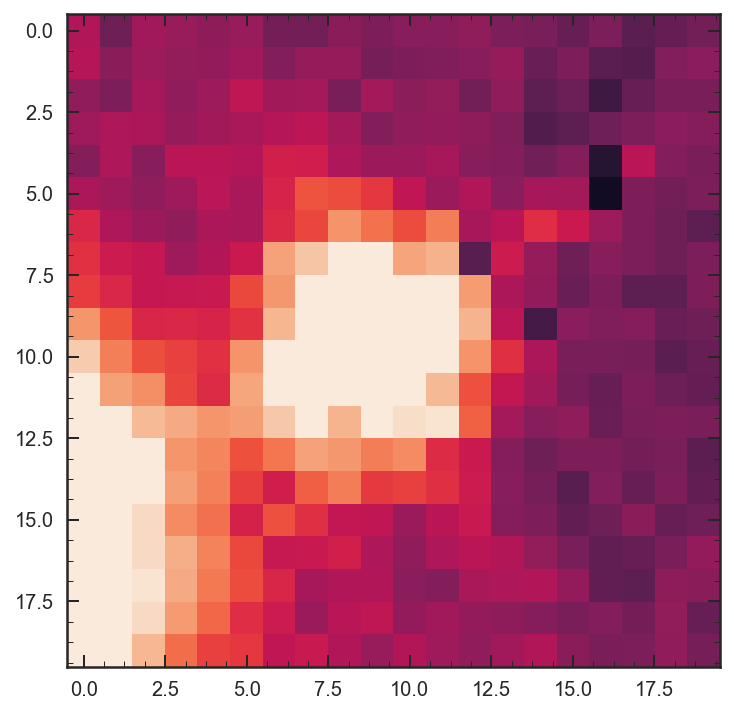

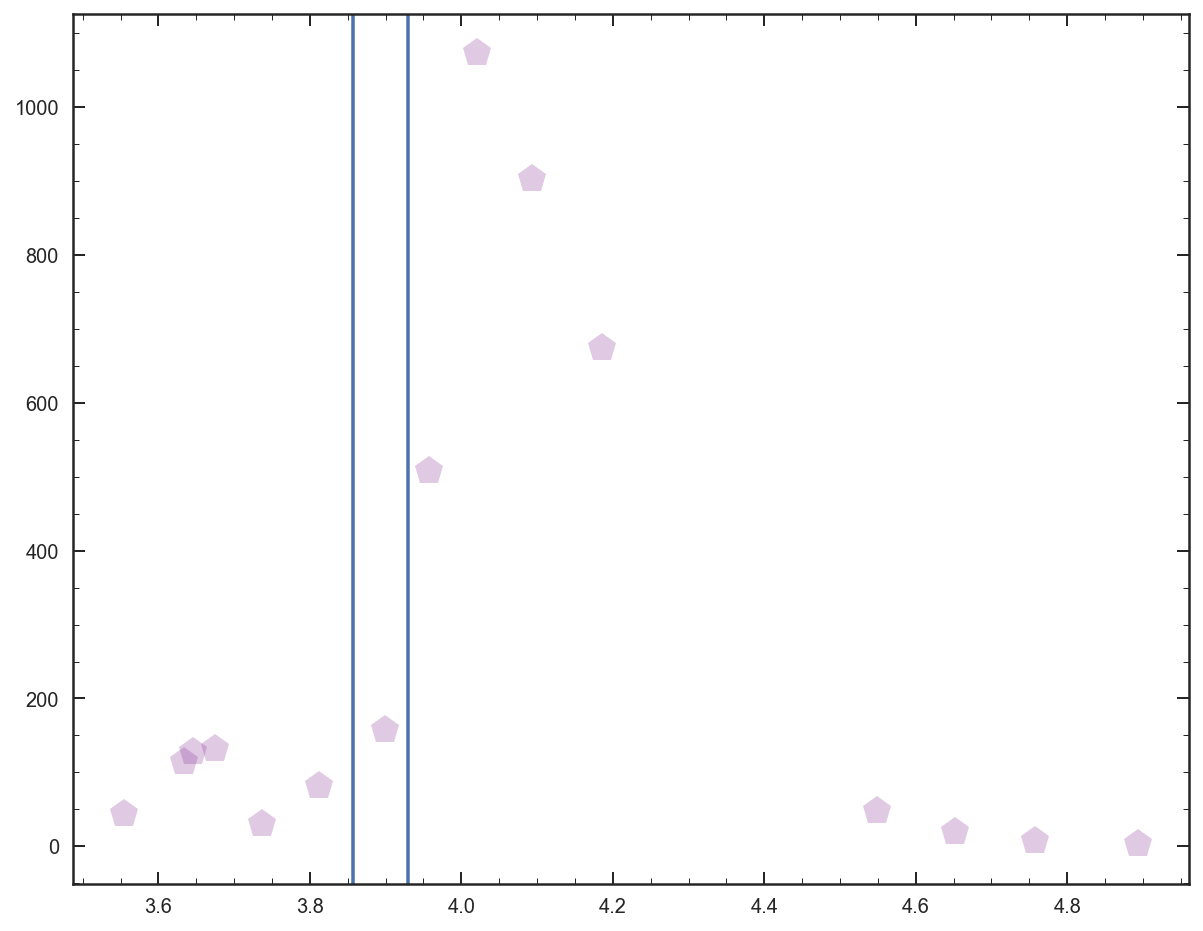

<Figure size 432x432 with 0 Axes>

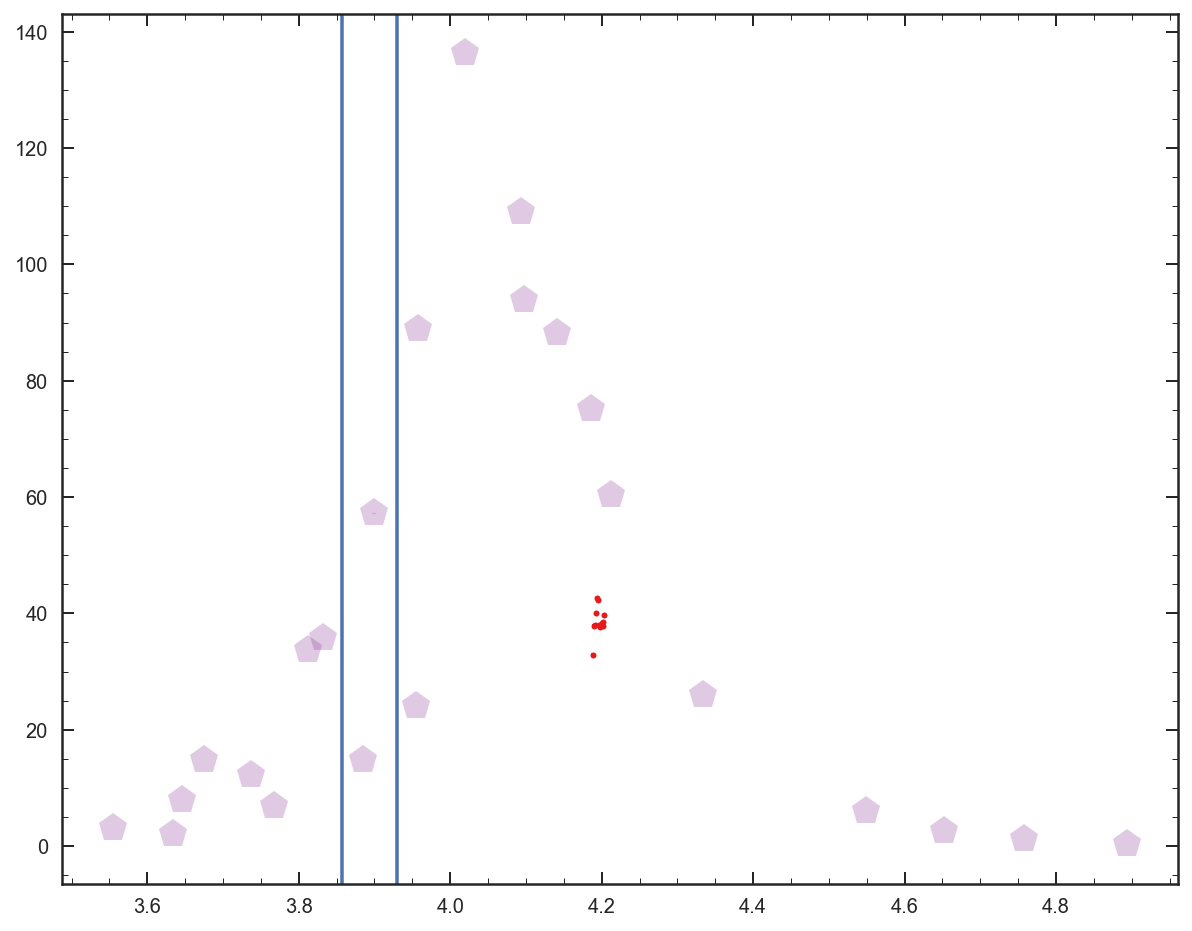

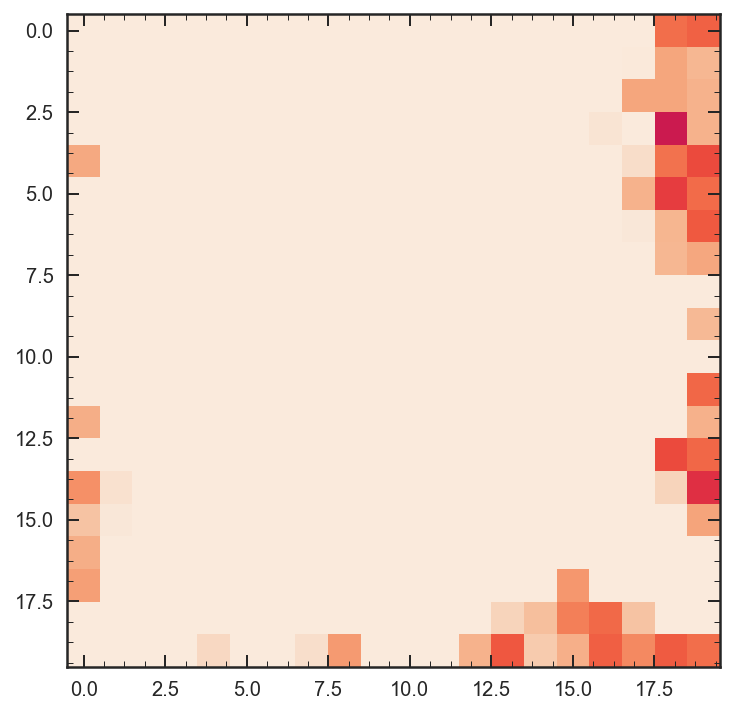

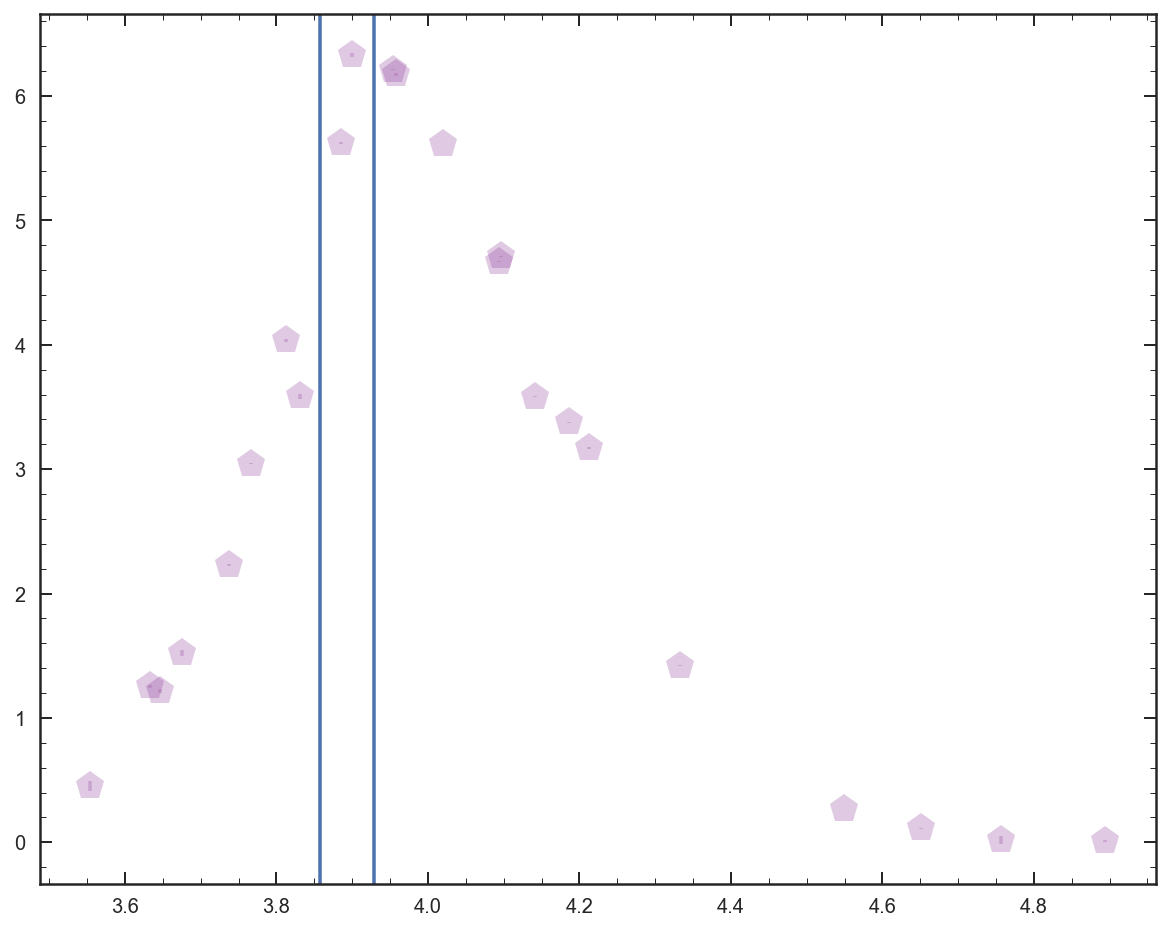

<Figure size 432x432 with 0 Axes>

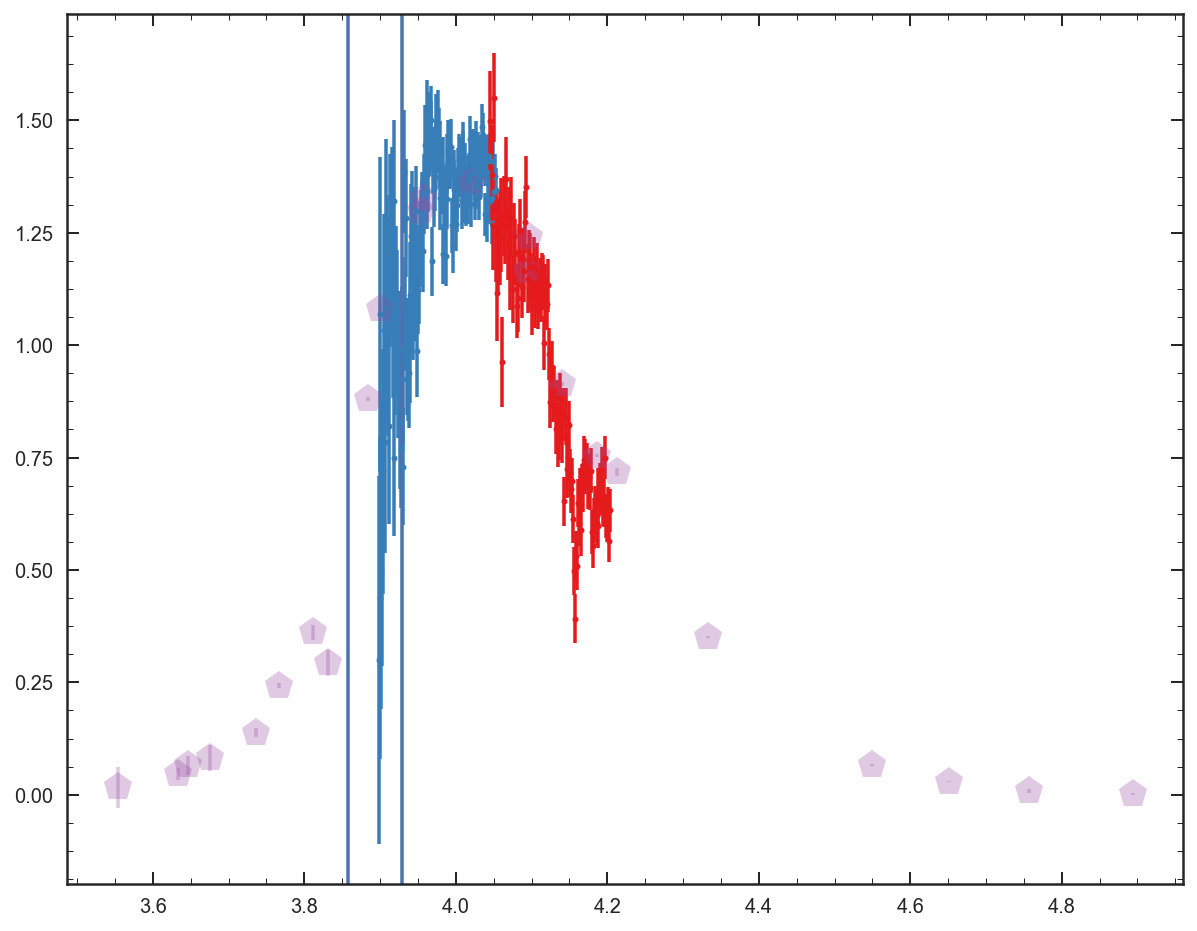

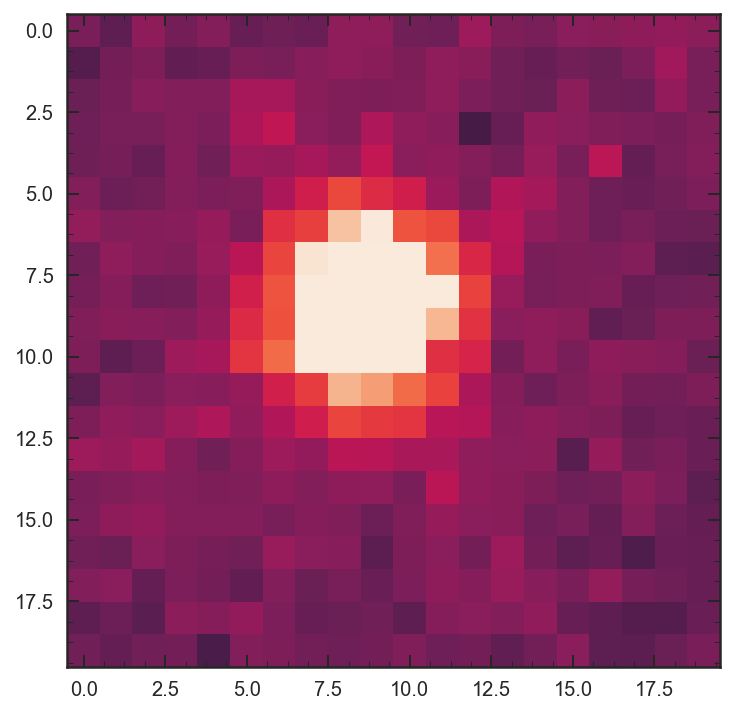

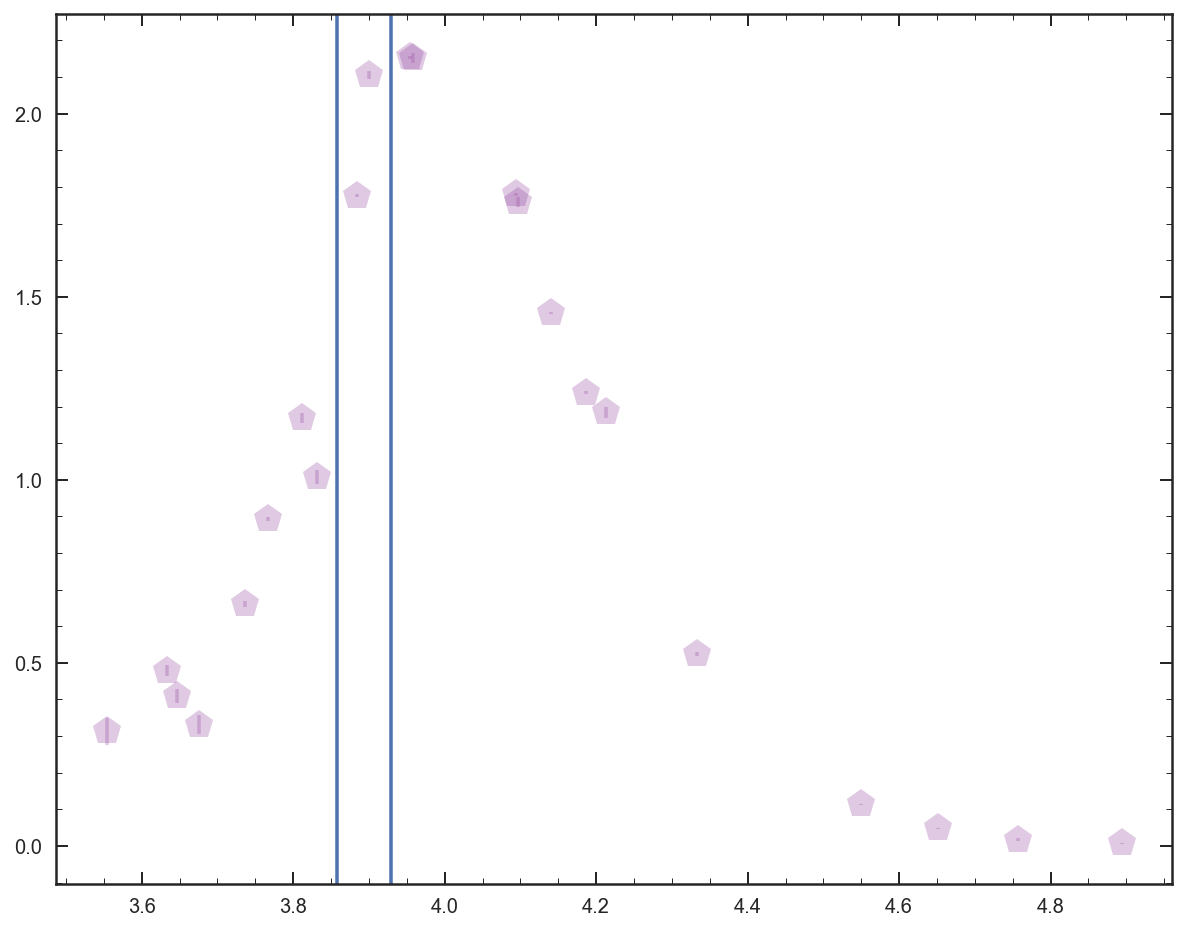

<Figure size 432x432 with 0 Axes>

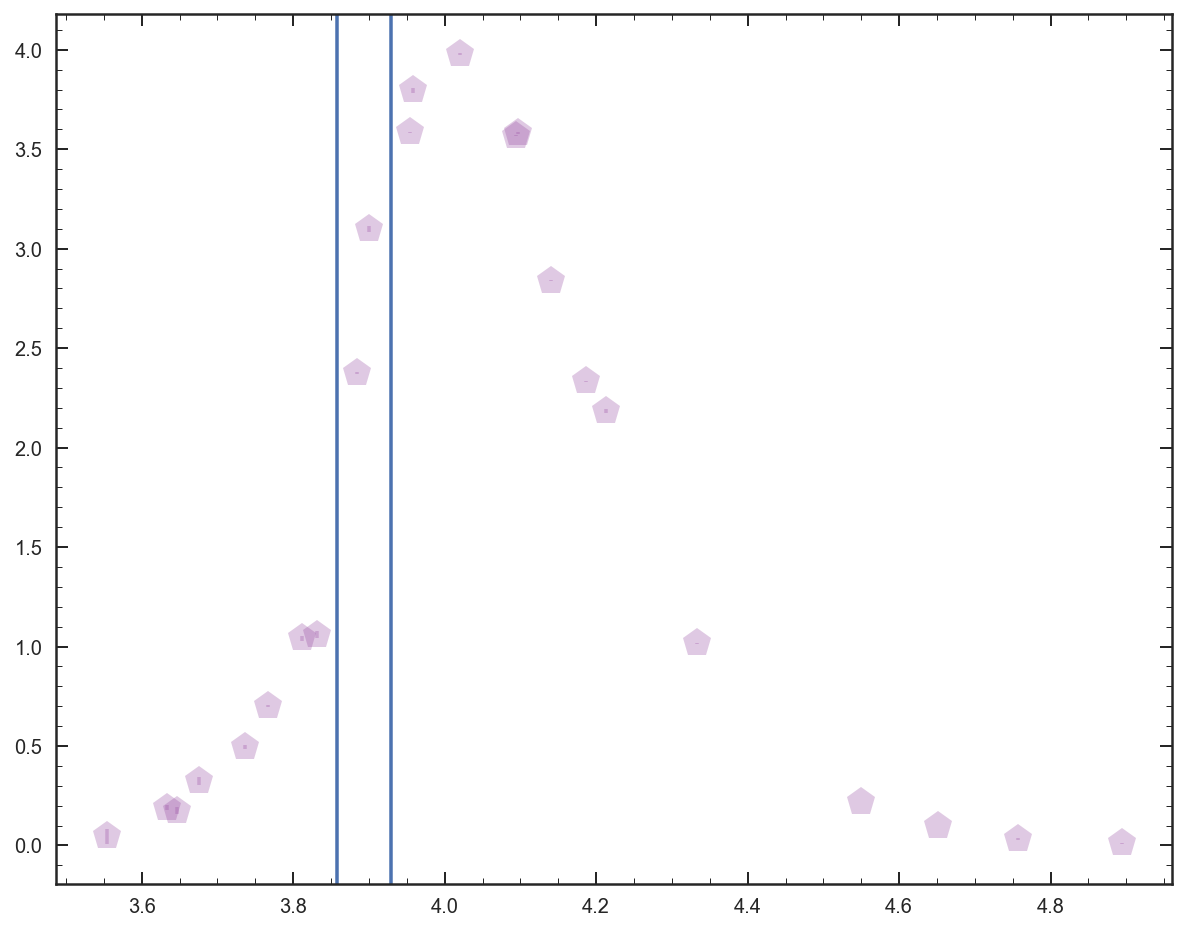

<Figure size 432x432 with 0 Axes>

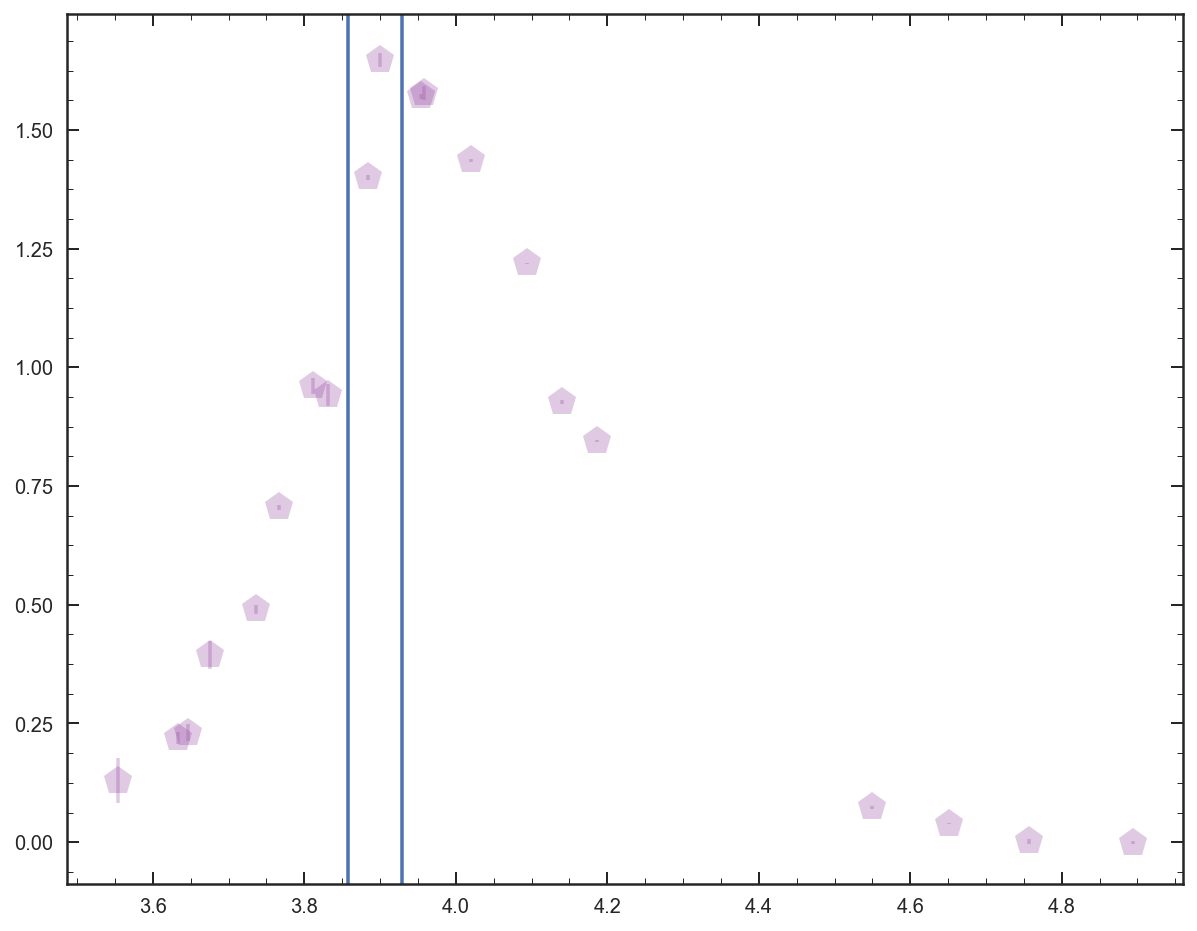

<Figure size 432x432 with 0 Axes>

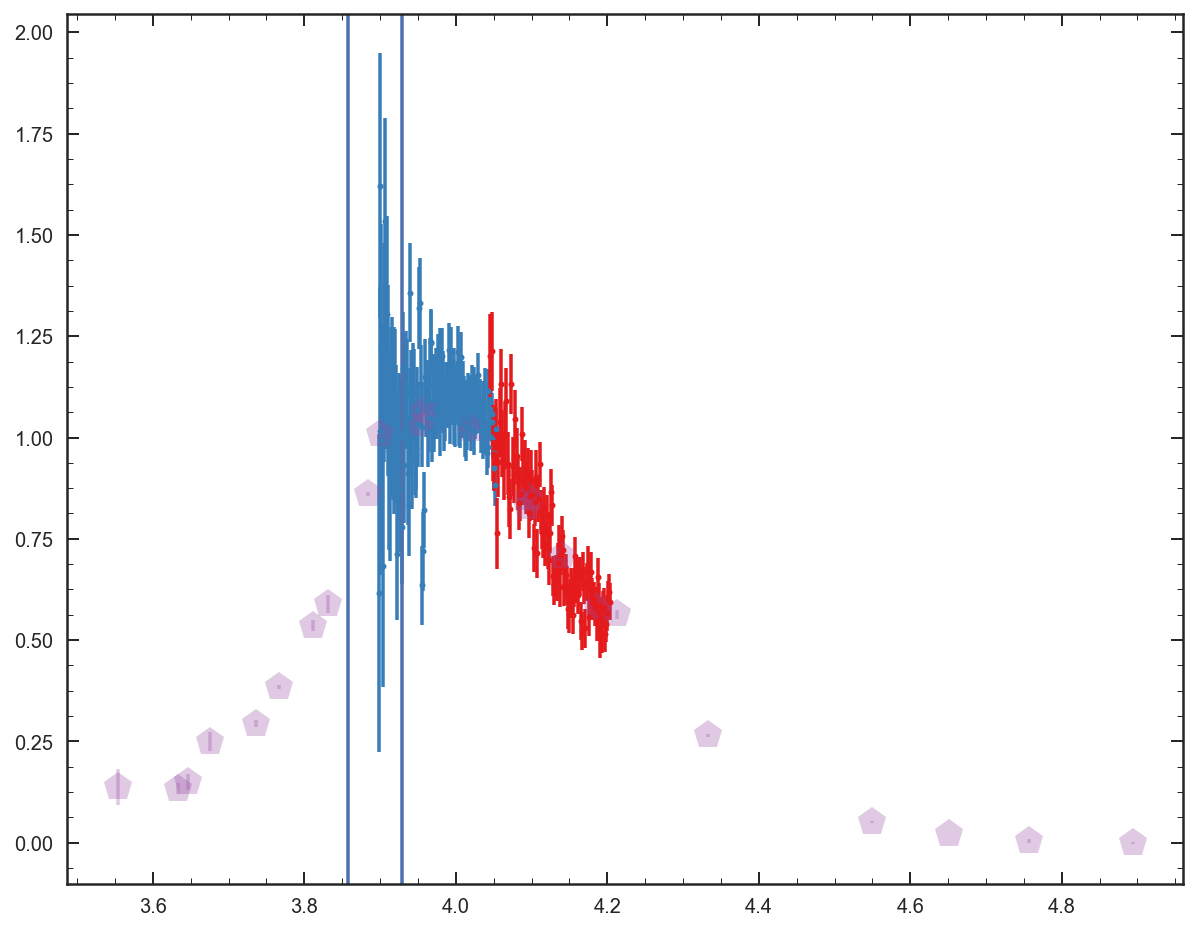

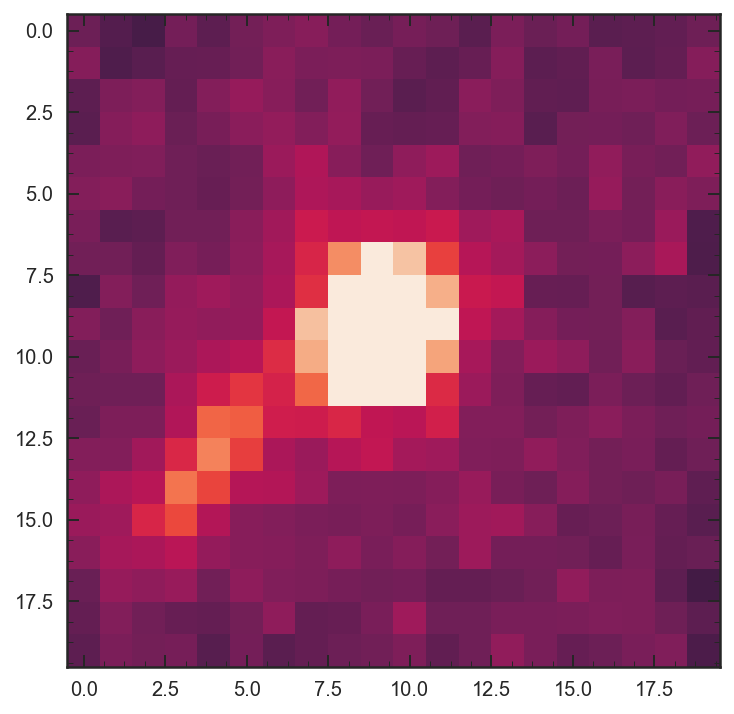

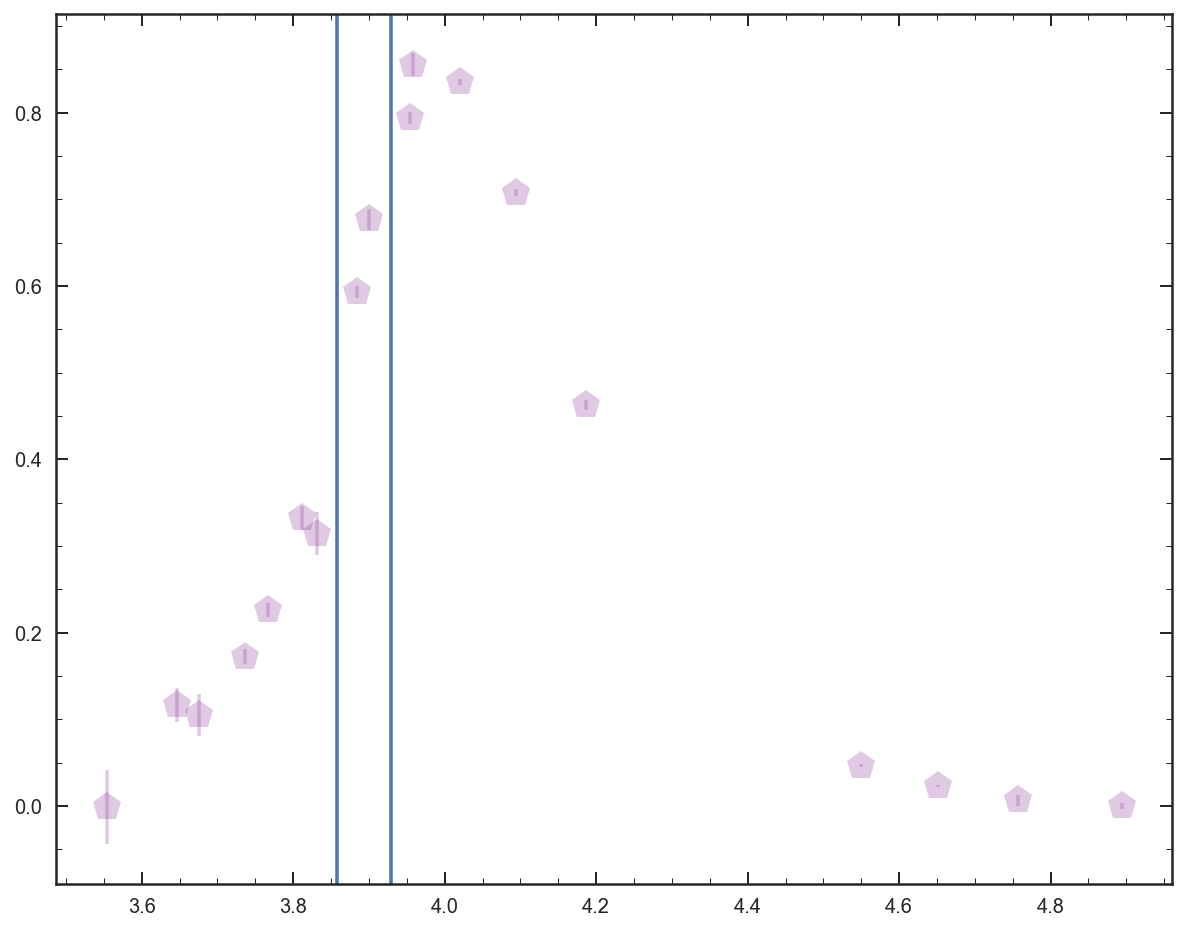

<Figure size 432x432 with 0 Axes>

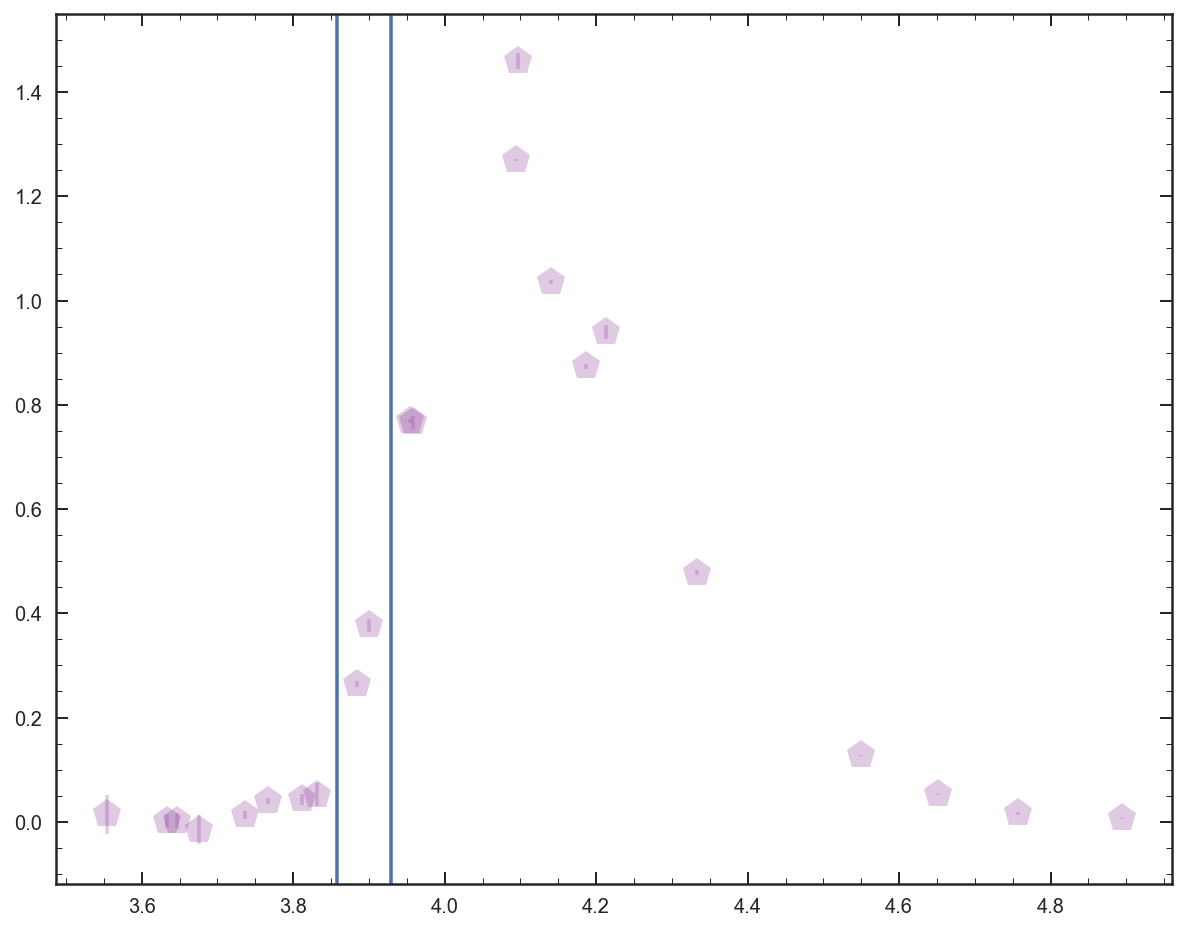

<Figure size 432x432 with 0 Axes>

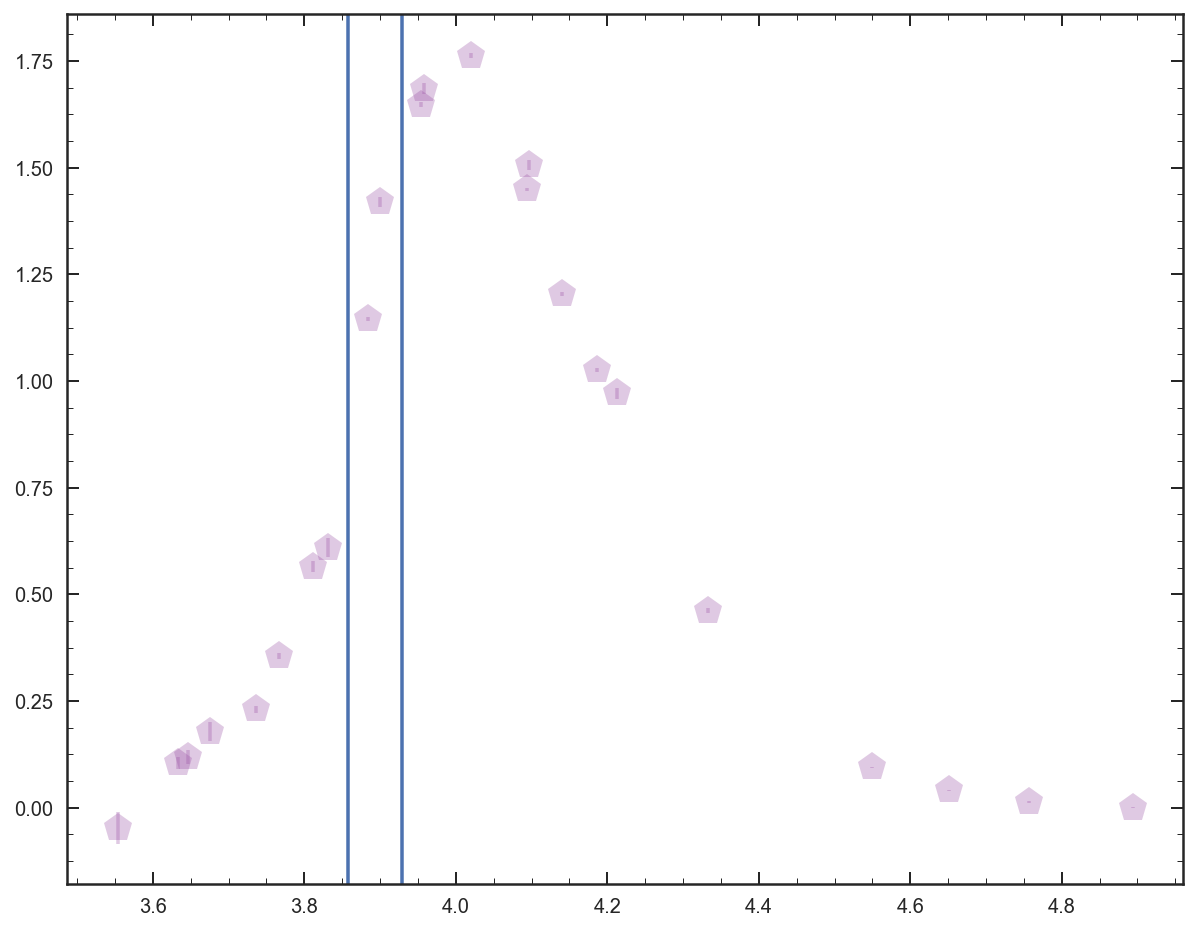

<Figure size 432x432 with 0 Axes>

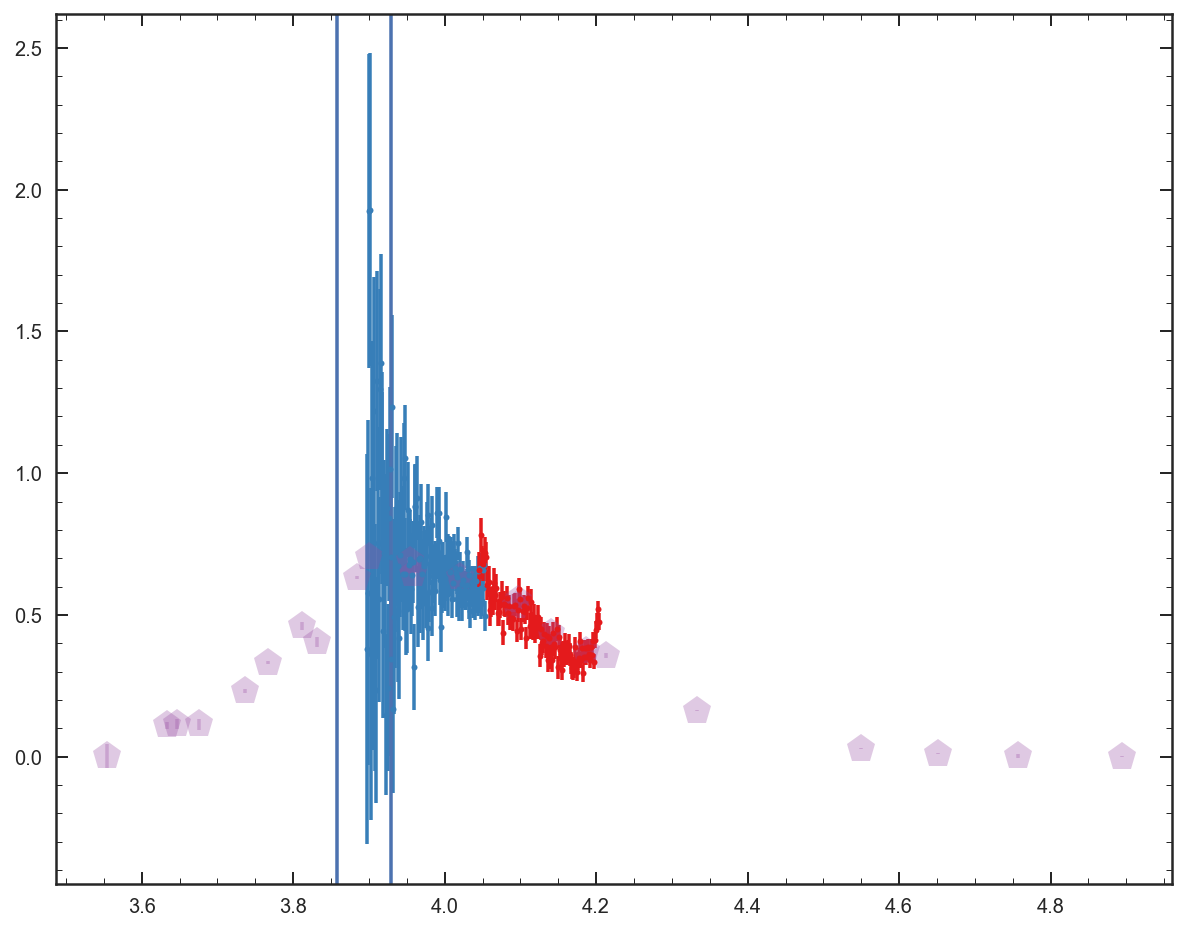

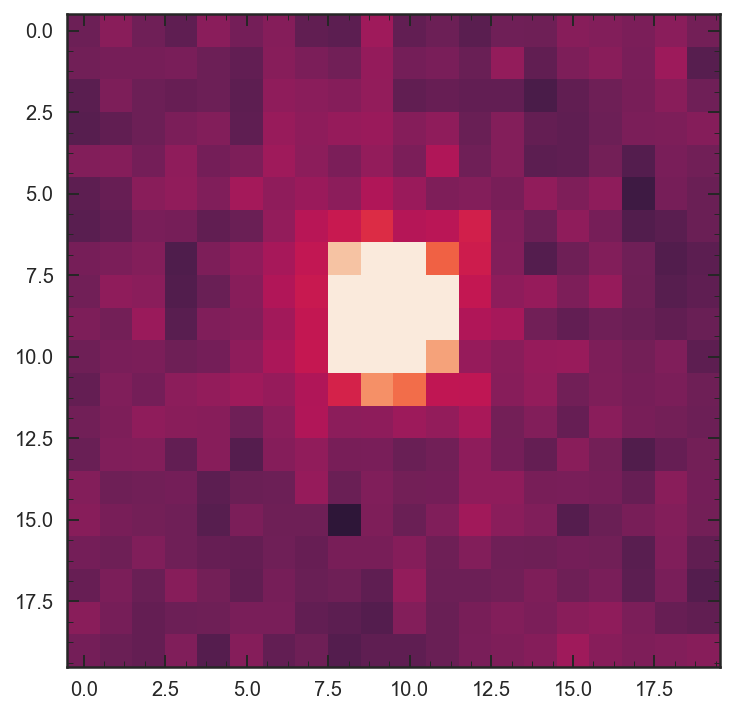

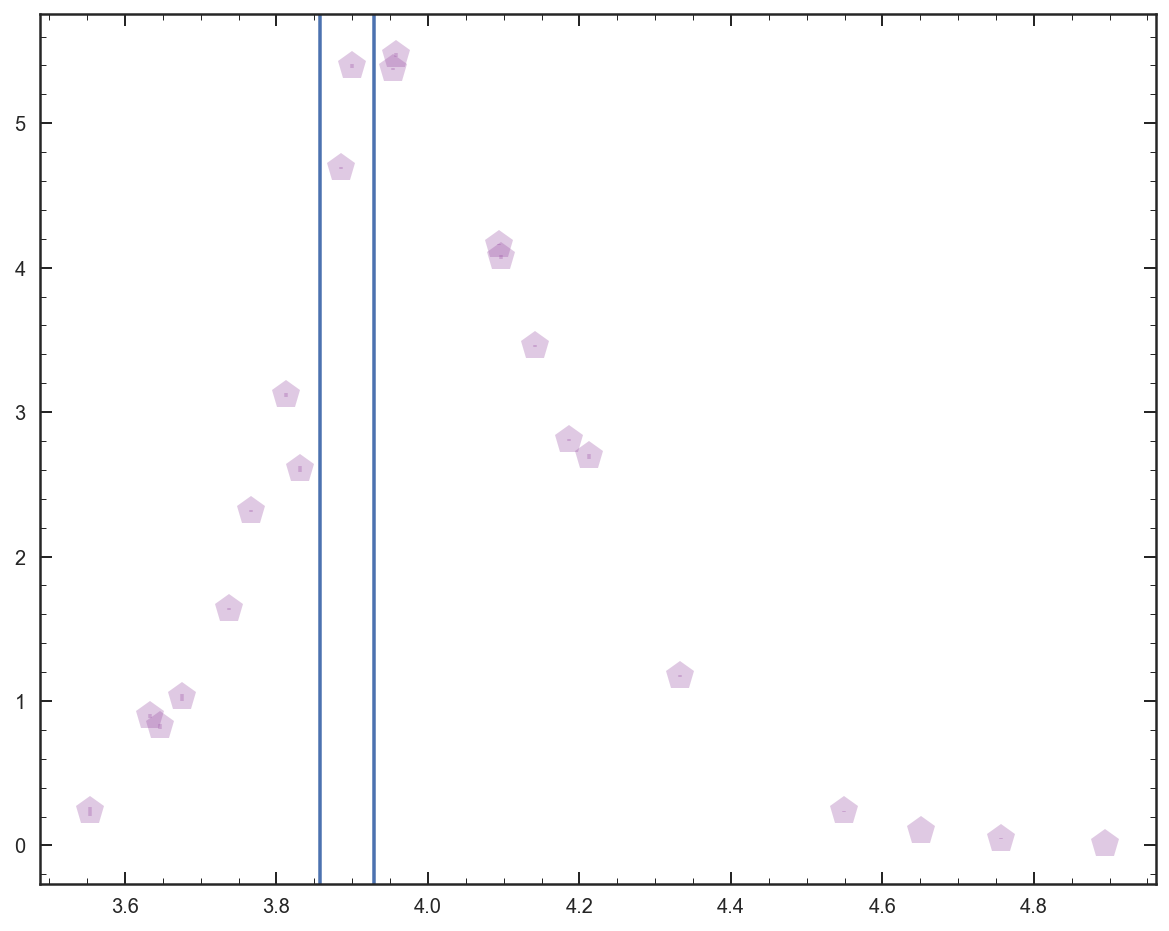

<Figure size 432x432 with 0 Axes>

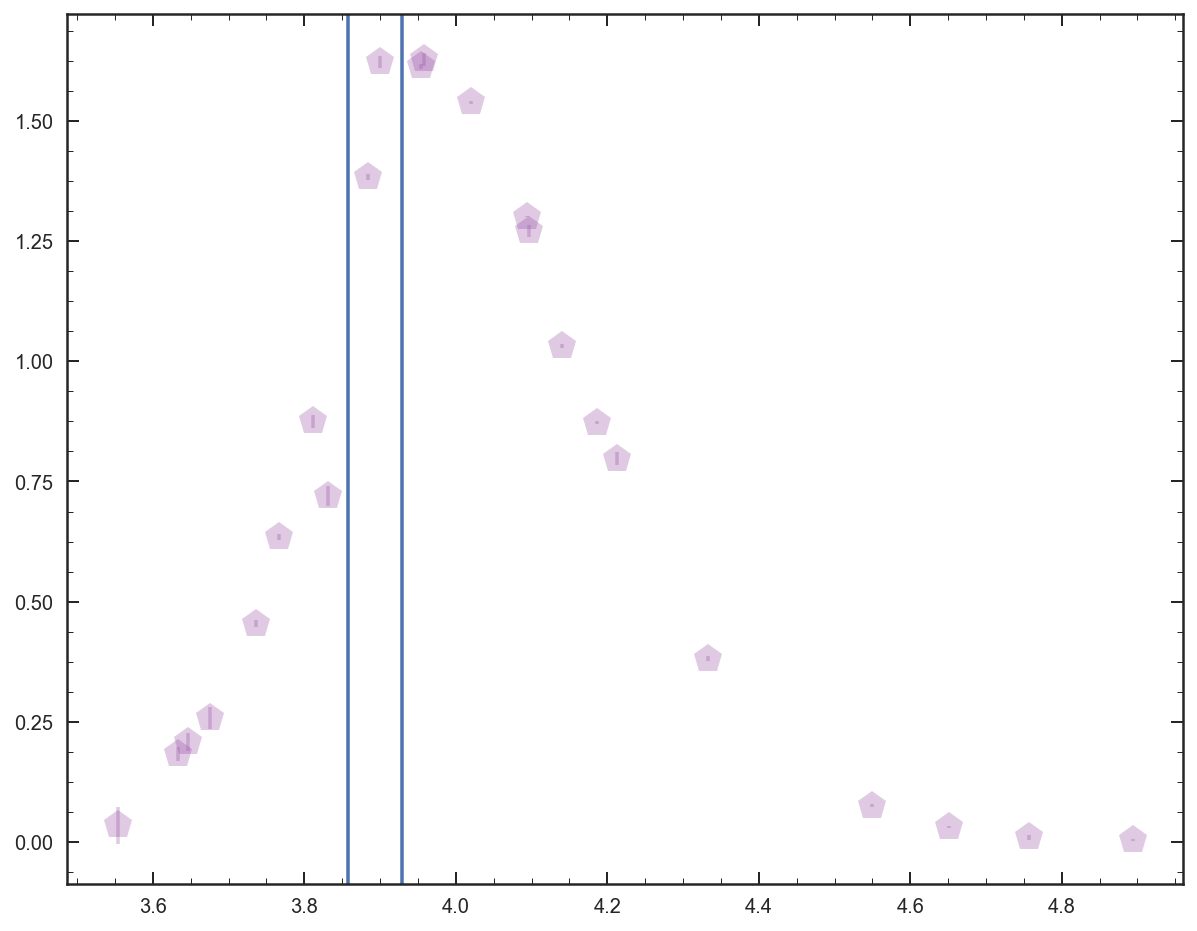

<Figure size 432x432 with 0 Axes>

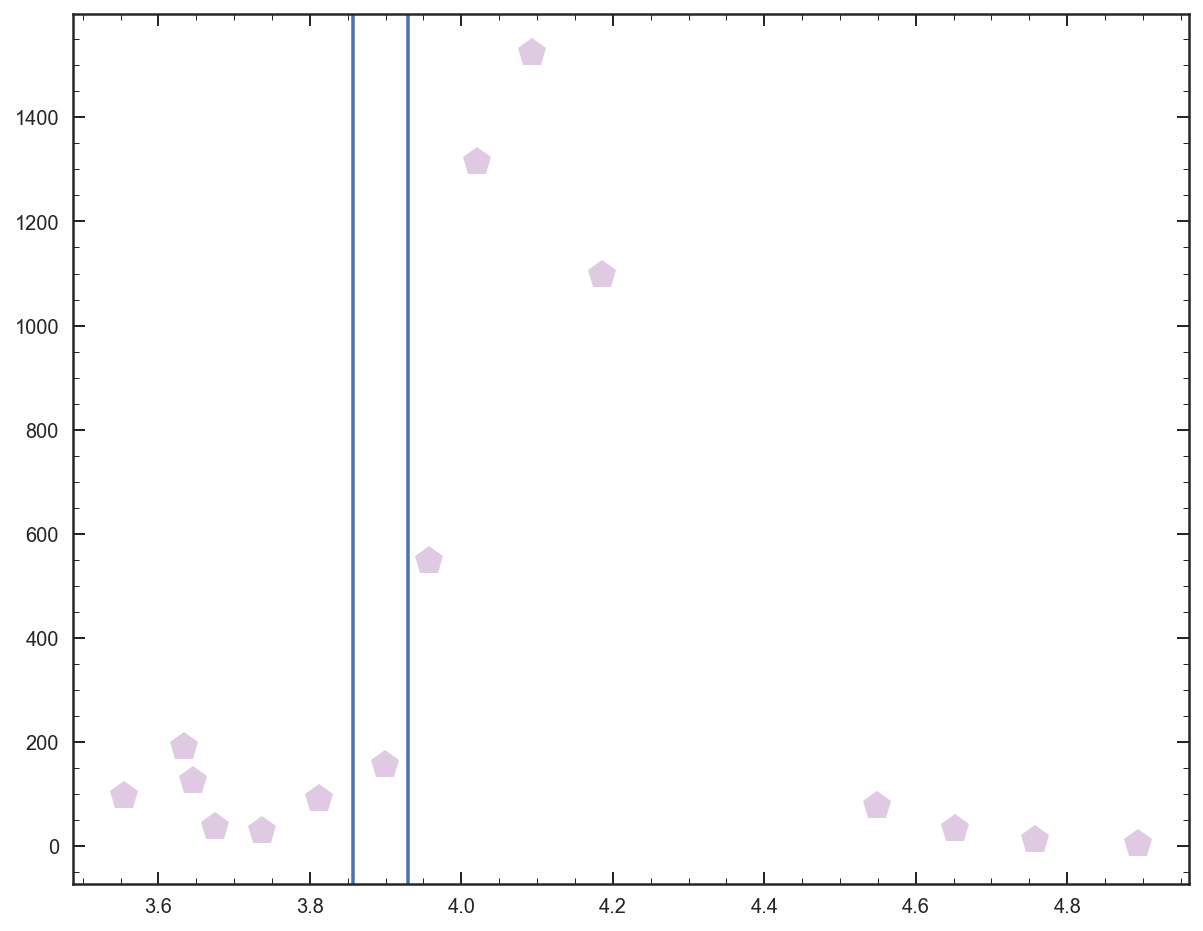

<Figure size 432x432 with 0 Axes>

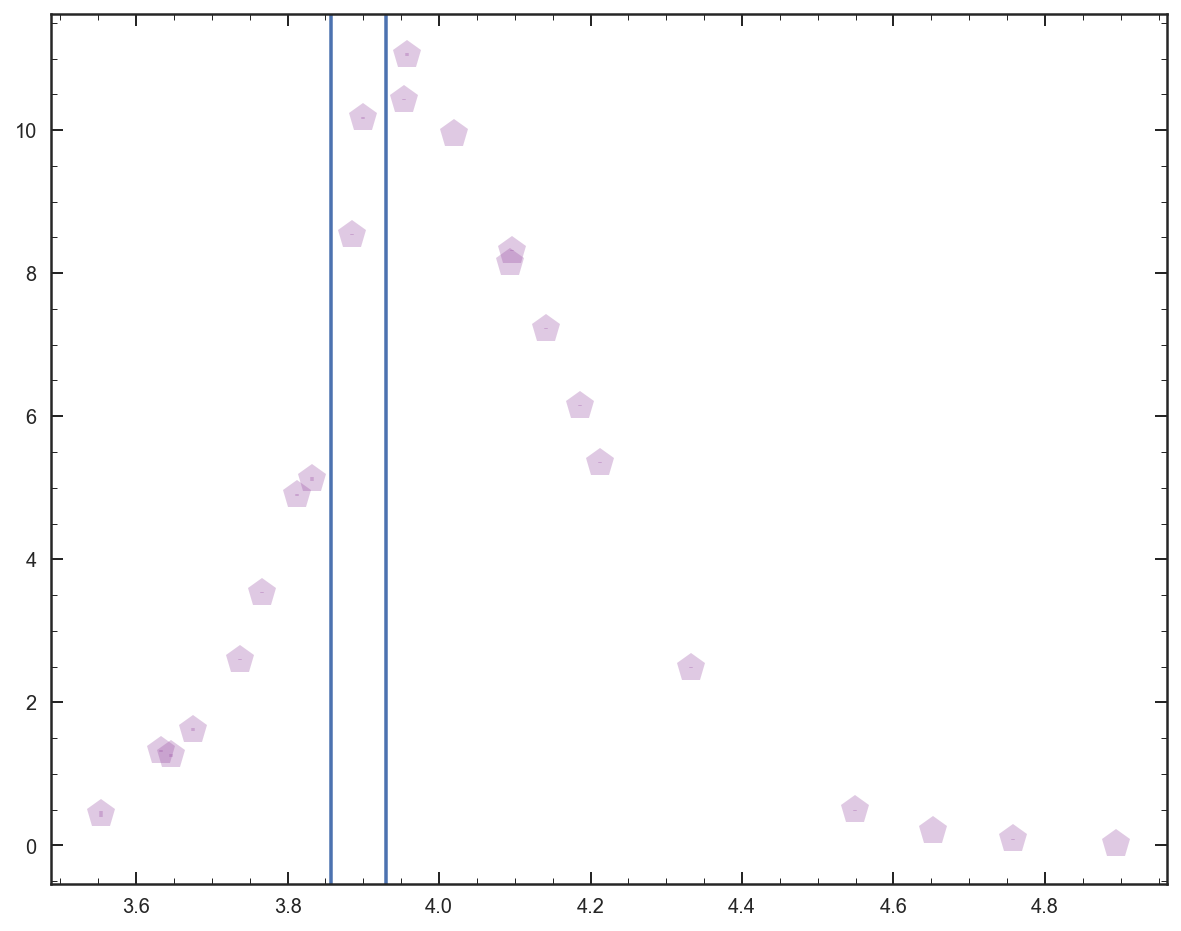

<Figure size 432x432 with 0 Axes>

In [255]:
for i in gnd_cat.index:
    star = ndat.query('id == {0}'.format(gnd_cat.id[i])).star_flag.values[0]
    if star > 0.8:
        try:
            g102_beam = glob('../beams/*{0}*g102*'.format(gnd_cat.id[i]))[0]
        except:
            g102_beam = ''

        try:
            g141_beam = glob('../beams/*{0}*g141*'.format(gnd_cat.id[i]))[0]
        except:
            g141_beam = ''

        GS = Gen_spec('GND', gnd_cat.id[i], 1, g102_beam, g141_beam, tmp_err=False,phot_errterm = 0.0)
        
        
        fig = plt.figure(figsize=[10,8])

        plt.errorbar(np.log10(GS.Pwv),GS.Pflx*1E18,GS.Perr*1E18,
                    linestyle='None', marker='p', markersize=15, color='#984ea3', alpha=0.3)
        if GS.g102:
            plt.errorbar(np.log10(GS.Bwv),GS.Bfl*1E18,GS.Ber*1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8')
        if GS.g141:
            plt.errorbar(np.log10(GS.Rwv),GS.Rfl*1E18,GS.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
        plt.axvline(np.log10(8500))
        plt.axvline(np.log10(7200))
        
        plt.figure(figsize=[6,6])   
        
        if GS.g102:
            plt.imshow(GS.Bbeam.beam.direct, interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)
        
        if GS.g141:
            plt.imshow(GS.Rbeam.beam.direct, interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)

In [1]:
from spec_exam import Gen_spec
gs = Gen_spec('GND',36348,1.25, '../beams/o129.0_36348.g102.A.fits', '../beams/o144.0_36348.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],
              tmp_err=False, phot_errterm=0.03, decontam = True)

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


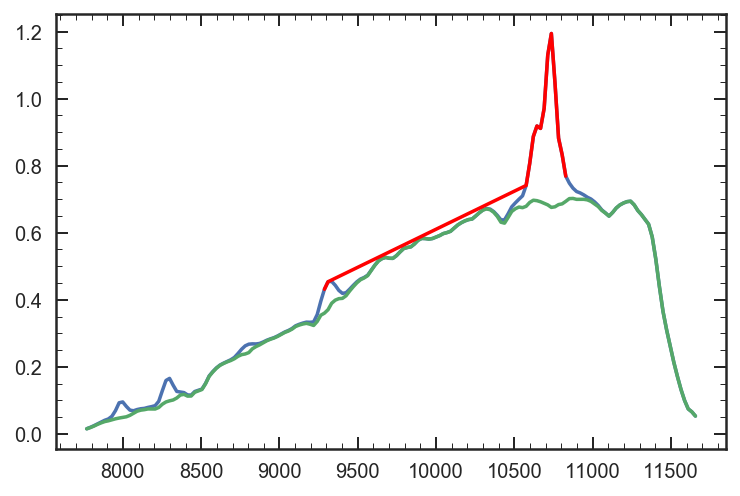

In [35]:
plt.plot(gs.Bwv,gs.Bline)
plt.plot(gs.Bwv,gs.Bcont)
# plt.fill_between(gs.Bwv,gs.Bcont - gs.Berr,gs.Bcont + gs.Berr)


w = []
l = []
for i in range(len(gs.Bcont)):
    if (gs.Bcont[i] + gs.Berr[i]) < gs.Bline[i]:
        w.append(gs.Bwv[i])
        l.append(gs.Bline[i])
plt.plot(w,l,'r')

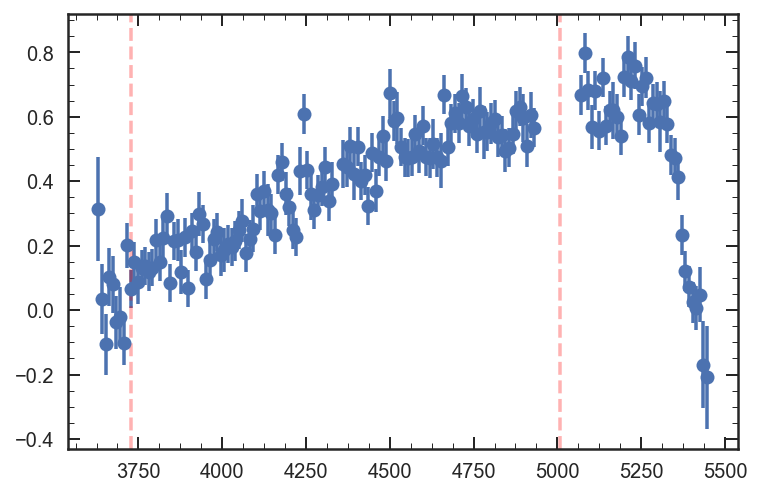

In [4]:
plt.errorbar(gs.Bwv/2.14,gs.Bflx, gs.Berr,fmt = 'o')

# plt.ylim(0,1E-17)
plt.axvline(3727.092,linestyle='--', color='r',alpha=.3)
plt.axvline(5008.240,linestyle='--', color='r',alpha=.3)

# w = []
# c = []
# for i in range(len(gs.Bcont)):
#     if (gs.Bcont[i] + gs.Berr[i]) > gs.Bline[i]:
#         w.append(gs.Bwv[i])
#         c.append(gs.Bflx[i])
        
    
# plt.plot(np.array(w)/2.14,c,'r')

In [17]:
Oldest_galaxy(1.6)

4.043504168783603

In [2]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)
wave, flux = sp.get_spectrum(tage = 4.0, peraa = True)

In [3]:
w,f = np.load('../data/test_spec.npy')

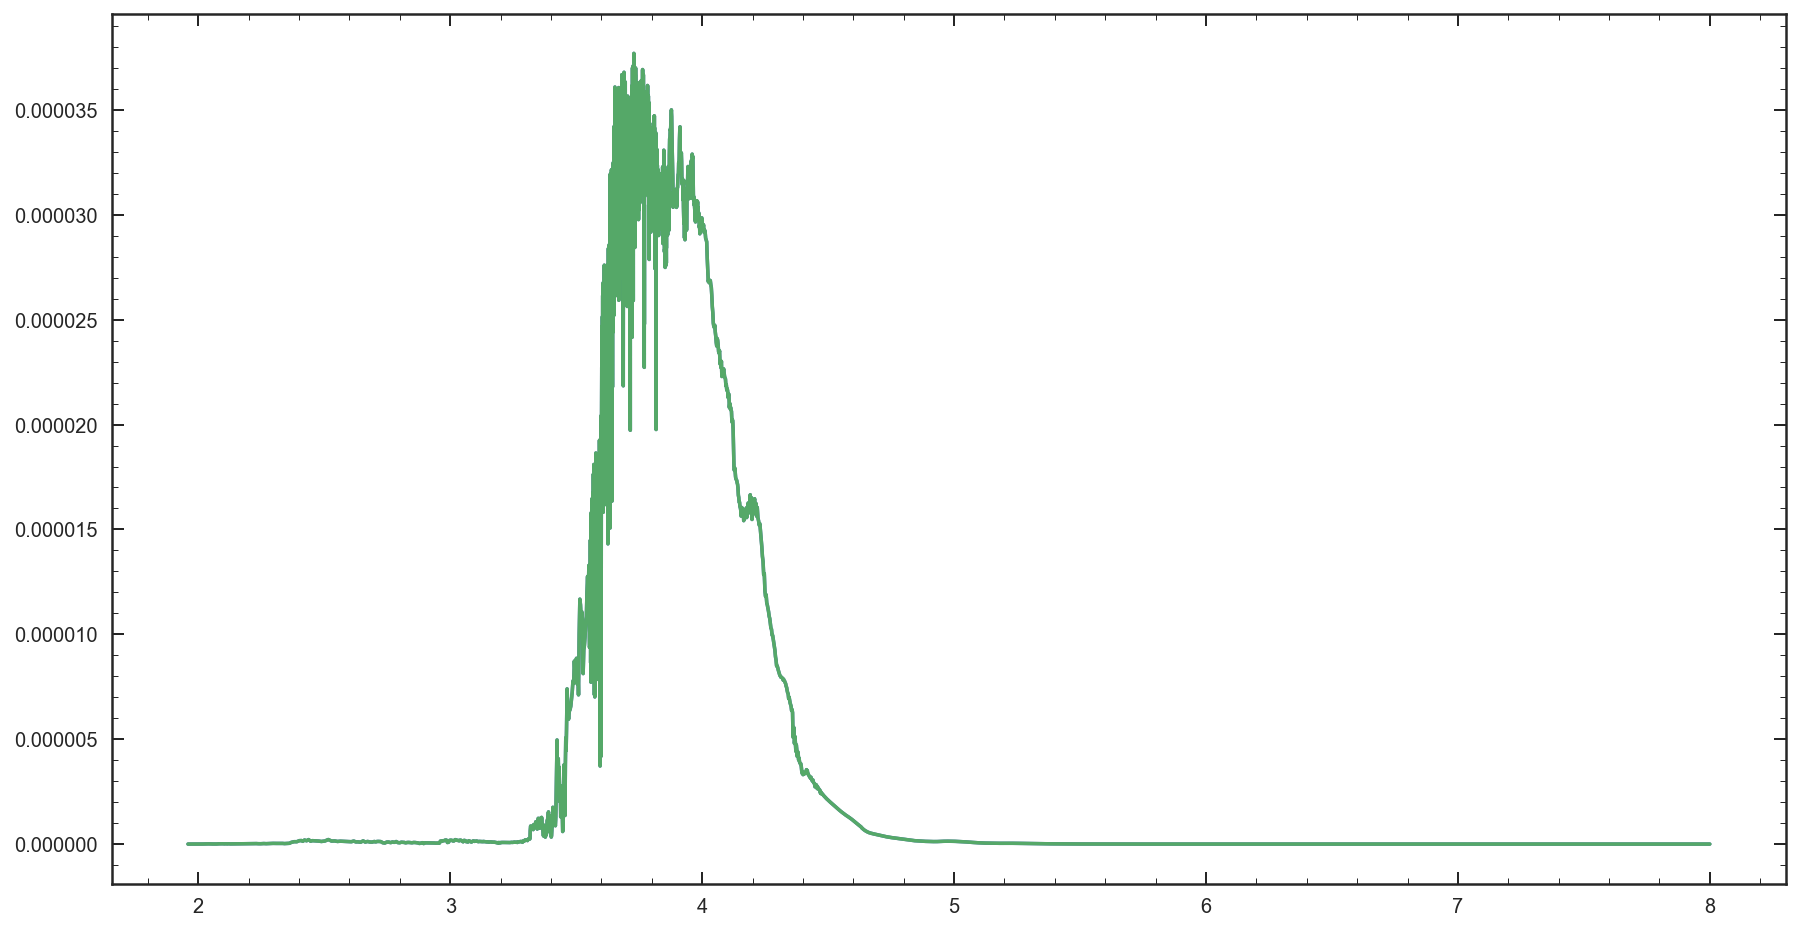

In [4]:
plt.figure(figsize=[15,8])

plt.plot(np.log10(w),f)
plt.plot(np.log10(wave),flux)